# Importing Packages Needed

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
from scipy.interpolate import UnivariateSpline
import glob 

# Definition of Named Tuples

In [2]:
subpulse = col.namedtuple('subpulse','phase intensity')
ind_sub = col.namedtuple('ind_sub','phase intensity width')
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 mid1 mid2 sub2, errors')
pulse_fits = col.namedtuple('pulse_fits','thorsett, powerlaw, linear')
one_fit = col.namedtuple('one_fit','params, errors, cov, chir')
pl_av = col.namedtuple('pl_av', 'frequency, phase')

# Definition of Functions

Functions needed to calculate chi squared values and find error in pulse data

In [3]:
def chsq(observed_values, expected_values, err):
    """
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [4]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [5]:
"""
Definitions of gaussian equations. 
"""
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

"""
Fitting data into the above gaussian equations. Number of gaussians is dependent on expected value and bounds.
"""
def multi_fit(x, y, error, expect, bound):
    params,cov=curve_fit(multi_gauss,x,y,expect,bounds=bound)
    fit=multi_gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-len(params))
    
    return params, cov, fit, chir

In [6]:
"""
    Creates a four gaussian fit for the full frequency scrunched data.
    Uses the peak of data to creat an expected value, attempts a fit, and if the chi squared reduced is below 1.1
    it returns the fit.
""" 

def fitting_ave_gaussians(x,y, error):   
    #Finding peak of the data
    mx=max(y)
    yl=list(y)
    mx_ind=yl.index(mx)
    mx_ph=x[mx_ind]
    
    #Attempts to use the peak of the data as an expected value, if it is in the correct range
    if mx_ph>pp1_lower and mx_ph<pp1_upper:
        expect=[mx,mx_ph,5, 15,pp2_1,5,15,pp2_2,5, 25,pp3,5]
    elif mx_ph>pp3_lower and mx_ph<pp3_upper:
        expect=[25,pp1,5,15,pp2_1,5,15,pp2_2,5, mx,mx_ph,5]
    else:
        expect=[25,pp1,5,15,pp2_1,2,15,pp2_2,2,25,pp3,5]

    bound=([0,0,0,0,pp1,0,0,pp1,0,0,pp3_lower-5,0],[np.inf,pp1_upper+5,10,np.inf,pp3,20,np.inf,pp3,20,np.inf,np.inf,10])
    
    #Trys to create a four gaussian fit
    try:
        #print(expect,bound)
        params, cov, fit, chir = multi_fit(x, y, error, expect, bound)
        sigma=np.sqrt(np.diag(cov))
    except Exception as e:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0
        print('Fit = 0 - No fit created on Fscrunched with the expected values')
    
    #If the data has a chi squared reduced above 1.1 then don't use the pulse
    if chir>2:
        print('Fit = 0 - Chi too high', chir)
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0  
        
        
    return fit, params, sigma, cov, chir

In [7]:
"""
    Based off the parameters of the fitting on the frequency scrunched profile, it creates an expected value for gaussian fits.
    Detects how many peaks are above 15 intensity, and that is the number of expected gaussians.
    If the maximum peak has a signal to noise less than 3.5, don't include this pulse. 
""" 
def find_expected(ax,ay,aerror):
    #Find the gaussian fit on the frequency scrunched profile
    fit=[]
    fit, params, sigma, cov, chir=fitting_ave_gaussians(ax,ay, aerror)
    expect=[]
    
    if len(fit)>0:
        #Find the peaks of the fit
        minima,maxima,mine,maxe=find_minima_maxima_gauss(params, cov, len(ax))
        maxy=multi_gauss(maxima,*params)
        peaks=[]
        peaky=[]
        #Only include profiles where the max peak has a signal/noise greater than 3.5
        if len(maxy)>0 and (max(maxy)/aerror)>5:
            for i in range(len(maxima)):
                #Only include peaks which are greater than 15
                if maxy[i]>15:
                    expect.extend([(maxy[i]+5),maxima[i],5])
                    peaks.append(maxima[i])
                    peaky.append(maxy[i])
        else:
            print('F scrunched pulse too noisey')
    if len(expect)<0:
        print('No expected value')
          
    return expect

In [8]:
"""
    Creates a gaussian fit for the data based on the expected value gained from the full frequency scrunched profile.
""" 
def fitting_gaussians(x,y, error, expect):   
    #Only includes frequency bands with error smaller than 30
    if error<30 and expect!=[]:
        #Attempts to use the peak of the data as an expected value, if it is in the correct range
        mx=max(y)
        yl=list(y)
        mx_ind=yl.index(mx)
        mx_ph=x[mx_ind]
        if mx_ph>pp1_lower and mx_ph<pp1_upper:
            expect[0]=mx
        elif mx_ph>pp3_lower and mx_ph<pp3_upper:
            expect[-3]=mx
        #Assigns the correct bounds, depending on number of gaussians
        bound=([],[])
        for i in range(0, len(expect), 3):
            bound[0].extend([0,0,0])
            bound[1].extend([np.inf,np.inf,30])
        #Attempts to create a fit for the data using the expected and bounds
        try:
            params, cov, fit, chir = multi_fit(x, y, error, expect,bound)
            sigma=np.sqrt(np.diag(cov))
        except:
            params=0
            fit=[]
            chir=5000
            sigma=0
            cov=0 
    else:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0   
    return fit, params, sigma, cov, chir

Finding Peak of Gaussian Fittings Function

In [9]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    Created by Keegan Smith
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [10]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian
    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [11]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function
    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
    
    #Find max and min errors
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [12]:
def gauss_peaksn(fit, nofreqband, freqband, cov, params,freq_low,freq_high,noise):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    #Used to convert phase bins into degrees
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err=find_minima_maxima_gauss(params, cov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    pul1=subpulse(phase=0, intensity=0)
    mi1=subpulse(phase=0, intensity=0)
    mi2=subpulse(phase=0, intensity=0)
    pul2=subpulse(phase=0, intensity=0)
    error=[0,0,0,0]
    
    #Assign the peaks to be either subpulse 1 or 2, or mid 1 or 2, also converts phase from bins to degrees
    if len(peakpos)!=0:
        for i in range(len(peakpos)):
            if peakpos[i]<pp1_upper and peakpos[i]>pp1_lower and (peakint[i]/noise)>3 and peakint[i]>pul1[1]:
                pul1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[0]=(err[i]*(deg_mod))
            elif peakpos[i]<((pp3-pp1)/2)+pp1 and peakpos[i]>pp1_upper and (peakint[i]/noise)>2 and peakint[i]>mi1[1]:
                mi1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[1]=(err[i]*(deg_mod))
            elif peakpos[i]<pp3_lower and peakpos[i]>((pp3-pp1)/2)+pp1 and (peakint[i]/noise)>2 and peakint[i]>mi2[1]:
                mi2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[2]=(err[i]*(deg_mod))        
            elif peakpos[i]<pp3_upper and peakpos[i]>pp3_lower and (peakint[i]/noise)>3 and peakint[i]>pul2[1]:
                pul2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[3]=(err[i]*(deg_mod))

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband-1))+freq_low+((freq_high-freq_low)/(2*nofreqband))
    profile_comp = pulse_sub(frequency=freq, sub1=pul1, mid1=mi1, mid2=mi2, sub2=pul2, errors=error)

    return profile_comp

Plotting Fittings Functions

In [13]:
"""
    Used to make different plots of the fits, their components and peaks.
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    params4 = params[9:12]
    gfit1 = gauss(ax, *params1)
    gfit2 = gauss(ax, *params2)
    gfit3 = gauss(ax, *params3)
    gfit4 = gauss(ax, *params4)

    py.plot(ax, ay, lw=0.5, label='data')
    #py.plot(ax,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')

    py.plot(ax, gfit1, "g")
    py.fill_between(ax, gfit1.min(), gfit1, facecolor="green", alpha=0.5)

    py.plot(ax, gfit2, "y")
    py.fill_between(ax, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    py.plot(ax, gfit3, "r")
    py.fill_between(ax, gfit3.min(), gfit3, facecolor="red", alpha=0.5)

    py.plot(ax, gfit4, "b")
    py.fill_between(ax, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot((360/no_bins)*x,y, lw=0.5)
    py.plot((360/no_bins)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[]
    y=[]
    for i in range(1,5):
        if profile_comp[i][0]!=0:
            x.append(profile_comp[i][0])
            y.append(profile_comp[i][1])

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Finding powerlaw and thorsett fits for data points

In [14]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return (m*np.array(x) +c)

In [15]:
"""
    Attempts to fit a thorsett, power law and linear equation to the data. Also calculates chi squared and reduced 
"""
def three_fits(frequency_comp, phase_comp, comp_err, num): 
    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1,0.1]
        elif num==3 or num==4:
            expect=[200,0.01,0.1]
        #Create the thorsett fit
        thorsett_params,thorsett_cov=curve_fit(thorsett,frequency_comp,phase_comp, expect, sigma=comp_err, maxfev=100000)
        thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
        thorsettf = thorsett(frequency_comp, *thorsett_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,thorsettf, comp_err)
        chre=ch/(len(phase_comp)-3)

        thorsett_fit=one_fit(params=thorsett_params, errors=thorsett_fit_error, cov=thorsett_cov, chir=chre)  
    except:
        print('No thorsett for component')
        thorsett_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1]
        elif num==3 or num==4:
            expect=[200,0.01]
        #Create the powerlaw fit
        pl_params,pl_cov=curve_fit(powerlaw,frequency_comp,phase_comp,expect, sigma=comp_err, maxfev=100000)
        pl_fit_error=np.sqrt(np.diag(pl_cov))
        powerlawf = powerlaw(frequency_comp, *pl_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,powerlawf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        pl_fit=one_fit(params=pl_params, errors=pl_fit_error, cov=pl_cov, chir=chre)
    except:
        print('No power law for component')
        pl_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[0.05,130]
        elif num==3 or num==4:
            expect=[0.01,230]
        #Create the linear fit
        lin_params,lin_cov=curve_fit(linear,frequency_comp,phase_comp,expect, sigma=comp_err)
        lin_fit_error=np.sqrt(np.diag(lin_cov))
        linearf = linear(np.array(frequency_comp), *lin_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,linearf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        lin_fit=one_fit(params=lin_params, errors=lin_fit_error, cov=lin_cov, chir=chre)
    except:
        print('No linear for component')
        lin_fit=0
        
    pulse_fit=pulse_fits(thorsett=thorsett_fit, powerlaw=pl_fit, linear=lin_fit)
    
    return pulse_fit

In [16]:
np.linspace(500, 300, 8)

array([500.        , 471.42857143, 442.85714286, 414.28571429,
       385.71428571, 357.14285714, 328.57142857, 300.        ])

In [17]:
def find_fits(fit_spulse,pnum,z):
    """
    Create the fits for each subpulse 1 through to 4
    """
    sfit1=0
    sfit2=0
    sfit3=0
    sfit4=0
    
    spfig=py.figure(2)
    
    #Find the movement of pulse across frequency for sub pulse 1, converting into graphable arrays
    p1, f1, e1=graphing_spulse(fit_spulse,1)
    #Remove outliers
    if p1!=[]:
        py.errorbar(p1,f1, xerr=e1, fmt='.', color='red', lw=1, label='data', zorder=10)
        py.title('Sub-Pulse 1 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f1, p1, e1 = detect_outlier(f1, p1, e1,2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 17
        if len(p1)>4 and (max(p1)-min(p1))<17:
            sfit1=three_fits(f1, p1, e1,1)
            py.errorbar(p1,f1, xerr=e1, fmt='.', color='blue', lw=1, label='data', zorder=11)
            linfit1 = linear(f1, *sfit1[2][0])
            py.plot(linfit1,f1, color='orange',lw=2,label='linear', zorder=10)
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 1'
            py.savefig(name)
            
            x=np.linspace(500, 300, 9)
            y=np.linspace(0,360,257)
            
            py.pcolormesh(y,x,z, cmap='PuRd')
            py.axis([25,175,300,500])
            py.savefig(name+' Freq')
            py.axis([25,100,300,500])
            py.savefig(name+' Freq2')
            
    py.clf()
    
    
    
    
    #Find the movement of pulse across frequency for sub pulse 4, converting into graphable arrays
    p4, f4, e4=graphing_spulse(fit_spulse,4)
    #Remove outliers
    if p4!=[]:
        py.errorbar(p4,f4, xerr=e4, fmt='.', color='red', lw=1, label='data', zorder=10)
        py.title('Sub-Pulse 4 -'+pnum)
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        
        f4, p4, e4 = detect_outlier(f4, p4, e4, 2)
        
        #Only include if there are 4 or more points, and if their range is no greater than 5
        if len(p4)>4 and (max(p4)-min(p4))<5:
            sfit4=three_fits(f4, p4, e4,4)
            py.errorbar(p4,f4, xerr=e4, fmt='.', color='blue', lw=1, label='data', zorder=11)
            linfit4 = linear(f4, *sfit4[2][0])
            py.plot(linfit4,f4, color='orange',lw=2,label='linear', zorder=10)
            name='single_pulse_fig/'+str(pnum)+ ' - ' + str(int(pnum)-1503960511) +' - Subpulse 4'
            py.savefig(name)
            
            x=np.linspace(500, 300, 9)
            y=np.linspace(0,360,257)
            
            py.pcolormesh(y,x,z, cmap='PuRd')
            py.axis([25,175,300,500])
            py.savefig(name+' Freq')
            py.axis([100,175,300,500])
            py.savefig(name+' Freq2')
    py.clf()

    
    
    all_fits=[sfit1, sfit2, sfit3, sfit4] 
    return all_fits

Averaging all single pulse movement

In [18]:
def jacobian_slope_pl(length,x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def ddA(A, alpha, x):
        return (1/length)*x**alpha
    def ddalpha(A, alpha, x):
        return (1/length)*alpha*A*x**(alpha-1)
    J = []
    for i in range(0, len(params), 2):
        A = params[i]
        alpha = params[i+1]
        mypars = [A, alpha, x]
        J.append(ddA(*mypars))
        J.append(ddalpha(*mypars))
    J = np.asmatrix(J)
    return J

In [19]:
def find_y_err_pl(x, popt, pcov):
    """
    Finds the error in the averaged power laws point x, based on all averaged together errors.
    x=list of all frequencys. 
    popt = parameter list across all pulses. 
    pcov=covarience matrix for all pulses
    sigma_y = sqrt.J*C*J_T
    """
    #Combine multiple cov matrices into one
    cov=np.zeros((len(pcov)*2,len(pcov)*2))
    for i, c in enumerate(pcov):
        cov[i*2][i*2]=c[0][0]
        cov[i*2][i*2+1]=c[0][1]
        cov[i*2+1][i*2]=c[1][0]
        cov[i*2+1][i*2+1]=c[1][1]
    err=[]
    #Finding the error - sqrt.J*C*J_T
    for i, point in enumerate(x):
        J = jacobian_slope_pl(len(x),point, *popt)
        JC = np.matmul(J, cov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        err.append(sigma_y)
    return err
#returns a list of errors

In [20]:
"""
    Functions used to get an average value of a list, the average of a list of parameters 
    and create a continuous powerlaw - x and y arrays.
"""
def average(num_list):
    sum_num=0
    for n in num_list:
        sum_num=sum_num+n
    avg=sum_num/len(num_list)
    return avg

def average_plfits(comp_params):
    param1=[]
    param2=[]
    for i, fit in enumerate(comp_params):
        param1.append(fit[0][0])
        param2.append(fit[0][1])

    av_param1=average(param1)
    av_param2=average(param2)
    return av_param1, av_param2

def create_lin_fit(lower,upper,param1,param2):
    x=list(range(lower,upper))
    y=[]
    for freq in x:
        y.append((param1 * freq) +param2)
    return x,y

Extra Stuff

In [21]:
"""
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_spulse)):
            if fit_spulse[i][spulse_num][0]!=0:
                phase_comp.append(fit_spulse[i][spulse_num][0])
                frequency_comp.append(fit_spulse[i][0])
                comp_err.append(fit_spulse[i][5][spulse_num-1])

        return phase_comp, frequency_comp, comp_err    

In [22]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

# INDIVIDUAL FREQUENCY BANDS

This section is mainly used for error checking the individual frequency bands of a pulse. The Average Profile section must be run before continuing onto the latter part of the code.

## Importing Data

Data must be in text file format from software pdv.
Also must be single pulse data so that the first column of numbers is always 0 (only one pulse). 

In [23]:
#New Files
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])
single_pulse = np.loadtxt(fname='../new_archive/f512/pulse_1503960513.paz.f512.b256.pdv', dtype=fulldatatype)
scrunched_pulse = np.loadtxt(fname='../new_archive/F/pulse_1503960513.paz.F.b256.pdv', dtype=fulldatatype)
profile = np.loadtxt(fname='../new_archive/all_pulse.paz.FT.b256.pdv', dtype=fulldatatype)

no_freq_bands = max(single_pulse['frequency'])+1
no_bins = max(single_pulse['phase'])+1

In [24]:
no_freq_bands

8

#### Average Profile - Defining locations of all peaks

This bit of code is hardcoded depending on the data and where the pulse window sits

(25.0, 112.5, 2.0, 8.0)

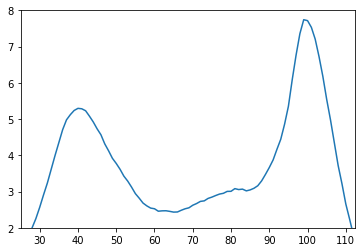

In [25]:
x=profile['phase']
y=profile['intensity']

py.plot(x,y)
py.axis([25,112.5,2,8])

In [26]:
pp1_lower=20
pp1=40
pp1_upper=57
pp2_1=55
pp2_2=75
pp3_lower=87
pp3=100
pp3_upper=118

## Gaussian Fitting - Broken Down for Each Frequency

From all the frequency profiles it takes only the one frequency band. 

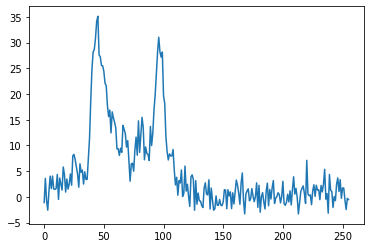

In [27]:
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])

#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

py.plot(ax,ay)

In [28]:
params,cov=curve_fit(multi_gauss,ax,ay,(25, 40, 5, 15, 55, 2, 15, 75, 2, 25, 100, 5))

In [29]:
params

array([19.50315221, 42.74293607,  2.86352842, 14.05674006, 49.19859069,
        5.00352171, 10.18003148, 67.43740885, 30.45933555, 23.59404559,
       96.80061846,  3.50286846])

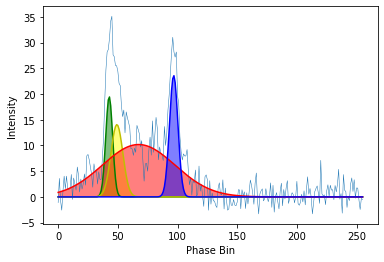

In [30]:
params1 = params[0:3]
params2 = params[3:6]
params3 = params[6:9]
params4 = params[9:12]
gfit1 = gauss(ax, *params1)
gfit2 = gauss(ax, *params2)
gfit3 = gauss(ax, *params3)
gfit4 = gauss(ax, *params4)
    
py.plot(ax, ay, lw=0.5, label='data')
#py.plot(ax,fit,color='red',lw=3,label='gaussian fit')
py.xlabel('Phase Bin')
py.ylabel('Intensity')

py.plot(ax, gfit1, "g")
py.fill_between(ax, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
py.plot(ax, gfit2, "y")
py.fill_between(ax, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

py.plot(ax, gfit3, "r")
py.fill_between(ax, gfit3.min(), gfit3, facecolor="red", alpha=0.5)

py.plot(ax, gfit4, "b")
py.fill_between(ax, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)

/data/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


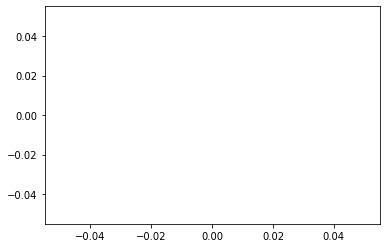

In [31]:
#Isolating a single frequency for a pulse
freqband = 9
f = single_pulse['frequency'] == freqband

x=single_pulse['phase'][f]
y=single_pulse['intensity'][f]
noise = sigmaClip(y)
error = np.nanstd(noise[1])
py.plot(x,y)

In [32]:
#Uses expected parameters and returns a fit for the frequency band
fit, params, sigma, cov, chir=fitting_gaussians(x,y,error, expect)
#If there is a fit, finds peaks where derivative is equal to zero
#Also classifys it as subpulse 1, 2, 3 or 4 depending on location
if fit!=[] and expect!=[]:
    pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500,error)
    plot_peaks(x,y, pulse_subp)
    print(pulse_subp)
elif fit==[]:
    print('No fit')
elif expect==[]:
    print('No expect')

No fit


# INDIVIDUAL PULSE

This section is mainly used for error checking the fit across frequency for an individual pulse.

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [33]:
fit_spulse = []
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])
#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

In [34]:
for i in range(no_freq_bands):
    #Creating arrays for pulse and finding frequency band noise
    freqband = i
    f = single_pulse['frequency'] == freqband
    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    #Try creating a gaussian fit, based on expected valyes from F scrunched profile
    if len(y)!=0:
        fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
    #If a fit was created find peaks and separate into subpulse categories
    if len(y)!=0 and fit!=[] and expect!=[]:
        pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error) 
        fit_spulse.append(pulse_subp)

<ipython-input-34-9a0d957eb77b>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(y)!=0 and fit!=[] and expect!=[]:


## Change of Peak Position over Frequency

Used to visually show the movement of of each subpulse across frequency, this is looped later on for all pulses


The power law equation of fit for this pulse is: 	 Phase = 11.607 ν^0.294
The errors are 6.784622253114704, 0.09812840419227276
The chi squared reduced is -0.04930869765188328, and the chi squared is 9.753456511740584



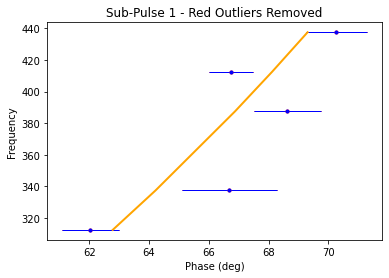

In [35]:
#Create graphable arrays for subpulse 1
p1, f1, e1=graphing_spulse(fit_spulse,1)
#Graph points and removed outliers
if p1!=[]:
    py.errorbar(p1,f1, xerr=e1, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 1 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f1, p1, e1 = detect_outlier(f1, p1, e1,2)
    #Only include if there are 4 points or more, and range is less than 17
    if len(p1)>3 and (max(p1)-min(p1))<17:
        py.errorbar(p1,f1, xerr=e1, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p1,pl_c1=curve_fit(powerlaw,f1,p1, maxfev=100000, sigma=e1)
    pl_e1=np.sqrt(np.diag(pl_c1))
    powerlaw1 = powerlaw(f1, *pl_p1)

    py.plot(powerlaw1,f1, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p1,powerlaw1, e1)
    chre=ch/len(p1)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p1[0]:.3f} \u03BD^{pl_p1[1]:.3f}')
    print(f'The errors are {pl_e1[0]}, {pl_e1[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 1')

In [36]:
#Create graphable arrays for subpulse 2
p2, f2, e2=graphing_spulse(fit_spulse,2)
#Graph points and removed outliers
if p2!=[]:
    py.errorbar(p2,f2, xerr=e2, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 2 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f2, p2, e2 = detect_outlier(f2, p2, e2,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p2)>3 and (max(p2)-min(p2))<10:
        py.errorbar(p2,f2, xerr=e2, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p2,pl_c2=curve_fit(powerlaw,f2,p2, maxfev=100000)
    pl_e2=np.sqrt(np.diag(pl_c2))
    powerlaw2 = powerlaw(f2, *pl_p2)

    py.plot(powerlaw2,f2, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p2,powerlaw2, e2)
    chre=ch/len(p2)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p2[0]:.3f} \u03BD^{pl_p2[1]:.3f}')
    print(f'The errors are {pl_e2[0]}, {pl_e2[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 2')

No power law for component 2


In [37]:
#Create graphable arrays for subpulse 3
p3, f3, e3=graphing_spulse(fit_spulse,3)
#Graph points and removed outliers
if p3!=[]:
    py.errorbar(p3,f3, xerr=e3, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 3 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f3, p3, e3 = detect_outlier(f3, p3, e3,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p3)>3 and (max(p3)-min(p3))<10:
        py.errorbar(p3,f3, xerr=e3, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p3,pl_c3=curve_fit(powerlaw,f3,p3, maxfev=100000, sigma=e3)
    pl_e3=np.sqrt(np.diag(pl_c3))
    powerlaw3 = powerlaw(f3, *pl_p3)

    py.plot(powerlaw3,f3, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p3,powerlaw3, e3)
    chre=ch/len(p3)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p3[0]:.3f} \u03BD^{pl_p3[1]:.3f}')
    print(f'The errors are {pl_e3[0]}, {pl_e3[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 3')
    


No power law for component 3


The power law equation of fit for this pulse is: 	 Phase = 84.994 ν^0.079
The errors are 4.982867090386552, 0.010060491404635571
The chi squared reduced is -1.9890312302910627, and the chi squared is 0.03290630912681221



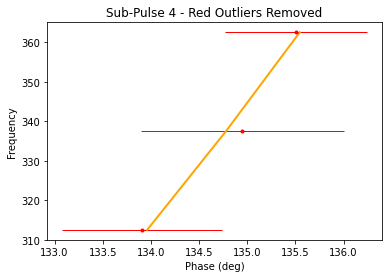

In [38]:
#Create graphable arrays for subpulse 4
p4, f4, e4=graphing_spulse(fit_spulse,4)
#Graph points and removed outliers
if p4!=[]:
    py.errorbar(p4,f4, xerr=e4, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 4 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f4, p4, e4 = detect_outlier(f4, p4, e4,2)
    #Only include if there are 4 points or more, and range is less than 5
    if len(p4)>3 and (max(p4)-min(p4))<5:
        py.errorbar(p4,f4, xerr=e4, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    expect=[100,0.1]
    pl_p4,pl_c4=curve_fit(powerlaw,f4,p4, expect, maxfev=100000, sigma=e4)
    pl_e4=np.sqrt(np.diag(pl_c4))
    powerlaw4 = powerlaw(f4, *pl_p4)

    py.plot(powerlaw4,f4, color='orange',lw=2,label='powerlaw')
    #py.axis((233,235,300,500))
        
    ch=chsq_err(p4,powerlaw4, e4)
    chre=ch/len(p4)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p4[0]:.3f} \u03BD^{pl_p4[1]:.3f}')
    print(f'The errors are {pl_e4[0]}, {pl_e4[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 4')
    
#py.axis([236,239,300,480])

In [39]:
def graph_subpulse_evo(fit_spulse,num,pulse):
    #Create graphable arrays for subpulse 4
    p, f, e=graphing_spulse(fit_spulse,num)
    #Graph points and removed outliers
    if p!=[]:
        spfig = py.figure(2)
        py.errorbar(p,f, xerr=e, fmt='.', color='red', lw=1, label='data')
        py.title(('Sub-Pulse '+ str(num) + ' - Red Outliers Removed'))
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
        f, p, e = detect_outlier(f, p, e,2)
        #Only include if there are 4 points or more, and range is less than 5
        if len(p4)>3 and (max(p4)-min(p4))<5:
            py.errorbar(p,f, xerr=e, fmt='.', color='blue', lw=1, label='data')
    #Create a powerlaw fit and graph
    try:
        expect=[100,0.1]
        pl_p,pl_c=curve_fit(linear,f,p, expect, maxfev=100000, sigma=e)
        pl_e=np.sqrt(np.diag(pl_c))
        powerlaw = linear(f, *pl_p)

        py.plot(powerlaw,f, color='orange',lw=2,label='linear')
        py.savefig(('single_pulse_fig/'+str(pulse)+' - Subpulse - '+str(num)))
        py.clf(spfig)
    except:
        print(' ')

# ALL PULSES

In [40]:
"""
Manually removing fits which visually look inaccurate, too spread, or don't match the profile.
"""

mr_1=[2,27,45,59,60,77,80,81,82,86,106,143,254,257,261,263,286,379,405,406,408,410,483,490,515,518,560,583,584,587,607,619,620,625,628,694,712,984,1384,1653,1690,2038,2896,2899,2933,2946,2948,2949,2951,3077,3097,3366,3420,3421,3517,3527,3530,3598,3656,3669,3685,3686,3690,3727,3746,3759,3794,3812,4022,4031,4068,4093,4145,4503,4589,4724,4746,4820,4885,4889,5002,5238,5252,5397,5472,5473,6115,6268,6290,6370,7292,7350,7713,7714,8084,9275,9276,9370,9433,9621]
mr_2=[3,11,16,28,31,32,35,50,57,71,76,100,110,114,128,129,136,151,152,153,154,156,157,160,172,180,261,262,263,265,372,373,378,381,382,384,386,406,410,412,490,512,548,559,561,577,581,592,603,615,616,631,635,637,638,651,653,654,656,667,670,701,714,740,1258,1268,1270,1272,1277,1280,1346,1356,1361,1364,1367,1373,1376,1377,1400,1416,1418,1419,1441,1460,1663,1926,2175,2289,2487,2562,2583,2941,2950,2952,3059,3067,3068,3089,3090,3121,3136,3155,3156,3158,3238,3245,3302,3318,3348,3350,3393,3539,3543,3544,3545,3600,3603,3616,3628,3645,3646,3693,3704,3732,3735,3737,3740,3759,3771,3781,3786,3865,4033,4046,4073,4078,4094,4392,4405,4406,4414,4457,4461,4513,4579,4606,4736,4794,4810,4826,4843,4934,5155,5156,5157,5160,5193,5205,5253,5254,5257,5260,5264,5317,5396,5399,5461,5470,5480,5481,5538,5556,5642,5737,5739,5796,5827,5914,5935,6061,6180,6271,6280,6284,6329,6419,6530,6550,6562,6611,6638,6712,6728,6784,6808,6822,6857,6864,6930,6973,7184,7185,7224,7278,7281,7340,7417,7474,7560,7572,7745,7801,7906,8072,8149,8165,8481,8485,8767,8823,8852,8861,8906,8923,8961,8962,8977,9017,9053,9102,9133,9171,9204,9245,9368,9534,9600,9601,9607,9609,9611,9613,9628]

def manual_removal(pulse_num, fits):
    if pulse_num in mr_1:
        fits[0]=0
    if pulse_num in mr_2:
        fits[3]=0
    return fits

### Importing Files

In [41]:
#Import names of files into an array
#First file should lead to all single pulses which contain frequency information to be analysed
pulse_names = glob.glob("../new_archive/f512/pulse*.paz.f512.b256.pdv")
#Second file should lead to all single pulses which are fully frequency scrunched
ave_names = glob.glob("../new_archive/F/pulse_*.paz.F.b256.pdv")
#Sort the names in order
pulse_names=sorted(pulse_names)
ave_names=sorted(ave_names)

In [42]:
#linear([400.0, 362.5, 350.0, 337.5, 325.0],*[1.99548191e-02,1.31497793e+02])

1.99548191e-02*np.array([400.0, 362.5, 350.0, 337.5, 325.0])+1.31497793e+02

array([139.47972064, 138.73141492, 138.48197968, 138.23254445,
       137.98310921])

0 1503960511


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
1 1503960512


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2 1503960513


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3 1503960514


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4 1503960515


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5 1503960516


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6 1503960517
Plot 1
7 1503960518


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
8 1503960519


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9 1503960520
F scrunched pulse too noisey
10 1503960521
F scrunched pulse too noisey
11 1503960522


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


12 1503960523


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
13 1503960524


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


14 1503960525
15 1503960526
16 1503960527
17 1503960528


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


18 1503960529
F scrunched pulse too noisey
19 1503960530
Plot 1
20 1503960531


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
21 1503960532


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


22 1503960533
Plot 1
23 1503960534


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


24 1503960535


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
25 1503960536


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


26 1503960537
F scrunched pulse too noisey
27 1503960538
28 1503960539


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


29 1503960540


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
30 1503960541


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
31 1503960542


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


32 1503960543


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


33 1503960544


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


34 1503960545
Plot 4
35 1503960546


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


36 1503960547


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
37 1503960548


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
38 1503960549


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


39 1503960550


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


40 1503960551
41 1503960552
42 1503960553


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
43 1503960554
F scrunched pulse too noisey
44 1503960555
F scrunched pulse too noisey
45 1503960556


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


46 1503960557
F scrunched pulse too noisey
47 1503960558
F scrunched pulse too noisey
48 1503960559


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
49 1503960560


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


50 1503960561
51 1503960562


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
52 1503960563


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
53 1503960564
F scrunched pulse too noisey
54 1503960565


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


55 1503960566
56 1503960567
57 1503960568


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


58 1503960569


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
59 1503960570


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


60 1503960571


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


61 1503960572


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


62 1503960573
Plot 1
63 1503960574
F scrunched pulse too noisey
64 1503960575


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


65 1503960576
F scrunched pulse too noisey
66 1503960577
F scrunched pulse too noisey
67 1503960578


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


68 1503960579
69 1503960580
70 1503960581
71 1503960582
72 1503960583


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
73 1503960584


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
74 1503960585


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
75 1503960586


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
76 1503960587


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


77 1503960588


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
78 1503960589


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
79 1503960590


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


80 1503960591


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


81 1503960592


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


82 1503960593


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


83 1503960594


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
84 1503960595


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
85 1503960596


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
86 1503960597


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


87 1503960598


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


88 1503960599
Plot 1
89 1503960600


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


90 1503960601
F scrunched pulse too noisey
91 1503960602
92 1503960603
F scrunched pulse too noisey
93 1503960604
94 1503960605
F scrunched pulse too noisey
95 1503960606
96 1503960607
Plot 4
97 1503960608


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
98 1503960609


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


99 1503960610
Plot 4
100 1503960611


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


101 1503960612
F scrunched pulse too noisey
102 1503960613
F scrunched pulse too noisey
103 1503960614
F scrunched pulse too noisey
104 1503960615


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
105 1503960616
F scrunched pulse too noisey
106 1503960617


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


107 1503960618


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


108 1503960619
F scrunched pulse too noisey
109 1503960620
110 1503960621
111 1503960622
F scrunched pulse too noisey
112 1503960623


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


113 1503960624
F scrunched pulse too noisey
114 1503960625
115 1503960626


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
116 1503960627


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
117 1503960628


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
118 1503960629


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


119 1503960630


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


120 1503960631
121 1503960632
122 1503960633
F scrunched pulse too noisey
123 1503960634
124 1503960635
F scrunched pulse too noisey
125 1503960636
Plot 1
126 1503960637


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
127 1503960638
Plot 1
128 1503960639


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
129 1503960640


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


130 1503960641
F scrunched pulse too noisey
131 1503960642


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
132 1503960643
F scrunched pulse too noisey
133 1503960644


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


134 1503960645
135 1503960646
Plot 4
136 1503960647


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


137 1503960648
F scrunched pulse too noisey
138 1503960649


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
139 1503960650


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
140 1503960651


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
141 1503960652


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


142 1503960653
F scrunched pulse too noisey
143 1503960654
144 1503960655


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


145 1503960656


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


146 1503960657
147 1503960658
148 1503960659
F scrunched pulse too noisey
149 1503960660
150 1503960661


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
151 1503960662


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


152 1503960663


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
153 1503960664


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


154 1503960665


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


155 1503960666


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


156 1503960667


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


157 1503960668


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


158 1503960669
F scrunched pulse too noisey
159 1503960670
F scrunched pulse too noisey
160 1503960671


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


161 1503960672
F scrunched pulse too noisey
162 1503960673
163 1503960674
164 1503960675


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


165 1503960676


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
166 1503960677


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


167 1503960678
168 1503960679
169 1503960680
170 1503960681
171 1503960682
172 1503960683
173 1503960684


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
174 1503960685
F scrunched pulse too noisey
175 1503960686


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


176 1503960687
177 1503960688
178 1503960689
F scrunched pulse too noisey
179 1503960690
F scrunched pulse too noisey
180 1503960691
181 1503960692


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
182 1503960693


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
183 1503960694
F scrunched pulse too noisey
184 1503960695


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
185 1503960696


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


186 1503960697
F scrunched pulse too noisey
187 1503960698
F scrunched pulse too noisey
188 1503960699
F scrunched pulse too noisey
189 1503960700
F scrunched pulse too noisey
190 1503960701
F scrunched pulse too noisey
191 1503960702
F scrunched pulse too noisey
192 1503960703
F scrunched pulse too noisey
193 1503960704
F scrunched pulse too noisey
194 1503960705
F scrunched pulse too noisey
195 1503960706
F scrunched pulse too noisey
196 1503960707
F scrunched pulse too noisey
197 1503960708
F scrunched pulse too noisey
198 1503960709
199 1503960710
F scrunched pulse too noisey
200 1503960711
F scrunched pulse too noisey
201 1503960712
F scrunched pulse too noisey
202 1503960713
F scrunched pulse too noisey
203 1503960714
F scrunched pulse too noisey
204 1503960715
205 1503960716
F scrunched pulse too noisey
206 1503960717
F scrunched pulse too noisey
207 1503960718
F scrunched pulse too noisey
208 1503960719
F scrunched pulse too noisey
209 1503960720
F scrunched pulse too noisey
21

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


220 1503960731
F scrunched pulse too noisey
221 1503960732
F scrunched pulse too noisey
222 1503960733
F scrunched pulse too noisey
223 1503960734
F scrunched pulse too noisey
224 1503960735
225 1503960736
F scrunched pulse too noisey
226 1503960737
F scrunched pulse too noisey
227 1503960738
F scrunched pulse too noisey
228 1503960739
F scrunched pulse too noisey
229 1503960740


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
230 1503960741


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
231 1503960742


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
232 1503960743


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
233 1503960744


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
234 1503960745


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
235 1503960746
F scrunched pulse too noisey
236 1503960747


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


237 1503960748
F scrunched pulse too noisey
238 1503960749
F scrunched pulse too noisey
239 1503960750
F scrunched pulse too noisey
240 1503960751
F scrunched pulse too noisey
241 1503960752
F scrunched pulse too noisey
242 1503960753
F scrunched pulse too noisey
243 1503960754
244 1503960755
F scrunched pulse too noisey
245 1503960756
Plot 1
Plot 4
246 1503960757
F scrunched pulse too noisey
247 1503960758
F scrunched pulse too noisey
248 1503960759
F scrunched pulse too noisey
249 1503960760
F scrunched pulse too noisey
250 1503960761


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


251 1503960762
Plot 1
252 1503960763


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


253 1503960764
F scrunched pulse too noisey
254 1503960765


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


255 1503960766
F scrunched pulse too noisey
256 1503960767
F scrunched pulse too noisey
257 1503960768


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


258 1503960769


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
259 1503960770


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
260 1503960771


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
261 1503960772


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


262 1503960773


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
263 1503960774


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


264 1503960775


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
265 1503960776


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


266 1503960777
F scrunched pulse too noisey
267 1503960778
F scrunched pulse too noisey
268 1503960779
F scrunched pulse too noisey
269 1503960780
F scrunched pulse too noisey
270 1503960781


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


271 1503960782
272 1503960783
Plot 1
Plot 4
273 1503960784
F scrunched pulse too noisey
274 1503960785


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


275 1503960786
F scrunched pulse too noisey
276 1503960787
F scrunched pulse too noisey
277 1503960788
F scrunched pulse too noisey
278 1503960789
F scrunched pulse too noisey
279 1503960790
F scrunched pulse too noisey
280 1503960791
F scrunched pulse too noisey
281 1503960792
282 1503960793
Fit = 0 - Chi too high 2.1122606949756233
283 1503960794
F scrunched pulse too noisey
284 1503960795
285 1503960796
286 1503960797


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


287 1503960798


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
288 1503960799


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
289 1503960800


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
290 1503960801


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
291 1503960802


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
292 1503960803


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


293 1503960804
F scrunched pulse too noisey
294 1503960805
F scrunched pulse too noisey
295 1503960806
F scrunched pulse too noisey
296 1503960807
F scrunched pulse too noisey
297 1503960808
F scrunched pulse too noisey
298 1503960809
F scrunched pulse too noisey
299 1503960810
F scrunched pulse too noisey
300 1503960811
F scrunched pulse too noisey
301 1503960812
302 1503960813
F scrunched pulse too noisey
303 1503960814
F scrunched pulse too noisey
304 1503960815
F scrunched pulse too noisey
305 1503960816
F scrunched pulse too noisey
306 1503960817
F scrunched pulse too noisey
307 1503960818
308 1503960819
F scrunched pulse too noisey
309 1503960820
F scrunched pulse too noisey
310 1503960821
F scrunched pulse too noisey
311 1503960822
F scrunched pulse too noisey
312 1503960823
F scrunched pulse too noisey
313 1503960824
F scrunched pulse too noisey
314 1503960825
F scrunched pulse too noisey
315 1503960826
Fit = 0 - Chi too high 2.0019371661158045
316 1503960827
F scrunched pulse 

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
370 1503960881


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
371 1503960882


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
372 1503960883


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
373 1503960884


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
374 1503960885


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
375 1503960886


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
376 1503960887


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
377 1503960888


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
378 1503960889


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


379 1503960890


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


380 1503960891


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
381 1503960892


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
382 1503960893


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


383 1503960894


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
384 1503960895


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


385 1503960896


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
386 1503960897


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


387 1503960898


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
388 1503960899
F scrunched pulse too noisey
389 1503960900
F scrunched pulse too noisey
390 1503960901
F scrunched pulse too noisey
391 1503960902
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
392 1503960903


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
393 1503960904
F scrunched pulse too noisey
394 1503960905
F scrunched pulse too noisey
395 1503960906


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


396 1503960907
F scrunched pulse too noisey
397 1503960908
F scrunched pulse too noisey
398 1503960909
F scrunched pulse too noisey
399 1503960910
F scrunched pulse too noisey
400 1503960911
F scrunched pulse too noisey
401 1503960912
F scrunched pulse too noisey
402 1503960913
F scrunched pulse too noisey
403 1503960914
F scrunched pulse too noisey
404 1503960915


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
405 1503960916


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


406 1503960917


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


407 1503960918


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


408 1503960919


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


409 1503960920
410 1503960921
411 1503960922


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
412 1503960923


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


413 1503960924


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
414 1503960925
F scrunched pulse too noisey
415 1503960926
F scrunched pulse too noisey
416 1503960927
F scrunched pulse too noisey
417 1503960928
F scrunched pulse too noisey
418 1503960929


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
419 1503960930
F scrunched pulse too noisey
420 1503960931
F scrunched pulse too noisey
421 1503960932
F scrunched pulse too noisey
422 1503960933
F scrunched pulse too noisey
423 1503960934
F scrunched pulse too noisey
424 1503960935
F scrunched pulse too noisey
425 1503960936
F scrunched pulse too noisey
426 1503960937
F scrunched pulse too noisey
427 1503960938
F scrunched pulse too noisey
428 1503960939
F scrunched pulse too noisey
429 1503960940
F scrunched pulse too noisey
430 1503960941
F scrunched pulse too noisey
431 1503960942
F scrunched pulse too noisey
432 1503960943
F scrunched pulse too noisey
433 1503960944
434 1503960945
F scrunched pulse too noisey
435 1503960946
F scrunched pulse too noisey
436 1503960947
F scrunched pulse too noisey
437 1503960948
F scrunched pulse too noisey
438 1503960949
F scrunched pulse too noisey
439 1503960950
F scrunched pulse too noisey
440 1503960951
F scrunched pulse too noisey
441 1503960952
F scrunched pulse

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


443 1503960954
F scrunched pulse too noisey
444 1503960955
445 1503960956
F scrunched pulse too noisey
446 1503960957
F scrunched pulse too noisey
447 1503960958
F scrunched pulse too noisey
448 1503960959
F scrunched pulse too noisey
449 1503960960
F scrunched pulse too noisey
450 1503960961
F scrunched pulse too noisey
451 1503960962
F scrunched pulse too noisey
452 1503960963
F scrunched pulse too noisey
453 1503960964
F scrunched pulse too noisey
454 1503960965
F scrunched pulse too noisey
455 1503960966
F scrunched pulse too noisey
456 1503960967
F scrunched pulse too noisey
457 1503960968
F scrunched pulse too noisey
458 1503960969
F scrunched pulse too noisey
459 1503960970
F scrunched pulse too noisey
460 1503960971
461 1503960972
F scrunched pulse too noisey
462 1503960973
F scrunched pulse too noisey
463 1503960974
F scrunched pulse too noisey
464 1503960975
F scrunched pulse too noisey
465 1503960976
F scrunched pulse too noisey
466 1503960977
F scrunched pulse too noisey
46

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


484 1503960995


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
485 1503960996


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


486 1503960997


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


487 1503960998
Plot 1
488 1503960999
F scrunched pulse too noisey
489 1503961000


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


490 1503961001
491 1503961002


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


492 1503961003
Plot 4
493 1503961004
F scrunched pulse too noisey
494 1503961005


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


495 1503961006


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


496 1503961007
F scrunched pulse too noisey
497 1503961008
F scrunched pulse too noisey
498 1503961009
F scrunched pulse too noisey
499 1503961010
F scrunched pulse too noisey
500 1503961011
F scrunched pulse too noisey
501 1503961012
F scrunched pulse too noisey
502 1503961013
F scrunched pulse too noisey
503 1503961014
F scrunched pulse too noisey
504 1503961015
F scrunched pulse too noisey
505 1503961016
F scrunched pulse too noisey
506 1503961017
F scrunched pulse too noisey
507 1503961018
508 1503961019
509 1503961020
F scrunched pulse too noisey
510 1503961021
F scrunched pulse too noisey
511 1503961022
F scrunched pulse too noisey
512 1503961023
513 1503961024


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
514 1503961025


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
515 1503961026


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
516 1503961027


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
517 1503961028
F scrunched pulse too noisey
518 1503961029


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


519 1503961030
F scrunched pulse too noisey
520 1503961031
F scrunched pulse too noisey
521 1503961032
F scrunched pulse too noisey
522 1503961033
Fit = 0 - Chi too high 2.493073779017797
523 1503961034
F scrunched pulse too noisey
524 1503961035
F scrunched pulse too noisey
525 1503961036
F scrunched pulse too noisey
526 1503961037
Fit = 0 - Chi too high 2.594073862193655
527 1503961038
F scrunched pulse too noisey
528 1503961039
F scrunched pulse too noisey
529 1503961040
F scrunched pulse too noisey
530 1503961041
F scrunched pulse too noisey
531 1503961042


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


532 1503961043
533 1503961044
534 1503961045
F scrunched pulse too noisey
535 1503961046


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


536 1503961047
537 1503961048
538 1503961049
F scrunched pulse too noisey
539 1503961050


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
540 1503961051
F scrunched pulse too noisey
541 1503961052


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


542 1503961053
Plot 4
543 1503961054
F scrunched pulse too noisey
544 1503961055
F scrunched pulse too noisey
545 1503961056
F scrunched pulse too noisey
546 1503961057
F scrunched pulse too noisey
547 1503961058
F scrunched pulse too noisey
548 1503961059


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
549 1503961060


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
550 1503961061


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
551 1503961062


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
552 1503961063


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
553 1503961064


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
554 1503961065


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
555 1503961066
F scrunched pulse too noisey
556 1503961067
F scrunched pulse too noisey
557 1503961068
F scrunched pulse too noisey
558 1503961069


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


559 1503961070


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
560 1503961071


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


561 1503961072


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


562 1503961073
F scrunched pulse too noisey

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))



563 1503961074
F scrunched pulse too noisey
564 1503961075
F scrunched pulse too noisey
565 1503961076
F scrunched pulse too noisey
566 1503961077


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


567 1503961078
568 1503961079
F scrunched pulse too noisey
569 1503961080
F scrunched pulse too noisey
570 1503961081
F scrunched pulse too noisey
571 1503961082
F scrunched pulse too noisey
572 1503961083
F scrunched pulse too noisey
573 1503961084
F scrunched pulse too noisey
574 1503961085
F scrunched pulse too noisey
575 1503961086
F scrunched pulse too noisey
576 1503961087
577 1503961088


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
578 1503961089


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
579 1503961090


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
580 1503961091
F scrunched pulse too noisey
581 1503961092


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


582 1503961093


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


583 1503961094
584 1503961095


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


585 1503961096


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
586 1503961097


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
587 1503961098


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


588 1503961099


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
589 1503961100


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
590 1503961101


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
591 1503961102
F scrunched pulse too noisey
592 1503961103


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


593 1503961104


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


594 1503961105


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


595 1503961106
596 1503961107
Plot 4
597 1503961108


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
598 1503961109


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
599 1503961110


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


600 1503961111
601 1503961112
Plot 4
602 1503961113


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


603 1503961114
604 1503961115
F scrunched pulse too noisey
605 1503961116


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


606 1503961117
F scrunched pulse too noisey
607 1503961118
608 1503961119
F scrunched pulse too noisey
609 1503961120


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
610 1503961121


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
611 1503961122


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
612 1503961123


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


613 1503961124
F scrunched pulse too noisey
614 1503961125
615 1503961126


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


616 1503961127


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


617 1503961128


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
618 1503961129


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


619 1503961130


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


620 1503961131


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


621 1503961132


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
622 1503961133
F scrunched pulse too noisey
623 1503961134
F scrunched pulse too noisey
624 1503961135


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


625 1503961136
626 1503961137


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
627 1503961138


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
628 1503961139


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


629 1503961140
F scrunched pulse too noisey
630 1503961141


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


631 1503961142
632 1503961143
F scrunched pulse too noisey
633 1503961144


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


634 1503961145


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


635 1503961146
636 1503961147


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


637 1503961148
638 1503961149


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


639 1503961150


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


640 1503961151
641 1503961152


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


642 1503961153
643 1503961154
644 1503961155
F scrunched pulse too noisey
645 1503961156
Plot 1
646 1503961157


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
647 1503961158


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
648 1503961159


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


649 1503961160
F scrunched pulse too noisey
650 1503961161
F scrunched pulse too noisey
651 1503961162


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


652 1503961163


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
653 1503961164


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


654 1503961165


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


655 1503961166


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


656 1503961167
657 1503961168
F scrunched pulse too noisey
658 1503961169


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


659 1503961170
F scrunched pulse too noisey
660 1503961171
661 1503961172
F scrunched pulse too noisey
662 1503961173
663 1503961174
F scrunched pulse too noisey
664 1503961175
665 1503961176
F scrunched pulse too noisey
666 1503961177
Plot 4
667 1503961178


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


668 1503961179


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
669 1503961180


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
670 1503961181


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


671 1503961182


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


672 1503961183
673 1503961184
674 1503961185
F scrunched pulse too noisey
675 1503961186
F scrunched pulse too noisey
676 1503961187
F scrunched pulse too noisey
677 1503961188
F scrunched pulse too noisey
678 1503961189


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
679 1503961190
Fit = 0 - Chi too high 2.5296705441284684
680 1503961191
F scrunched pulse too noisey
681 1503961192
F scrunched pulse too noisey
682 1503961193
F scrunched pulse too noisey
683 1503961194


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


684 1503961195


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


685 1503961196


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
686 1503961197


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


687 1503961198
688 1503961199
689 1503961200
690 1503961201
691 1503961202
F scrunched pulse too noisey
692 1503961203
693 1503961204


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


694 1503961205
695 1503961206
F scrunched pulse too noisey
696 1503961207


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


697 1503961208
F scrunched pulse too noisey
698 1503961209
699 1503961210
700 1503961211


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


701 1503961212
702 1503961213


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
703 1503961214


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


704 1503961215
Plot 4
705 1503961216
F scrunched pulse too noisey
706 1503961217
F scrunched pulse too noisey
707 1503961218
F scrunched pulse too noisey
708 1503961219


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
709 1503961220


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


710 1503961221
711 1503961222
Plot 1
712 1503961223


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


713 1503961224


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
714 1503961225


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


715 1503961226


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
716 1503961227


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


717 1503961228
718 1503961229
719 1503961230
Plot 4
720 1503961231


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
721 1503961232


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


722 1503961233
F scrunched pulse too noisey
723 1503961234
Plot 4
724 1503961235
F scrunched pulse too noisey
725 1503961236
F scrunched pulse too noisey
726 1503961237
727 1503961238
F scrunched pulse too noisey
728 1503961239


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


729 1503961240
F scrunched pulse too noisey
730 1503961241
731 1503961242
F scrunched pulse too noisey
732 1503961243
F scrunched pulse too noisey
733 1503961244
734 1503961245
F scrunched pulse too noisey
735 1503961246
736 1503961247
F scrunched pulse too noisey
737 1503961248
F scrunched pulse too noisey
738 1503961249
739 1503961250
740 1503961251
741 1503961252


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
742 1503961253


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


743 1503961254
744 1503961255


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


745 1503961256
Fit = 0 - Chi too high 2.2762758947600843
746 1503961257
Fit = 0 - Chi too high 2.0826251505953324
747 1503961258
F scrunched pulse too noisey
748 1503961259
F scrunched pulse too noisey
749 1503961260
Fit = 0 - Chi too high 2.185086229448583
750 1503961261
751 1503961262
752 1503961263
753 1503961264
754 1503961265
F scrunched pulse too noisey
755 1503961266
F scrunched pulse too noisey
756 1503961267
F scrunched pulse too noisey
757 1503961268
F scrunched pulse too noisey
758 1503961269
F scrunched pulse too noisey
759 1503961270
F scrunched pulse too noisey
760 1503961271
F scrunched pulse too noisey
761 1503961272
F scrunched pulse too noisey
762 1503961273
F scrunched pulse too noisey
763 1503961274
F scrunched pulse too noisey
764 1503961275
F scrunched pulse too noisey
765 1503961276
F scrunched pulse too noisey
766 1503961277
F scrunched pulse too noisey
767 1503961278
F scrunched pulse too noisey
768 1503961279
F scrunched pulse too noisey
769 1503961280
F scrun

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
834 1503961345
F scrunched pulse too noisey
835 1503961346
Fit = 0 - Chi too high 2.1255892983130025
836 1503961347
F scrunched pulse too noisey
837 1503961348


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


838 1503961349
F scrunched pulse too noisey
839 1503961350
F scrunched pulse too noisey
840 1503961351
Plot 1
841 1503961352
F scrunched pulse too noisey
842 1503961353


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


843 1503961354
844 1503961355
F scrunched pulse too noisey
845 1503961356
F scrunched pulse too noisey
846 1503961357
F scrunched pulse too noisey
847 1503961358
848 1503961359
F scrunched pulse too noisey
849 1503961360
F scrunched pulse too noisey
850 1503961361
F scrunched pulse too noisey
851 1503961362
F scrunched pulse too noisey
852 1503961363
F scrunched pulse too noisey
853 1503961364
F scrunched pulse too noisey
854 1503961365
F scrunched pulse too noisey
855 1503961366
F scrunched pulse too noisey
856 1503961367
F scrunched pulse too noisey
857 1503961368
F scrunched pulse too noisey
858 1503961369
859 1503961370
F scrunched pulse too noisey
860 1503961371
861 1503961372
F scrunched pulse too noisey
862 1503961373
F scrunched pulse too noisey
863 1503961374
F scrunched pulse too noisey
864 1503961375
Fit = 0 - Chi too high 2.010635131979383
865 1503961376
F scrunched pulse too noisey
866 1503961377
F scrunched pulse too noisey
867 1503961378
F scrunched pulse too noisey
868 

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


984 1503961495
985 1503961496
F scrunched pulse too noisey
986 1503961497


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


987 1503961498
F scrunched pulse too noisey
988 1503961499
Plot 1
989 1503961500


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
990 1503961501


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


991 1503961502


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


992 1503961503
F scrunched pulse too noisey
993 1503961504
F scrunched pulse too noisey
994 1503961505


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


995 1503961506


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
996 1503961507


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


997 1503961508


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


998 1503961509
999 1503961510
F scrunched pulse too noisey
1000 1503961511
F scrunched pulse too noisey
1001 1503961512
F scrunched pulse too noisey
1002 1503961513
F scrunched pulse too noisey
1003 1503961514
F scrunched pulse too noisey
1004 1503961515
1005 1503961516
F scrunched pulse too noisey
1006 1503961517
Fit = 0 - Chi too high 2.353659053257006
1007 1503961518
F scrunched pulse too noisey
1008 1503961519
F scrunched pulse too noisey
1009 1503961520
F scrunched pulse too noisey
1010 1503961521
F scrunched pulse too noisey
1011 1503961522
F scrunched pulse too noisey
1012 1503961523
1013 1503961524
1014 1503961525
1015 1503961526
F scrunched pulse too noisey
1016 1503961527
F scrunched pulse too noisey
1017 1503961528
F scrunched pulse too noisey
1018 1503961529
F scrunched pulse too noisey
1019 1503961530
F scrunched pulse too noisey
1020 1503961531
F scrunched pulse too noisey
1021 1503961532
F scrunched pulse too noisey
1022 1503961533
F scrunched pulse too noisey
1023 15039

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1129 1503961640
F scrunched pulse too noisey
1130 1503961641


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1131 1503961642
1132 1503961643
Plot 1
1133 1503961644


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1134 1503961645
1135 1503961646


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1136 1503961647
1137 1503961648
F scrunched pulse too noisey
1138 1503961649
F scrunched pulse too noisey
1139 1503961650
F scrunched pulse too noisey
1140 1503961651
F scrunched pulse too noisey
1141 1503961652
1142 1503961653
F scrunched pulse too noisey
1143 1503961654
1144 1503961655
Fit = 0 - Chi too high 2.3576214340581965
1145 1503961656
F scrunched pulse too noisey
1146 1503961657
F scrunched pulse too noisey
1147 1503961658
1148 1503961659
F scrunched pulse too noisey
1149 1503961660
1150 1503961661
F scrunched pulse too noisey
1151 1503961662
F scrunched pulse too noisey
1152 1503961663
F scrunched pulse too noisey
1153 1503961664
1154 1503961665
1155 1503961666
Plot 4
1156 1503961667
F scrunched pulse too noisey
1157 1503961668
F scrunched pulse too noisey
1158 1503961669
F scrunched pulse too noisey
1159 1503961670
F scrunched pulse too noisey
1160 1503961671
F scrunched pulse too noisey
1161 1503961672
F scrunched pulse too noisey
1162 1503961673
F scrunched pulse too nois

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1202 1503961713
F scrunched pulse too noisey
1203 1503961714
F scrunched pulse too noisey
1204 1503961715
F scrunched pulse too noisey
1205 1503961716
F scrunched pulse too noisey
1206 1503961717
F scrunched pulse too noisey
1207 1503961718


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1208 1503961719
1209 1503961720
1210 1503961721
F scrunched pulse too noisey
1211 1503961722
Fit = 0 - Chi too high 2.1388109511061084
1212 1503961723
F scrunched pulse too noisey
1213 1503961724
F scrunched pulse too noisey
1214 1503961725
F scrunched pulse too noisey
1215 1503961726
1216 1503961727
F scrunched pulse too noisey
1217 1503961728
F scrunched pulse too noisey
1218 1503961729
F scrunched pulse too noisey
1219 1503961730
1220 1503961731
F scrunched pulse too noisey
1221 1503961732
1222 1503961733
F scrunched pulse too noisey
1223 1503961734
F scrunched pulse too noisey
1224 1503961735


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1225 1503961736
F scrunched pulse too noisey
1226 1503961737
F scrunched pulse too noisey
1227 1503961738
F scrunched pulse too noisey
1228 1503961739
F scrunched pulse too noisey
1229 1503961740
F scrunched pulse too noisey
1230 1503961741
F scrunched pulse too noisey
1231 1503961742
1232 1503961743
1233 1503961744
1234 1503961745
F scrunched pulse too noisey
1235 1503961746
Fit = 0 - Chi too high 2.2034820185845634
1236 1503961747
F scrunched pulse too noisey
1237 1503961748
1238 1503961749
F scrunched pulse too noisey
1239 1503961750
F scrunched pulse too noisey
1240 1503961751
F scrunched pulse too noisey
1241 1503961752
F scrunched pulse too noisey
1242 1503961753
F scrunched pulse too noisey
1243 1503961754
F scrunched pulse too noisey
1244 1503961755
F scrunched pulse too noisey
1245 1503961756
F scrunched pulse too noisey
1246 1503961757
1247 1503961758
1248 1503961759
1249 1503961760
1250 1503961761
F scrunched pulse too noisey
1251 1503961762
1252 1503961763
1253 1503961764
1

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1257 1503961768
F scrunched pulse too noisey
1258 1503961769
1259 1503961770
F scrunched pulse too noisey
1260 1503961771
F scrunched pulse too noisey
1261 1503961772
F scrunched pulse too noisey
1262 1503961773
F scrunched pulse too noisey
1263 1503961774


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1264 1503961775
1265 1503961776
F scrunched pulse too noisey
1266 1503961777
1267 1503961778
Plot 4
1268 1503961779


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1269 1503961780


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1270 1503961781
1271 1503961782


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1272 1503961783
Plot 1
1273 1503961784


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
1274 1503961785


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1275 1503961786
1276 1503961787
F scrunched pulse too noisey
1277 1503961788
1278 1503961789


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1279 1503961790
Plot 4
1280 1503961791


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1281 1503961792
1282 1503961793
F scrunched pulse too noisey
1283 1503961794
F scrunched pulse too noisey
1284 1503961795


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1285 1503961796
F scrunched pulse too noisey
1286 1503961797
F scrunched pulse too noisey
1287 1503961798
F scrunched pulse too noisey
1288 1503961799
Plot 1
1289 1503961800
F scrunched pulse too noisey
1290 1503961801


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
1291 1503961802
F scrunched pulse too noisey
1292 1503961803
F scrunched pulse too noisey
1293 1503961804
F scrunched pulse too noisey
1294 1503961805


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1295 1503961806
1296 1503961807
1297 1503961808


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
1298 1503961809


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1299 1503961810


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1300 1503961811


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1301 1503961812
F scrunched pulse too noisey
1302 1503961813
F scrunched pulse too noisey
1303 1503961814
F scrunched pulse too noisey
1304 1503961815
F scrunched pulse too noisey
1305 1503961816
F scrunched pulse too noisey
1306 1503961817
F scrunched pulse too noisey
1307 1503961818
F scrunched pulse too noisey
1308 1503961819
F scrunched pulse too noisey
1309 1503961820
F scrunched pulse too noisey
1310 1503961821


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1311 1503961822
F scrunched pulse too noisey
1312 1503961823
F scrunched pulse too noisey
1313 1503961824


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1314 1503961825
F scrunched pulse too noisey
1315 1503961826
F scrunched pulse too noisey
1316 1503961827
1317 1503961828
F scrunched pulse too noisey
1318 1503961829
F scrunched pulse too noisey
1319 1503961830
F scrunched pulse too noisey
1320 1503961831
F scrunched pulse too noisey
1321 1503961832
F scrunched pulse too noisey
1322 1503961833
F scrunched pulse too noisey
1323 1503961834
F scrunched pulse too noisey
1324 1503961835
F scrunched pulse too noisey
1325 1503961836
F scrunched pulse too noisey
1326 1503961837
F scrunched pulse too noisey
1327 1503961838
F scrunched pulse too noisey
1328 1503961839
F scrunched pulse too noisey
1329 1503961840
F scrunched pulse too noisey
1330 1503961841
F scrunched pulse too noisey
1331 1503961842
F scrunched pulse too noisey
1332 1503961843
F scrunched pulse too noisey
1333 1503961844
F scrunched pulse too noisey
1334 1503961845
F scrunched pulse too noisey
1335 1503961846
F scrunched pulse too noisey
1336 1503961847
1337 1503961848
1338 15

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
1344 1503961855


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
1345 1503961856
F scrunched pulse too noisey
1346 1503961857


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1347 1503961858
F scrunched pulse too noisey
1348 1503961859
F scrunched pulse too noisey
1349 1503961860
F scrunched pulse too noisey
1350 1503961861
F scrunched pulse too noisey
1351 1503961862
F scrunched pulse too noisey
1352 1503961863


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1353 1503961864


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1354 1503961865
F scrunched pulse too noisey
1355 1503961866
F scrunched pulse too noisey
1356 1503961867


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1357 1503961868
F scrunched pulse too noisey
1358 1503961869
F scrunched pulse too noisey
1359 1503961870
F scrunched pulse too noisey
1360 1503961871


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1361 1503961872


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1362 1503961873
F scrunched pulse too noisey
1363 1503961874


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1364 1503961875


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1365 1503961876


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
1366 1503961877


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1367 1503961878


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1368 1503961879


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1369 1503961880


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1370 1503961881
F scrunched pulse too noisey
1371 1503961882


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1372 1503961883


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1373 1503961884


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1374 1503961885


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1375 1503961886
1376 1503961887


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1377 1503961888


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1378 1503961889
F scrunched pulse too noisey
1379 1503961890
F scrunched pulse too noisey
1380 1503961891
F scrunched pulse too noisey
1381 1503961892
F scrunched pulse too noisey
1382 1503961893


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1383 1503961894


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1384 1503961895


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1385 1503961896


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1386 1503961897


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1387 1503961898


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1388 1503961899
F scrunched pulse too noisey
1389 1503961900
F scrunched pulse too noisey
1390 1503961901
F scrunched pulse too noisey
1391 1503961902
F scrunched pulse too noisey
1392 1503961903
F scrunched pulse too noisey
1393 1503961904
F scrunched pulse too noisey
1394 1503961905
F scrunched pulse too noisey
1395 1503961906
1396 1503961907
F scrunched pulse too noisey
1397 1503961908
1398 1503961909
Plot 4
1399 1503961910


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1400 1503961911
1401 1503961912


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1402 1503961913


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1403 1503961914
Plot 4
1404 1503961915


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
1405 1503961916


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1406 1503961917


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1407 1503961918
F scrunched pulse too noisey
1408 1503961919
1409 1503961920
1410 1503961921
Plot 1
1411 1503961922


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1412 1503961923


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
1413 1503961924


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1414 1503961925
F scrunched pulse too noisey
1415 1503961926
Plot 4
1416 1503961927


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1417 1503961928


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1418 1503961929


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1419 1503961930


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1420 1503961931
F scrunched pulse too noisey
1421 1503961932
F scrunched pulse too noisey
1422 1503961933


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
1423 1503961934
F scrunched pulse too noisey
1424 1503961935
F scrunched pulse too noisey
1425 1503961936
F scrunched pulse too noisey
1426 1503961937
F scrunched pulse too noisey
1427 1503961938


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1428 1503961939
F scrunched pulse too noisey
1429 1503961940
F scrunched pulse too noisey
1430 1503961941
1431 1503961942
1432 1503961943
F scrunched pulse too noisey
1433 1503961944
F scrunched pulse too noisey
1434 1503961945
F scrunched pulse too noisey
1435 1503961946
F scrunched pulse too noisey
1436 1503961947
F scrunched pulse too noisey
1437 1503961948
1438 1503961949
F scrunched pulse too noisey
1439 1503961950


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1440 1503961951


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1441 1503961952


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


1442 1503961953
F scrunched pulse too noisey
1443 1503961954
F scrunched pulse too noisey
1444 1503961955


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1445 1503961956
F scrunched pulse too noisey
1446 1503961957
F scrunched pulse too noisey
1447 1503961958
F scrunched pulse too noisey
1448 1503961959
1449 1503961960
1450 1503961961
1451 1503961962
1452 1503961963
1453 1503961964
F scrunched pulse too noisey
1454 1503961965
F scrunched pulse too noisey
1455 1503961966
1456 1503961967
F scrunched pulse too noisey
1457 1503961968
F scrunched pulse too noisey
1458 1503961969
F scrunched pulse too noisey
1459 1503961970
1460 1503961971
1461 1503961972


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1462 1503961973
1463 1503961974
F scrunched pulse too noisey
1464 1503961975
1465 1503961976
F scrunched pulse too noisey
1466 1503961977
F scrunched pulse too noisey
1467 1503961978
F scrunched pulse too noisey
1468 1503961979
F scrunched pulse too noisey
1469 1503961980
1470 1503961981
F scrunched pulse too noisey
1471 1503961982
1472 1503961983
1473 1503961984
F scrunched pulse too noisey
1474 1503961985
F scrunched pulse too noisey
1475 1503961986
Plot 4
1476 1503961987
1477 1503961988


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1478 1503961989
F scrunched pulse too noisey
1479 1503961990
F scrunched pulse too noisey
1480 1503961991


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1481 1503961992
F scrunched pulse too noisey
1482 1503961993
F scrunched pulse too noisey
1483 1503961994
1484 1503961995
1485 1503961996
F scrunched pulse too noisey
1486 1503961997
F scrunched pulse too noisey
1487 1503961998
F scrunched pulse too noisey
1488 1503961999
F scrunched pulse too noisey
1489 1503962000
1490 1503962001
F scrunched pulse too noisey
1491 1503962002
Plot 4
1492 1503962003
1493 1503962004


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
1494 1503962005
F scrunched pulse too noisey
1495 1503962006


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1496 1503962007
F scrunched pulse too noisey
1497 1503962008
F scrunched pulse too noisey
1498 1503962009
F scrunched pulse too noisey
1499 1503962010
F scrunched pulse too noisey
1500 1503962011
F scrunched pulse too noisey
1501 1503962012
F scrunched pulse too noisey
1502 1503962013
1503 1503962014
F scrunched pulse too noisey
1504 1503962015
1505 1503962016
1506 1503962017
1507 1503962018
1508 1503962019
F scrunched pulse too noisey
1509 1503962020
F scrunched pulse too noisey
1510 1503962021
F scrunched pulse too noisey
1511 1503962022
F scrunched pulse too noisey
1512 1503962023
F scrunched pulse too noisey
1513 1503962024
F scrunched pulse too noisey
1514 1503962025
1515 1503962026
1516 1503962027
F scrunched pulse too noisey
1517 1503962028
F scrunched pulse too noisey
1518 1503962029
F scrunched pulse too noisey
1519 1503962030


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1520 1503962031
F scrunched pulse too noisey
1521 1503962032
F scrunched pulse too noisey
1522 1503962033
F scrunched pulse too noisey
1523 1503962034
F scrunched pulse too noisey
1524 1503962035
F scrunched pulse too noisey
1525 1503962036
F scrunched pulse too noisey
1526 1503962037
F scrunched pulse too noisey
1527 1503962038
F scrunched pulse too noisey
1528 1503962039
1529 1503962040
F scrunched pulse too noisey
1530 1503962041
F scrunched pulse too noisey
1531 1503962042
F scrunched pulse too noisey
1532 1503962043
F scrunched pulse too noisey
1533 1503962044
F scrunched pulse too noisey
1534 1503962045
F scrunched pulse too noisey
1535 1503962046
F scrunched pulse too noisey
1536 1503962047
F scrunched pulse too noisey
1537 1503962048
F scrunched pulse too noisey
1538 1503962049
F scrunched pulse too noisey
1539 1503962050
F scrunched pulse too noisey
1540 1503962051
F scrunched pulse too noisey
1541 1503962052
F scrunched pulse too noisey
1542 1503962053
F scrunched pulse too n

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


1658 1503962169
F scrunched pulse too noisey
1659 1503962170
F scrunched pulse too noisey
1660 1503962171
F scrunched pulse too noisey
1661 1503962172


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1662 1503962173


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1663 1503962174


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1664 1503962175
F scrunched pulse too noisey
1665 1503962176
1666 1503962177
1667 1503962178
F scrunched pulse too noisey
1668 1503962179
F scrunched pulse too noisey
1669 1503962180
1670 1503962181
F scrunched pulse too noisey
1671 1503962182
F scrunched pulse too noisey
1672 1503962183
F scrunched pulse too noisey
1673 1503962184
1674 1503962185
F scrunched pulse too noisey
1675 1503962186
F scrunched pulse too noisey
1676 1503962187
F scrunched pulse too noisey
1677 1503962188
F scrunched pulse too noisey
1678 1503962189
1679 1503962190
F scrunched pulse too noisey
1680 1503962191


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1681 1503962192
F scrunched pulse too noisey
1682 1503962193
F scrunched pulse too noisey
1683 1503962194
F scrunched pulse too noisey
1684 1503962195
F scrunched pulse too noisey
1685 1503962196
F scrunched pulse too noisey
1686 1503962197
F scrunched pulse too noisey
1687 1503962198
F scrunched pulse too noisey
1688 1503962199
F scrunched pulse too noisey
1689 1503962200
Plot 1
1690 1503962201


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1691 1503962202
1692 1503962203
F scrunched pulse too noisey
1693 1503962204
F scrunched pulse too noisey
1694 1503962205
F scrunched pulse too noisey
1695 1503962206
F scrunched pulse too noisey
1696 1503962207
F scrunched pulse too noisey
1697 1503962208
1698 1503962209
1699 1503962210


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1700 1503962211
F scrunched pulse too noisey
1701 1503962212
Plot 4
1702 1503962213


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1703 1503962214
F scrunched pulse too noisey
1704 1503962215
F scrunched pulse too noisey
1705 1503962216
F scrunched pulse too noisey
1706 1503962217


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1707 1503962218
F scrunched pulse too noisey
1708 1503962219
F scrunched pulse too noisey
1709 1503962220
F scrunched pulse too noisey
1710 1503962221
F scrunched pulse too noisey
1711 1503962222
F scrunched pulse too noisey
1712 1503962223
1713 1503962224
F scrunched pulse too noisey
1714 1503962225
F scrunched pulse too noisey
1715 1503962226
F scrunched pulse too noisey
1716 1503962227
F scrunched pulse too noisey
1717 1503962228
F scrunched pulse too noisey
1718 1503962229
F scrunched pulse too noisey
1719 1503962230
F scrunched pulse too noisey
1720 1503962231
1721 1503962232
F scrunched pulse too noisey
1722 1503962233
1723 1503962234
F scrunched pulse too noisey
1724 1503962235
1725 1503962236
F scrunched pulse too noisey
1726 1503962237
F scrunched pulse too noisey
1727 1503962238
F scrunched pulse too noisey
1728 1503962239
F scrunched pulse too noisey
1729 1503962240
F scrunched pulse too noisey
1730 1503962241
F scrunched pulse too noisey
1731 1503962242
F scrunched pulse to

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
1802 1503962313


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1803 1503962314
1804 1503962315
1805 1503962316
F scrunched pulse too noisey
1806 1503962317
F scrunched pulse too noisey
1807 1503962318
F scrunched pulse too noisey
1808 1503962319
F scrunched pulse too noisey
1809 1503962320
1810 1503962321
1811 1503962322
1812 1503962323
F scrunched pulse too noisey
1813 1503962324
F scrunched pulse too noisey
1814 1503962325
F scrunched pulse too noisey
1815 1503962326
F scrunched pulse too noisey
1816 1503962327
F scrunched pulse too noisey
1817 1503962328
F scrunched pulse too noisey
1818 1503962329
F scrunched pulse too noisey
1819 1503962330
F scrunched pulse too noisey
1820 1503962331
F scrunched pulse too noisey
1821 1503962332
F scrunched pulse too noisey
1822 1503962333
F scrunched pulse too noisey
1823 1503962334
F scrunched pulse too noisey
1824 1503962335
1825 1503962336
F scrunched pulse too noisey
1826 1503962337
F scrunched pulse too noisey
1827 1503962338
F scrunched pulse too noisey
1828 1503962339
1829 1503962340
Plot 1
1830 15039

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1835 1503962346
F scrunched pulse too noisey
1836 1503962347
1837 1503962348
Plot 4
1838 1503962349


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1839 1503962350
1840 1503962351
F scrunched pulse too noisey
1841 1503962352
F scrunched pulse too noisey
1842 1503962353
F scrunched pulse too noisey
1843 1503962354
1844 1503962355
F scrunched pulse too noisey
1845 1503962356
F scrunched pulse too noisey
1846 1503962357
1847 1503962358
1848 1503962359
1849 1503962360


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1850 1503962361
F scrunched pulse too noisey
1851 1503962362
F scrunched pulse too noisey
1852 1503962363
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
1853 1503962364
F scrunched pulse too noisey
1854 1503962365
1855 1503962366
F scrunched pulse too noisey
1856 1503962367
F scrunched pulse too noisey
1857 1503962368
F scrunched pulse too noisey
1858 1503962369
1859 1503962370
1860 1503962371
F scrunched pulse too noisey
1861 1503962372
F scrunched pulse too noisey
1862 1503962373
F scrunched pulse too noisey
1863 1503962374
F scrunched pulse too noisey
1864 1503962375
1865 1503962376
F scrunched pulse too noisey
1866 1503962377
F scrunched pulse too noisey
1867 1503962378
F scrunched pulse too noisey
1868 1503962379
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
1869 1503962380
F scrunched pulse too noisey
1870 1503962381
F scrunched pulse too noisey
1871 1503962382
1872 1503962383
F scrunched p

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


1927 1503962438
F scrunched pulse too noisey
1928 1503962439
F scrunched pulse too noisey
1929 1503962440
F scrunched pulse too noisey
1930 1503962441
F scrunched pulse too noisey
1931 1503962442
F scrunched pulse too noisey
1932 1503962443


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


1933 1503962444
F scrunched pulse too noisey
1934 1503962445
1935 1503962446
F scrunched pulse too noisey
1936 1503962447
1937 1503962448
1938 1503962449
F scrunched pulse too noisey
1939 1503962450
F scrunched pulse too noisey
1940 1503962451
F scrunched pulse too noisey
1941 1503962452
F scrunched pulse too noisey
1942 1503962453
F scrunched pulse too noisey
1943 1503962454
F scrunched pulse too noisey
1944 1503962455
1945 1503962456
F scrunched pulse too noisey
1946 1503962457
F scrunched pulse too noisey
1947 1503962458
F scrunched pulse too noisey
1948 1503962459
F scrunched pulse too noisey
1949 1503962460
F scrunched pulse too noisey
1950 1503962461
F scrunched pulse too noisey
1951 1503962462
F scrunched pulse too noisey
1952 1503962463
F scrunched pulse too noisey
1953 1503962464
F scrunched pulse too noisey
1954 1503962465
F scrunched pulse too noisey
1955 1503962466
F scrunched pulse too noisey
1956 1503962467
F scrunched pulse too noisey
1957 1503962468
F scrunched pulse to

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2038 1503962549


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2039 1503962550


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2040 1503962551


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2041 1503962552
2042 1503962553
F scrunched pulse too noisey
2043 1503962554
2044 1503962555
2045 1503962556
Plot 1
2046 1503962557
F scrunched pulse too noisey
2047 1503962558


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2048 1503962559
2049 1503962560


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2050 1503962561
2051 1503962562
2052 1503962563
2053 1503962564
F scrunched pulse too noisey
2054 1503962565
F scrunched pulse too noisey
2055 1503962566
F scrunched pulse too noisey
2056 1503962567
F scrunched pulse too noisey
2057 1503962568
F scrunched pulse too noisey
2058 1503962569
F scrunched pulse too noisey
2059 1503962570
F scrunched pulse too noisey
2060 1503962571
F scrunched pulse too noisey
2061 1503962572
F scrunched pulse too noisey
2062 1503962573
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
2063 1503962574
F scrunched pulse too noisey
2064 1503962575
F scrunched pulse too noisey
2065 1503962576
F scrunched pulse too noisey
2066 1503962577
F scrunched pulse too noisey
2067 1503962578
F scrunched pulse too noisey
2068 1503962579
F scrunched pulse too noisey
2069 1503962580
F scrunched pulse too noisey
2070 1503962581
F scrunched pulse too noisey
2071 1503962582
F scrunched pulse too noisey
2072 1503962583
F scrunched pulse 

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2193 1503962704
2194 1503962705
2195 1503962706
F scrunched pulse too noisey
2196 1503962707
2197 1503962708
F scrunched pulse too noisey
2198 1503962709
2199 1503962710
2200 1503962711
F scrunched pulse too noisey
2201 1503962712
2202 1503962713
2203 1503962714
F scrunched pulse too noisey
2204 1503962715
F scrunched pulse too noisey
2205 1503962716
F scrunched pulse too noisey
2206 1503962717
F scrunched pulse too noisey
2207 1503962718
F scrunched pulse too noisey
2208 1503962719
F scrunched pulse too noisey
2209 1503962720
2210 1503962721
F scrunched pulse too noisey
2211 1503962722
2212 1503962723
F scrunched pulse too noisey
2213 1503962724
F scrunched pulse too noisey
2214 1503962725
F scrunched pulse too noisey
2215 1503962726
F scrunched pulse too noisey
2216 1503962727
F scrunched pulse too noisey
2217 1503962728
2218 1503962729
2219 1503962730
2220 1503962731
F scrunched pulse too noisey
2221 1503962732
F scrunched pulse too noisey
2222 1503962733
F scrunched pulse too noise

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2285 1503962796
2286 1503962797


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


2287 1503962798
2288 1503962799
2289 1503962800


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


2290 1503962801
2291 1503962802
F scrunched pulse too noisey
2292 1503962803
F scrunched pulse too noisey
2293 1503962804
2294 1503962805
F scrunched pulse too noisey
2295 1503962806
F scrunched pulse too noisey
2296 1503962807
F scrunched pulse too noisey
2297 1503962808
F scrunched pulse too noisey
2298 1503962809
F scrunched pulse too noisey
2299 1503962810


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2300 1503962811
2301 1503962812
F scrunched pulse too noisey
2302 1503962813


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2303 1503962814
F scrunched pulse too noisey
2304 1503962815
F scrunched pulse too noisey
2305 1503962816
F scrunched pulse too noisey
2306 1503962817
2307 1503962818
2308 1503962819
F scrunched pulse too noisey
2309 1503962820
2310 1503962821
F scrunched pulse too noisey
2311 1503962822
F scrunched pulse too noisey
2312 1503962823
2313 1503962824
2314 1503962825
F scrunched pulse too noisey
2315 1503962826
F scrunched pulse too noisey
2316 1503962827
F scrunched pulse too noisey
2317 1503962828
F scrunched pulse too noisey
2318 1503962829
F scrunched pulse too noisey
2319 1503962830
F scrunched pulse too noisey
2320 1503962831
F scrunched pulse too noisey
2321 1503962832
F scrunched pulse too noisey
2322 1503962833
F scrunched pulse too noisey
2323 1503962834
F scrunched pulse too noisey
2324 1503962835
F scrunched pulse too noisey
2325 1503962836
2326 1503962837
F scrunched pulse too noisey
2327 1503962838
F scrunched pulse too noisey
2328 1503962839
F scrunched pulse too noisey
2329

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2371 1503962882
Plot 4
2372 1503962883


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2373 1503962884


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2374 1503962885


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2375 1503962886
F scrunched pulse too noisey
2376 1503962887
F scrunched pulse too noisey
2377 1503962888
F scrunched pulse too noisey
2378 1503962889
F scrunched pulse too noisey
2379 1503962890
F scrunched pulse too noisey
2380 1503962891
F scrunched pulse too noisey
2381 1503962892
F scrunched pulse too noisey
2382 1503962893
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
2383 1503962894
2384 1503962895
F scrunched pulse too noisey
2385 1503962896
2386 1503962897
F scrunched pulse too noisey
2387 1503962898
F scrunched pulse too noisey
2388 1503962899
F scrunched pulse too noisey
2389 1503962900
F scrunched pulse too noisey
2390 1503962901
F scrunched pulse too noisey
2391 1503962902
F scrunched pulse too noisey
2392 1503962903
F scrunched pulse too noisey
2393 1503962904
F scrunched pulse too noisey
2394 1503962905
F scrunched pulse too noisey
2395 1503962906
F scrunched pulse too noisey
2396 1503962907
F scrunched pulse too noisey
2397 

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2444 1503962955
F scrunched pulse too noisey
2445 1503962956
F scrunched pulse too noisey
2446 1503962957
F scrunched pulse too noisey
2447 1503962958
F scrunched pulse too noisey
2448 1503962959
F scrunched pulse too noisey
2449 1503962960
F scrunched pulse too noisey
2450 1503962961
F scrunched pulse too noisey
2451 1503962962
F scrunched pulse too noisey
2452 1503962963
F scrunched pulse too noisey
2453 1503962964
2454 1503962965
Plot 1
2455 1503962966


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2456 1503962967
F scrunched pulse too noisey
2457 1503962968
F scrunched pulse too noisey
2458 1503962969
F scrunched pulse too noisey
2459 1503962970
F scrunched pulse too noisey
2460 1503962971
Plot 1
2461 1503962972
F scrunched pulse too noisey
2462 1503962973


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2463 1503962974
2464 1503962975
F scrunched pulse too noisey
2465 1503962976
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
2466 1503962977
F scrunched pulse too noisey
2467 1503962978
F scrunched pulse too noisey
2468 1503962979
F scrunched pulse too noisey
2469 1503962980
2470 1503962981


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2471 1503962982
Plot 4
2472 1503962983


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2473 1503962984


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


2474 1503962985
2475 1503962986


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2476 1503962987
2477 1503962988
Plot 4
2478 1503962989


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2479 1503962990
2480 1503962991
2481 1503962992
F scrunched pulse too noisey
2482 1503962993
2483 1503962994
F scrunched pulse too noisey
2484 1503962995
2485 1503962996
2486 1503962997
F scrunched pulse too noisey
2487 1503962998
2488 1503962999
2489 1503963000
F scrunched pulse too noisey
2490 1503963001
F scrunched pulse too noisey
2491 1503963002
F scrunched pulse too noisey
2492 1503963003
F scrunched pulse too noisey
2493 1503963004
F scrunched pulse too noisey
2494 1503963005
F scrunched pulse too noisey
2495 1503963006
F scrunched pulse too noisey
2496 1503963007
F scrunched pulse too noisey
2497 1503963008


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
2498 1503963009
F scrunched pulse too noisey
2499 1503963010
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
2500 1503963011
F scrunched pulse too noisey
2501 1503963012
F scrunched pulse too noisey
2502 1503963013
F scrunched pulse too noisey
2503 1503963014
F scrunched pulse too noisey
2504 1503963015
F scrunched pulse too noisey
2505 1503963016
F scrunched pulse too noisey
2506 1503963017
F scrunched pulse too noisey
2507 1503963018
F scrunched pulse too noisey
2508 1503963019
F scrunched pulse too noisey
2509 1503963020
F scrunched pulse too noisey
2510 1503963021
F scrunched pulse too noisey
2511 1503963022
F scrunched pulse too noisey
2512 1503963023
F scrunched pulse too noisey
2513 1503963024
F scrunched pulse too noisey
2514 1503963025


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2515 1503963026
F scrunched pulse too noisey
2516 1503963027
F scrunched pulse too noisey
2517 1503963028
F scrunched pulse too noisey
2518 1503963029
F scrunched pulse too noisey
2519 1503963030
F scrunched pulse too noisey
2520 1503963031
F scrunched pulse too noisey
2521 1503963032
F scrunched pulse too noisey
2522 1503963033
2523 1503963034
2524 1503963035
F scrunched pulse too noisey
2525 1503963036
F scrunched pulse too noisey
2526 1503963037
2527 1503963038
F scrunched pulse too noisey
2528 1503963039
F scrunched pulse too noisey
2529 1503963040
F scrunched pulse too noisey
2530 1503963041
F scrunched pulse too noisey
2531 1503963042
F scrunched pulse too noisey
2532 1503963043
2533 1503963044
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
2534 1503963045
Plot 4
2535 1503963046


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2536 1503963047
2537 1503963048


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2538 1503963049


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2539 1503963050
2540 1503963051
F scrunched pulse too noisey
2541 1503963052
F scrunched pulse too noisey
2542 1503963053
F scrunched pulse too noisey
2543 1503963054
F scrunched pulse too noisey
2544 1503963055
F scrunched pulse too noisey
2545 1503963056
F scrunched pulse too noisey
2546 1503963057


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2547 1503963058


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2548 1503963059
Plot 4
2549 1503963060
F scrunched pulse too noisey
2550 1503963061
F scrunched pulse too noisey
2551 1503963062
F scrunched pulse too noisey
2552 1503963063
F scrunched pulse too noisey
2553 1503963064
F scrunched pulse too noisey
2554 1503963065
F scrunched pulse too noisey
2555 1503963066
F scrunched pulse too noisey
2556 1503963067
F scrunched pulse too noisey
2557 1503963068
F scrunched pulse too noisey
2558 1503963069
F scrunched pulse too noisey
2559 1503963070
F scrunched pulse too noisey
2560 1503963071
F scrunched pulse too noisey
2561 1503963072
F scrunched pulse too noisey
2562 1503963073


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2563 1503963074


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2564 1503963075
Plot 4
2565 1503963076
F scrunched pulse too noisey
2566 1503963077
F scrunched pulse too noisey
2567 1503963078
F scrunched pulse too noisey
2568 1503963079
F scrunched pulse too noisey
2569 1503963080
F scrunched pulse too noisey
2570 1503963081


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2571 1503963082
F scrunched pulse too noisey
2572 1503963083
F scrunched pulse too noisey
2573 1503963084
2574 1503963085
F scrunched pulse too noisey
2575 1503963086
2576 1503963087
F scrunched pulse too noisey
2577 1503963088
F scrunched pulse too noisey
2578 1503963089
2579 1503963090
2580 1503963091
F scrunched pulse too noisey
2581 1503963092
2582 1503963093
F scrunched pulse too noisey
2583 1503963094
2584 1503963095


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
2585 1503963096


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2586 1503963097
2587 1503963098
2588 1503963099
2589 1503963100
2590 1503963101
2591 1503963102
2592 1503963103
F scrunched pulse too noisey
2593 1503963104
F scrunched pulse too noisey
2594 1503963105
Plot 1
2595 1503963106


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2596 1503963107
F scrunched pulse too noisey
2597 1503963108
2598 1503963109
F scrunched pulse too noisey
2599 1503963110
F scrunched pulse too noisey
2600 1503963111


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2601 1503963112
2602 1503963113
F scrunched pulse too noisey
2603 1503963114
F scrunched pulse too noisey
2604 1503963115
2605 1503963116
F scrunched pulse too noisey
2606 1503963117
2607 1503963118
2608 1503963119
2609 1503963120
Plot 1
2610 1503963121


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2611 1503963122
2612 1503963123
2613 1503963124


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2614 1503963125
F scrunched pulse too noisey
2615 1503963126
F scrunched pulse too noisey
2616 1503963127
F scrunched pulse too noisey
2617 1503963128
F scrunched pulse too noisey
2618 1503963129
F scrunched pulse too noisey
2619 1503963130
F scrunched pulse too noisey
2620 1503963131
F scrunched pulse too noisey
2621 1503963132
F scrunched pulse too noisey
2622 1503963133
F scrunched pulse too noisey
2623 1503963134
F scrunched pulse too noisey
2624 1503963135
F scrunched pulse too noisey
2625 1503963136
F scrunched pulse too noisey
2626 1503963137
F scrunched pulse too noisey
2627 1503963138
F scrunched pulse too noisey
2628 1503963139
F scrunched pulse too noisey
2629 1503963140
Plot 1
2630 1503963141


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2631 1503963142
2632 1503963143
Plot 1
2633 1503963144


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2634 1503963145


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2635 1503963146
2636 1503963147
2637 1503963148
F scrunched pulse too noisey
2638 1503963149
2639 1503963150
2640 1503963151
Plot 4
2641 1503963152


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2642 1503963153
2643 1503963154
2644 1503963155
2645 1503963156


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2646 1503963157


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2647 1503963158


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
2648 1503963159


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2649 1503963160
F scrunched pulse too noisey
2650 1503963161
2651 1503963162
Plot 1
2652 1503963163
F scrunched pulse too noisey
2653 1503963164


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2654 1503963165


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2655 1503963166
2656 1503963167
2657 1503963168
2658 1503963169
F scrunched pulse too noisey
2659 1503963170
F scrunched pulse too noisey
2660 1503963171
2661 1503963172
2662 1503963173
2663 1503963174
2664 1503963175
2665 1503963176
Plot 4
2666 1503963177


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2667 1503963178
2668 1503963179
2669 1503963180
F scrunched pulse too noisey
2670 1503963181
Plot 4
2671 1503963182


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2672 1503963183
2673 1503963184
F scrunched pulse too noisey
2674 1503963185
F scrunched pulse too noisey
2675 1503963186
F scrunched pulse too noisey
2676 1503963187
F scrunched pulse too noisey
2677 1503963188
F scrunched pulse too noisey
2678 1503963189
F scrunched pulse too noisey
2679 1503963190
F scrunched pulse too noisey
2680 1503963191
Plot 4
2681 1503963192
2682 1503963193


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2683 1503963194
2684 1503963195
2685 1503963196


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2686 1503963197
2687 1503963198
2688 1503963199
2689 1503963200
F scrunched pulse too noisey
2690 1503963201
F scrunched pulse too noisey
2691 1503963202
F scrunched pulse too noisey
2692 1503963203
F scrunched pulse too noisey
2693 1503963204
F scrunched pulse too noisey
2694 1503963205
F scrunched pulse too noisey
2695 1503963206
F scrunched pulse too noisey
2696 1503963207
F scrunched pulse too noisey
2697 1503963208
F scrunched pulse too noisey
2698 1503963209
F scrunched pulse too noisey
2699 1503963210
2700 1503963211
F scrunched pulse too noisey
2701 1503963212
2702 1503963213
2703 1503963214
F scrunched pulse too noisey
2704 1503963215
F scrunched pulse too noisey
2705 1503963216
F scrunched pulse too noisey
2706 1503963217
F scrunched pulse too noisey
2707 1503963218
2708 1503963219
F scrunched pulse too noisey
2709 1503963220
F scrunched pulse too noisey
2710 1503963221
2711 1503963222
F scrunched pulse too noisey
2712 1503963223
F scrunched pulse too noisey
2713 1503963224
F

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
2747 1503963258
F scrunched pulse too noisey
2748 1503963259
F scrunched pulse too noisey
2749 1503963260
F scrunched pulse too noisey
2750 1503963261
F scrunched pulse too noisey
2751 1503963262
F scrunched pulse too noisey
2752 1503963263
F scrunched pulse too noisey
2753 1503963264
F scrunched pulse too noisey
2754 1503963265
F scrunched pulse too noisey
2755 1503963266
F scrunched pulse too noisey
2756 1503963267


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


2757 1503963268
F scrunched pulse too noisey
2758 1503963269
F scrunched pulse too noisey
2759 1503963270
F scrunched pulse too noisey
2760 1503963271
F scrunched pulse too noisey
2761 1503963272
F scrunched pulse too noisey
2762 1503963273
F scrunched pulse too noisey
2763 1503963274
F scrunched pulse too noisey
2764 1503963275
F scrunched pulse too noisey
2765 1503963276
F scrunched pulse too noisey
2766 1503963277
F scrunched pulse too noisey
2767 1503963278
2768 1503963279
F scrunched pulse too noisey
2769 1503963280
2770 1503963281
F scrunched pulse too noisey
2771 1503963282
F scrunched pulse too noisey
2772 1503963283
F scrunched pulse too noisey
2773 1503963284
F scrunched pulse too noisey
2774 1503963285
2775 1503963286
F scrunched pulse too noisey
2776 1503963287
F scrunched pulse too noisey
2777 1503963288
F scrunched pulse too noisey
2778 1503963289
F scrunched pulse too noisey
2779 1503963290
F scrunched pulse too noisey
2780 1503963291


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2781 1503963292
F scrunched pulse too noisey
2782 1503963293
2783 1503963294
2784 1503963295
F scrunched pulse too noisey
2785 1503963296
F scrunched pulse too noisey
2786 1503963297
2787 1503963298
F scrunched pulse too noisey
2788 1503963299
2789 1503963300
2790 1503963301
2791 1503963302
F scrunched pulse too noisey
2792 1503963303
F scrunched pulse too noisey
2793 1503963304
F scrunched pulse too noisey
2794 1503963305
2795 1503963306
2796 1503963307
F scrunched pulse too noisey
2797 1503963308
2798 1503963309
2799 1503963310
F scrunched pulse too noisey
2800 1503963311
F scrunched pulse too noisey
2801 1503963312
F scrunched pulse too noisey
2802 1503963313
F scrunched pulse too noisey
2803 1503963314
F scrunched pulse too noisey
2804 1503963315
F scrunched pulse too noisey
2805 1503963316
F scrunched pulse too noisey
2806 1503963317
F scrunched pulse too noisey
2807 1503963318
F scrunched pulse too noisey
2808 1503963319
F scrunched pulse too noisey
2809 1503963320
F scrunched pu

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2854 1503963365
2855 1503963366
2856 1503963367
F scrunched pulse too noisey
2857 1503963368


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2858 1503963369
Plot 1
2859 1503963370
F scrunched pulse too noisey
2860 1503963371
F scrunched pulse too noisey
2861 1503963372
2862 1503963373
F scrunched pulse too noisey
2863 1503963374
F scrunched pulse too noisey
2864 1503963375
F scrunched pulse too noisey
2865 1503963376
2866 1503963377
F scrunched pulse too noisey
2867 1503963378


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2868 1503963379
2869 1503963380


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2870 1503963381
2871 1503963382
Plot 4
2872 1503963383


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2873 1503963384
F scrunched pulse too noisey
2874 1503963385
F scrunched pulse too noisey
2875 1503963386


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2876 1503963387
F scrunched pulse too noisey
2877 1503963388
F scrunched pulse too noisey
2878 1503963389
F scrunched pulse too noisey
2879 1503963390
F scrunched pulse too noisey
2880 1503963391
F scrunched pulse too noisey
2881 1503963392
Plot 1
2882 1503963393
F scrunched pulse too noisey
2883 1503963394
F scrunched pulse too noisey
2884 1503963395
F scrunched pulse too noisey
2885 1503963396


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2886 1503963397
Plot 4
2887 1503963398


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2888 1503963399
F scrunched pulse too noisey
2889 1503963400
2890 1503963401
F scrunched pulse too noisey
2891 1503963402
F scrunched pulse too noisey
2892 1503963403
F scrunched pulse too noisey
2893 1503963404
F scrunched pulse too noisey
2894 1503963405
2895 1503963406
2896 1503963407
2897 1503963408


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2898 1503963409


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2899 1503963410
2900 1503963411
F scrunched pulse too noisey
2901 1503963412
2902 1503963413
F scrunched pulse too noisey
2903 1503963414
F scrunched pulse too noisey
2904 1503963415


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2905 1503963416
2906 1503963417
F scrunched pulse too noisey
2907 1503963418
F scrunched pulse too noisey
2908 1503963419


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2909 1503963420
2910 1503963421
2911 1503963422
F scrunched pulse too noisey
2912 1503963423
F scrunched pulse too noisey
2913 1503963424
2914 1503963425
F scrunched pulse too noisey
2915 1503963426
F scrunched pulse too noisey
2916 1503963427
Plot 1
2917 1503963428
F scrunched pulse too noisey
2918 1503963429
F scrunched pulse too noisey
2919 1503963430
F scrunched pulse too noisey
2920 1503963431
F scrunched pulse too noisey
2921 1503963432
2922 1503963433


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2923 1503963434


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2924 1503963435
2925 1503963436


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2926 1503963437
2927 1503963438
F scrunched pulse too noisey
2928 1503963439
Plot 4
2929 1503963440


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2930 1503963441
2931 1503963442
2932 1503963443
F scrunched pulse too noisey
2933 1503963444
2934 1503963445
F scrunched pulse too noisey
2935 1503963446
F scrunched pulse too noisey
2936 1503963447
2937 1503963448
F scrunched pulse too noisey
2938 1503963449
2939 1503963450
F scrunched pulse too noisey
2940 1503963451


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2941 1503963452
2942 1503963453


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2943 1503963454


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2944 1503963455
F scrunched pulse too noisey
2945 1503963456
2946 1503963457


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


2947 1503963458


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2948 1503963459
2949 1503963460


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2950 1503963461


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2951 1503963462


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


2952 1503963463


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2953 1503963464


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2954 1503963465


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2955 1503963466


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2956 1503963467
2957 1503963468
Plot 4
2958 1503963469


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2959 1503963470
F scrunched pulse too noisey
2960 1503963471
F scrunched pulse too noisey
2961 1503963472
F scrunched pulse too noisey
2962 1503963473
2963 1503963474


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2964 1503963475
F scrunched pulse too noisey
2965 1503963476
Plot 1
2966 1503963477


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2967 1503963478


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
2968 1503963479


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2969 1503963480


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2970 1503963481
F scrunched pulse too noisey
2971 1503963482
F scrunched pulse too noisey
2972 1503963483


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2973 1503963484
2974 1503963485


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2975 1503963486
F scrunched pulse too noisey
2976 1503963487
2977 1503963488
Plot 4
2978 1503963489


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2979 1503963490
Plot 1
2980 1503963491
F scrunched pulse too noisey
2981 1503963492


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2982 1503963493
2983 1503963494
Plot 1
2984 1503963495


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2985 1503963496
Plot 1
2986 1503963497
F scrunched pulse too noisey
2987 1503963498


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
2988 1503963499
F scrunched pulse too noisey
2989 1503963500
F scrunched pulse too noisey
2990 1503963501


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


2991 1503963502
F scrunched pulse too noisey
2992 1503963503
F scrunched pulse too noisey
2993 1503963504
2994 1503963505


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
2995 1503963506
F scrunched pulse too noisey
2996 1503963507


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


2997 1503963508
2998 1503963509
2999 1503963510
3000 1503963511
F scrunched pulse too noisey
3001 1503963512
3002 1503963513
Plot 1
3003 1503963514
F scrunched pulse too noisey
3004 1503963515
F scrunched pulse too noisey
3005 1503963516


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3006 1503963517
3007 1503963518
F scrunched pulse too noisey
3008 1503963519


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3009 1503963520


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3010 1503963521
F scrunched pulse too noisey
3011 1503963522


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3012 1503963523


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3013 1503963524


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3014 1503963525


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3015 1503963526


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3016 1503963527
3017 1503963528
3018 1503963529
F scrunched pulse too noisey
3019 1503963530
F scrunched pulse too noisey
3020 1503963531
3021 1503963532
3022 1503963533
F scrunched pulse too noisey
3023 1503963534
F scrunched pulse too noisey
3024 1503963535
F scrunched pulse too noisey
3025 1503963536
3026 1503963537
3027 1503963538
Plot 1
3028 1503963539
F scrunched pulse too noisey
3029 1503963540


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3030 1503963541
Plot 4
3031 1503963542


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3032 1503963543


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3033 1503963544


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3034 1503963545
F scrunched pulse too noisey
3035 1503963546
F scrunched pulse too noisey
3036 1503963547
F scrunched pulse too noisey
3037 1503963548
3038 1503963549
3039 1503963550
3040 1503963551
3041 1503963552
F scrunched pulse too noisey
3042 1503963553
F scrunched pulse too noisey
3043 1503963554
F scrunched pulse too noisey
3044 1503963555
F scrunched pulse too noisey
3045 1503963556
F scrunched pulse too noisey
3046 1503963557
F scrunched pulse too noisey
3047 1503963558
Plot 4
3048 1503963559


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3049 1503963560
Plot 4
3050 1503963561


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3051 1503963562


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3052 1503963563
3053 1503963564
3054 1503963565
Fit = 0 - Chi too high 2.061094335297459
3055 1503963566
F scrunched pulse too noisey
3056 1503963567
F scrunched pulse too noisey
3057 1503963568
3058 1503963569
Plot 1
3059 1503963570


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3060 1503963571


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3061 1503963572


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3062 1503963573


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3063 1503963574


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3064 1503963575
Plot 1
Plot 4
3065 1503963576
F scrunched pulse too noisey
3066 1503963577


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3067 1503963578


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3068 1503963579


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3069 1503963580


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3070 1503963581


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3071 1503963582
Plot 4
3072 1503963583
F scrunched pulse too noisey
3073 1503963584
F scrunched pulse too noisey
3074 1503963585


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3075 1503963586
F scrunched pulse too noisey
3076 1503963587
3077 1503963588


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3078 1503963589
F scrunched pulse too noisey
3079 1503963590


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3080 1503963591
3081 1503963592
3082 1503963593
F scrunched pulse too noisey
3083 1503963594
F scrunched pulse too noisey
3084 1503963595
F scrunched pulse too noisey
3085 1503963596
3086 1503963597
3087 1503963598
3088 1503963599
Plot 4
3089 1503963600


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3090 1503963601


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3091 1503963602


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3092 1503963603
F scrunched pulse too noisey
3093 1503963604


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3094 1503963605
3095 1503963606
F scrunched pulse too noisey
3096 1503963607
3097 1503963608
3098 1503963609


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3099 1503963610


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3100 1503963611


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3101 1503963612
F scrunched pulse too noisey
3102 1503963613
F scrunched pulse too noisey
3103 1503963614
F scrunched pulse too noisey
3104 1503963615
3105 1503963616


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3106 1503963617


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3107 1503963618


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3108 1503963619
3109 1503963620
F scrunched pulse too noisey
3110 1503963621


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3111 1503963622
3112 1503963623
F scrunched pulse too noisey
3113 1503963624
3114 1503963625
F scrunched pulse too noisey
3115 1503963626
F scrunched pulse too noisey
3116 1503963627
F scrunched pulse too noisey
3117 1503963628
3118 1503963629
3119 1503963630
Plot 4
3120 1503963631


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3121 1503963632
3122 1503963633
F scrunched pulse too noisey
3123 1503963634
F scrunched pulse too noisey
3124 1503963635
F scrunched pulse too noisey
3125 1503963636
F scrunched pulse too noisey
3126 1503963637
F scrunched pulse too noisey
3127 1503963638
F scrunched pulse too noisey
3128 1503963639
F scrunched pulse too noisey
3129 1503963640
3130 1503963641
F scrunched pulse too noisey
3131 1503963642
F scrunched pulse too noisey
3132 1503963643


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3133 1503963644
F scrunched pulse too noisey
3134 1503963645
3135 1503963646


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3136 1503963647


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3137 1503963648
F scrunched pulse too noisey
3138 1503963649


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3139 1503963650
Plot 4
3140 1503963651
F scrunched pulse too noisey
3141 1503963652


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3142 1503963653
F scrunched pulse too noisey
3143 1503963654
F scrunched pulse too noisey
3144 1503963655
3145 1503963656
Plot 1
3146 1503963657


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3147 1503963658
F scrunched pulse too noisey
3148 1503963659
Plot 1
3149 1503963660


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3150 1503963661
3151 1503963662
Plot 1
Plot 4
3152 1503963663


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3153 1503963664


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3154 1503963665


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3155 1503963666


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3156 1503963667


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3157 1503963668


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3158 1503963669
3159 1503963670
F scrunched pulse too noisey
3160 1503963671
F scrunched pulse too noisey
3161 1503963672
F scrunched pulse too noisey
3162 1503963673
F scrunched pulse too noisey
3163 1503963674


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3164 1503963675
F scrunched pulse too noisey
3165 1503963676
F scrunched pulse too noisey
3166 1503963677
3167 1503963678
3168 1503963679
F scrunched pulse too noisey
3169 1503963680
3170 1503963681
3171 1503963682
F scrunched pulse too noisey
3172 1503963683


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3173 1503963684
F scrunched pulse too noisey
3174 1503963685
3175 1503963686
F scrunched pulse too noisey
3176 1503963687
F scrunched pulse too noisey
3177 1503963688
F scrunched pulse too noisey
3178 1503963689
F scrunched pulse too noisey
3179 1503963690
F scrunched pulse too noisey
3180 1503963691
F scrunched pulse too noisey
3181 1503963692
F scrunched pulse too noisey
3182 1503963693
3183 1503963694
F scrunched pulse too noisey
3184 1503963695
3185 1503963696
F scrunched pulse too noisey
3186 1503963697
F scrunched pulse too noisey
3187 1503963698
F scrunched pulse too noisey
3188 1503963699
Plot 4
3189 1503963700


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3190 1503963701
F scrunched pulse too noisey
3191 1503963702


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3192 1503963703
F scrunched pulse too noisey
3193 1503963704
F scrunched pulse too noisey
3194 1503963705
F scrunched pulse too noisey
3195 1503963706
F scrunched pulse too noisey
3196 1503963707
3197 1503963708
F scrunched pulse too noisey
3198 1503963709
F scrunched pulse too noisey
3199 1503963710
F scrunched pulse too noisey
3200 1503963711
F scrunched pulse too noisey
3201 1503963712
F scrunched pulse too noisey
3202 1503963713
F scrunched pulse too noisey
3203 1503963714
F scrunched pulse too noisey
3204 1503963715
3205 1503963716
F scrunched pulse too noisey
3206 1503963717
3207 1503963718


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3208 1503963719


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3209 1503963720


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3210 1503963721


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3211 1503963722
F scrunched pulse too noisey
3212 1503963723
F scrunched pulse too noisey
3213 1503963724
F scrunched pulse too noisey
3214 1503963725
F scrunched pulse too noisey
3215 1503963726
3216 1503963727
3217 1503963728
3218 1503963729
Plot 1
3219 1503963730


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3220 1503963731
F scrunched pulse too noisey
3221 1503963732


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3222 1503963733
F scrunched pulse too noisey
3223 1503963734
3224 1503963735
F scrunched pulse too noisey
3225 1503963736
F scrunched pulse too noisey
3226 1503963737
F scrunched pulse too noisey
3227 1503963738
F scrunched pulse too noisey
3228 1503963739
F scrunched pulse too noisey
3229 1503963740
F scrunched pulse too noisey
3230 1503963741
3231 1503963742
3232 1503963743
F scrunched pulse too noisey
3233 1503963744
F scrunched pulse too noisey
3234 1503963745
F scrunched pulse too noisey
3235 1503963746
3236 1503963747
F scrunched pulse too noisey
3237 1503963748
Plot 4
3238 1503963749


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3239 1503963750


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3240 1503963751
3241 1503963752
3242 1503963753
Plot 1
3243 1503963754


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3244 1503963755


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3245 1503963756
3246 1503963757


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3247 1503963758


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3248 1503963759
F scrunched pulse too noisey
3249 1503963760


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3250 1503963761
F scrunched pulse too noisey
3251 1503963762
F scrunched pulse too noisey
3252 1503963763
3253 1503963764
F scrunched pulse too noisey
3254 1503963765
F scrunched pulse too noisey
3255 1503963766
F scrunched pulse too noisey
3256 1503963767
F scrunched pulse too noisey
3257 1503963768
F scrunched pulse too noisey
3258 1503963769
F scrunched pulse too noisey
3259 1503963770
F scrunched pulse too noisey
3260 1503963771
3261 1503963772
F scrunched pulse too noisey
3262 1503963773
F scrunched pulse too noisey
3263 1503963774
F scrunched pulse too noisey
3264 1503963775
F scrunched pulse too noisey
3265 1503963776


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3266 1503963777
3267 1503963778
3268 1503963779
Plot 4
3269 1503963780


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3270 1503963781
F scrunched pulse too noisey
3271 1503963782
F scrunched pulse too noisey
3272 1503963783
F scrunched pulse too noisey
3273 1503963784


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3274 1503963785


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3275 1503963786


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3276 1503963787
F scrunched pulse too noisey
3277 1503963788
F scrunched pulse too noisey
3278 1503963789
F scrunched pulse too noisey
3279 1503963790


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3280 1503963791
F scrunched pulse too noisey
3281 1503963792
F scrunched pulse too noisey
3282 1503963793
F scrunched pulse too noisey
3283 1503963794
F scrunched pulse too noisey
3284 1503963795
F scrunched pulse too noisey
3285 1503963796
F scrunched pulse too noisey
3286 1503963797
F scrunched pulse too noisey
3287 1503963798


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3288 1503963799


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3289 1503963800
F scrunched pulse too noisey
3290 1503963801


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3291 1503963802
F scrunched pulse too noisey
3292 1503963803
3293 1503963804
3294 1503963805
F scrunched pulse too noisey
3295 1503963806
3296 1503963807
Plot 1
3297 1503963808


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3298 1503963809


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3299 1503963810


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3300 1503963811
F scrunched pulse too noisey
3301 1503963812
F scrunched pulse too noisey
3302 1503963813


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3303 1503963814


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3304 1503963815


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3305 1503963816


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3306 1503963817


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3307 1503963818
F scrunched pulse too noisey
3308 1503963819


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3309 1503963820
F scrunched pulse too noisey
3310 1503963821
3311 1503963822
F scrunched pulse too noisey
3312 1503963823
F scrunched pulse too noisey
3313 1503963824


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3314 1503963825
3315 1503963826
F scrunched pulse too noisey
3316 1503963827
3317 1503963828
3318 1503963829


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3319 1503963830


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3320 1503963831
3321 1503963832
3322 1503963833


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3323 1503963834
3324 1503963835


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3325 1503963836
F scrunched pulse too noisey
3326 1503963837


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3327 1503963838
3328 1503963839
Plot 1
3329 1503963840


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3330 1503963841
Plot 1
3331 1503963842


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3332 1503963843


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3333 1503963844
3334 1503963845


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3335 1503963846
F scrunched pulse too noisey
3336 1503963847
F scrunched pulse too noisey
3337 1503963848
F scrunched pulse too noisey
3338 1503963849
F scrunched pulse too noisey
3339 1503963850


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3340 1503963851


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3341 1503963852
F scrunched pulse too noisey
3342 1503963853


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3343 1503963854


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3344 1503963855


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3345 1503963856


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3346 1503963857
F scrunched pulse too noisey
3347 1503963858
F scrunched pulse too noisey
3348 1503963859
3349 1503963860


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3350 1503963861


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3351 1503963862


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3352 1503963863
F scrunched pulse too noisey
3353 1503963864


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3354 1503963865
F scrunched pulse too noisey
3355 1503963866


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3356 1503963867
3357 1503963868
3358 1503963869


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3359 1503963870


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3360 1503963871
Plot 1
3361 1503963872


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3362 1503963873


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3363 1503963874


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3364 1503963875


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3365 1503963876
F scrunched pulse too noisey
3366 1503963877


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3367 1503963878
F scrunched pulse too noisey
3368 1503963879
F scrunched pulse too noisey
3369 1503963880


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3370 1503963881
F scrunched pulse too noisey
3371 1503963882
F scrunched pulse too noisey
3372 1503963883


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3373 1503963884
Plot 4
3374 1503963885


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3375 1503963886
3376 1503963887


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3377 1503963888


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3378 1503963889
F scrunched pulse too noisey
3379 1503963890
3380 1503963891
3381 1503963892
3382 1503963893
F scrunched pulse too noisey
3383 1503963894
Plot 1
3384 1503963895
F scrunched pulse too noisey
3385 1503963896
F scrunched pulse too noisey
3386 1503963897
F scrunched pulse too noisey
3387 1503963898
F scrunched pulse too noisey
3388 1503963899


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3389 1503963900
3390 1503963901
F scrunched pulse too noisey
3391 1503963902
F scrunched pulse too noisey
3392 1503963903
3393 1503963904


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3394 1503963905
F scrunched pulse too noisey
3395 1503963906


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3396 1503963907
F scrunched pulse too noisey
3397 1503963908
F scrunched pulse too noisey
3398 1503963909
F scrunched pulse too noisey
3399 1503963910
Plot 1
3400 1503963911


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3401 1503963912
3402 1503963913
F scrunched pulse too noisey
3403 1503963914
3404 1503963915
F scrunched pulse too noisey
3405 1503963916
F scrunched pulse too noisey
3406 1503963917
3407 1503963918
F scrunched pulse too noisey
3408 1503963919
3409 1503963920
3410 1503963921
3411 1503963922


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3412 1503963923


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3413 1503963924


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3414 1503963925
F scrunched pulse too noisey
3415 1503963926
3416 1503963927


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
3417 1503963928


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3418 1503963929


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3419 1503963930


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3420 1503963931


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3421 1503963932


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3422 1503963933
F scrunched pulse too noisey
3423 1503963934
F scrunched pulse too noisey
3424 1503963935
F scrunched pulse too noisey
3425 1503963936
F scrunched pulse too noisey
3426 1503963937


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3427 1503963938
3428 1503963939


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3429 1503963940


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3430 1503963941


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3431 1503963942
Plot 4
3432 1503963943
F scrunched pulse too noisey
3433 1503963944
F scrunched pulse too noisey
3434 1503963945


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3435 1503963946
3436 1503963947
3437 1503963948
F scrunched pulse too noisey
3438 1503963949
3439 1503963950
Plot 1
3440 1503963951
F scrunched pulse too noisey
3441 1503963952


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3442 1503963953


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3443 1503963954
3444 1503963955
F scrunched pulse too noisey
3445 1503963956
3446 1503963957


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3447 1503963958
3448 1503963959
3449 1503963960
F scrunched pulse too noisey
3450 1503963961
F scrunched pulse too noisey
3451 1503963962
3452 1503963963
3453 1503963964
F scrunched pulse too noisey
3454 1503963965
F scrunched pulse too noisey
3455 1503963966
F scrunched pulse too noisey
3456 1503963967
F scrunched pulse too noisey
3457 1503963968
F scrunched pulse too noisey
3458 1503963969
F scrunched pulse too noisey
3459 1503963970
F scrunched pulse too noisey
3460 1503963971
F scrunched pulse too noisey
3461 1503963972
F scrunched pulse too noisey
3462 1503963973
F scrunched pulse too noisey
3463 1503963974
3464 1503963975
F scrunched pulse too noisey
3465 1503963976
F scrunched pulse too noisey
3466 1503963977
F scrunched pulse too noisey
3467 1503963978
F scrunched pulse too noisey
3468 1503963979
F scrunched pulse too noisey
3469 1503963980
F scrunched pulse too noisey
3470 1503963981
F scrunched pulse too noisey
3471 1503963982
F scrunched pulse too noisey
3472 1503963983
F sc

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3519 1503964030


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3520 1503964031


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3521 1503964032


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3522 1503964033
3523 1503964034


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3524 1503964035


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3525 1503964036


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3526 1503964037


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3527 1503964038


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3528 1503964039


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3529 1503964040
Plot 1
3530 1503964041


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3531 1503964042


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3532 1503964043


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3533 1503964044
3534 1503964045
Plot 1
3535 1503964046
F scrunched pulse too noisey
3536 1503964047


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3537 1503964048
3538 1503964049
3539 1503964050
3540 1503964051
F scrunched pulse too noisey
3541 1503964052


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3542 1503964053


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3543 1503964054


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3544 1503964055


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3545 1503964056


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3546 1503964057
F scrunched pulse too noisey
3547 1503964058
F scrunched pulse too noisey
3548 1503964059
F scrunched pulse too noisey
3549 1503964060
3550 1503964061
F scrunched pulse too noisey
3551 1503964062
F scrunched pulse too noisey
3552 1503964063
F scrunched pulse too noisey
3553 1503964064
F scrunched pulse too noisey
3554 1503964065
F scrunched pulse too noisey
3555 1503964066


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3556 1503964067
F scrunched pulse too noisey
3557 1503964068
F scrunched pulse too noisey
3558 1503964069
F scrunched pulse too noisey
3559 1503964070
F scrunched pulse too noisey
3560 1503964071
F scrunched pulse too noisey
3561 1503964072
F scrunched pulse too noisey
3562 1503964073
3563 1503964074
F scrunched pulse too noisey
3564 1503964075
F scrunched pulse too noisey
3565 1503964076
F scrunched pulse too noisey
3566 1503964077
F scrunched pulse too noisey
3567 1503964078
F scrunched pulse too noisey
3568 1503964079
F scrunched pulse too noisey
3569 1503964080
F scrunched pulse too noisey
3570 1503964081
F scrunched pulse too noisey
3571 1503964082
F scrunched pulse too noisey
3572 1503964083
F scrunched pulse too noisey
3573 1503964084
F scrunched pulse too noisey
3574 1503964085
F scrunched pulse too noisey
3575 1503964086
F scrunched pulse too noisey
3576 1503964087
F scrunched pulse too noisey
3577 1503964088
3578 1503964089
F scrunched pulse too noisey
3579 1503964090
F scrun

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3584 1503964095
F scrunched pulse too noisey
3585 1503964096
F scrunched pulse too noisey
3586 1503964097
F scrunched pulse too noisey
3587 1503964098
F scrunched pulse too noisey
3588 1503964099
F scrunched pulse too noisey
3589 1503964100
F scrunched pulse too noisey
3590 1503964101
Plot 1
3591 1503964102


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3592 1503964103


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
3593 1503964104


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3594 1503964105


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3595 1503964106


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3596 1503964107


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3597 1503964108


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3598 1503964109


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3599 1503964110


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3600 1503964111


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3601 1503964112


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
3602 1503964113


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3603 1503964114


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3604 1503964115


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3605 1503964116
Plot 4
3606 1503964117
F scrunched pulse too noisey
3607 1503964118


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3608 1503964119
F scrunched pulse too noisey
3609 1503964120


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3610 1503964121


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3611 1503964122
F scrunched pulse too noisey
3612 1503964123
3613 1503964124


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3614 1503964125
3615 1503964126
Plot 4
3616 1503964127


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3617 1503964128


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3618 1503964129


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3619 1503964130


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3620 1503964131
F scrunched pulse too noisey
3621 1503964132


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3622 1503964133
F scrunched pulse too noisey
3623 1503964134
F scrunched pulse too noisey
3624 1503964135
F scrunched pulse too noisey
3625 1503964136


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3626 1503964137


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3627 1503964138


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3628 1503964139


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3629 1503964140


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3630 1503964141
Plot 4
3631 1503964142


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3632 1503964143


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3633 1503964144
Plot 4
3634 1503964145


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3635 1503964146
Plot 4
3636 1503964147
F scrunched pulse too noisey
3637 1503964148
F scrunched pulse too noisey
3638 1503964149


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3639 1503964150
F scrunched pulse too noisey
3640 1503964151
F scrunched pulse too noisey
3641 1503964152


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3642 1503964153
3643 1503964154
Plot 1
3644 1503964155
F scrunched pulse too noisey
3645 1503964156


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3646 1503964157


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3647 1503964158


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3648 1503964159


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3649 1503964160
F scrunched pulse too noisey
3650 1503964161


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3651 1503964162


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3652 1503964163
F scrunched pulse too noisey
3653 1503964164


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3654 1503964165
3655 1503964166
F scrunched pulse too noisey
3656 1503964167
3657 1503964168


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3658 1503964169
F scrunched pulse too noisey
3659 1503964170
F scrunched pulse too noisey
3660 1503964171
F scrunched pulse too noisey
3661 1503964172
F scrunched pulse too noisey
3662 1503964173
3663 1503964174
F scrunched pulse too noisey
3664 1503964175
3665 1503964176
3666 1503964177
Plot 4
3667 1503964178


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3668 1503964179


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3669 1503964180


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3670 1503964181


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3671 1503964182
Plot 1
3672 1503964183
F scrunched pulse too noisey
3673 1503964184
F scrunched pulse too noisey
3674 1503964185


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3675 1503964186
Plot 1
3676 1503964187


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3677 1503964188
3678 1503964189
F scrunched pulse too noisey
3679 1503964190
3680 1503964191
Plot 4
3681 1503964192


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3682 1503964193


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3683 1503964194


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3684 1503964195


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3685 1503964196


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3686 1503964197


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3687 1503964198


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3688 1503964199


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3689 1503964200


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3690 1503964201


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3691 1503964202
F scrunched pulse too noisey
3692 1503964203


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3693 1503964204


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3694 1503964205
F scrunched pulse too noisey
3695 1503964206
F scrunched pulse too noisey
3696 1503964207


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3697 1503964208


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3698 1503964209
3699 1503964210


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3700 1503964211
3701 1503964212
3702 1503964213
F scrunched pulse too noisey
3703 1503964214
3704 1503964215
3705 1503964216
F scrunched pulse too noisey
3706 1503964217


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3707 1503964218
3708 1503964219
F scrunched pulse too noisey
3709 1503964220
F scrunched pulse too noisey
3710 1503964221
F scrunched pulse too noisey
3711 1503964222
F scrunched pulse too noisey
3712 1503964223
F scrunched pulse too noisey
3713 1503964224
F scrunched pulse too noisey
3714 1503964225
3715 1503964226
3716 1503964227
3717 1503964228
3718 1503964229
3719 1503964230
3720 1503964231
3721 1503964232
Plot 4
3722 1503964233


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
3723 1503964234


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3724 1503964235


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3725 1503964236


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3726 1503964237


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3727 1503964238


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3728 1503964239


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3729 1503964240


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3730 1503964241


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3731 1503964242


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3732 1503964243
3733 1503964244
F scrunched pulse too noisey
3734 1503964245
F scrunched pulse too noisey
3735 1503964246


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3736 1503964247


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3737 1503964248
3738 1503964249


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3739 1503964250


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3740 1503964251
3741 1503964252


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3742 1503964253
3743 1503964254
3744 1503964255
3745 1503964256
F scrunched pulse too noisey
3746 1503964257
3747 1503964258
F scrunched pulse too noisey
3748 1503964259


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
3749 1503964260
F scrunched pulse too noisey
3750 1503964261
F scrunched pulse too noisey
3751 1503964262
F scrunched pulse too noisey
3752 1503964263
F scrunched pulse too noisey
3753 1503964264


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3754 1503964265
3755 1503964266
3756 1503964267
3757 1503964268
Plot 4
3758 1503964269


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3759 1503964270


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3760 1503964271


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3761 1503964272


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3762 1503964273
3763 1503964274
F scrunched pulse too noisey
3764 1503964275
Plot 1
3765 1503964276


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
3766 1503964277


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
3767 1503964278


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3768 1503964279


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3769 1503964280
Plot 4
3770 1503964281


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3771 1503964282


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3772 1503964283


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3773 1503964284


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3774 1503964285
Plot 1
3775 1503964286


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3776 1503964287
Plot 1
3777 1503964288
F scrunched pulse too noisey
3778 1503964289


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3779 1503964290
Plot 1
3780 1503964291


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3781 1503964292
3782 1503964293
F scrunched pulse too noisey
3783 1503964294


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3784 1503964295


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3785 1503964296


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3786 1503964297
3787 1503964298


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3788 1503964299
3789 1503964300
F scrunched pulse too noisey
3790 1503964301
F scrunched pulse too noisey
3791 1503964302
3792 1503964303
F scrunched pulse too noisey
3793 1503964304


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
3794 1503964305


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3795 1503964306
F scrunched pulse too noisey
3796 1503964307
F scrunched pulse too noisey
3797 1503964308
3798 1503964309
F scrunched pulse too noisey
3799 1503964310


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3800 1503964311


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3801 1503964312
3802 1503964313
3803 1503964314
3804 1503964315
3805 1503964316
Plot 4
3806 1503964317
F scrunched pulse too noisey
3807 1503964318
F scrunched pulse too noisey
3808 1503964319
F scrunched pulse too noisey
3809 1503964320
F scrunched pulse too noisey
3810 1503964321
F scrunched pulse too noisey
3811 1503964322


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3812 1503964323
3813 1503964324
F scrunched pulse too noisey
3814 1503964325
F scrunched pulse too noisey
3815 1503964326
F scrunched pulse too noisey
3816 1503964327
F scrunched pulse too noisey
3817 1503964328
F scrunched pulse too noisey
3818 1503964329
3819 1503964330
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
3820 1503964331
F scrunched pulse too noisey
3821 1503964332
F scrunched pulse too noisey
3822 1503964333
F scrunched pulse too noisey
3823 1503964334
F scrunched pulse too noisey
3824 1503964335
F scrunched pulse too noisey
3825 1503964336
F scrunched pulse too noisey
3826 1503964337
F scrunched pulse too noisey
3827 1503964338
F scrunched pulse too noisey
3828 1503964339
F scrunched pulse too noisey
3829 1503964340
F scrunched pulse too noisey
3830 1503964341
F scrunched pulse too noisey
3831 1503964342
F scrunched pulse too noisey
3832 1503964343
F scrunched pulse too noisey
3833 1503964344
F scrunched pulse too noisey
3834 

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3835 1503964346
F scrunched pulse too noisey
3836 1503964347
F scrunched pulse too noisey
3837 1503964348
F scrunched pulse too noisey
3838 1503964349
F scrunched pulse too noisey
3839 1503964350
F scrunched pulse too noisey
3840 1503964351
F scrunched pulse too noisey
3841 1503964352
F scrunched pulse too noisey
3842 1503964353
F scrunched pulse too noisey
3843 1503964354
F scrunched pulse too noisey
3844 1503964355
F scrunched pulse too noisey
3845 1503964356
F scrunched pulse too noisey
3846 1503964357


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
3847 1503964358


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3848 1503964359
3849 1503964360
F scrunched pulse too noisey
3850 1503964361
F scrunched pulse too noisey
3851 1503964362
F scrunched pulse too noisey
3852 1503964363
3853 1503964364
F scrunched pulse too noisey
3854 1503964365
F scrunched pulse too noisey
3855 1503964366
F scrunched pulse too noisey
3856 1503964367
F scrunched pulse too noisey
3857 1503964368
3858 1503964369
F scrunched pulse too noisey
3859 1503964370
3860 1503964371
3861 1503964372
F scrunched pulse too noisey
3862 1503964373
3863 1503964374


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3864 1503964375


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3865 1503964376


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


3866 1503964377
3867 1503964378
3868 1503964379
F scrunched pulse too noisey
3869 1503964380
F scrunched pulse too noisey
3870 1503964381
F scrunched pulse too noisey
3871 1503964382
F scrunched pulse too noisey
3872 1503964383
F scrunched pulse too noisey
3873 1503964384
F scrunched pulse too noisey
3874 1503964385
F scrunched pulse too noisey
3875 1503964386
F scrunched pulse too noisey
3876 1503964387
F scrunched pulse too noisey
3877 1503964388
F scrunched pulse too noisey
3878 1503964389
F scrunched pulse too noisey
3879 1503964390


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3880 1503964391
3881 1503964392
F scrunched pulse too noisey
3882 1503964393


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3883 1503964394
F scrunched pulse too noisey
3884 1503964395
F scrunched pulse too noisey
3885 1503964396
F scrunched pulse too noisey
3886 1503964397
F scrunched pulse too noisey
3887 1503964398
3888 1503964399
F scrunched pulse too noisey
3889 1503964400
3890 1503964401
3891 1503964402
3892 1503964403
F scrunched pulse too noisey
3893 1503964404
F scrunched pulse too noisey
3894 1503964405
3895 1503964406
3896 1503964407
3897 1503964408
F scrunched pulse too noisey
3898 1503964409


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3899 1503964410
F scrunched pulse too noisey
3900 1503964411
3901 1503964412
F scrunched pulse too noisey
3902 1503964413
F scrunched pulse too noisey
3903 1503964414
F scrunched pulse too noisey
3904 1503964415
F scrunched pulse too noisey
3905 1503964416
3906 1503964417
3907 1503964418


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3908 1503964419
F scrunched pulse too noisey
3909 1503964420
F scrunched pulse too noisey
3910 1503964421


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
3911 1503964422
F scrunched pulse too noisey
3912 1503964423
F scrunched pulse too noisey
3913 1503964424
F scrunched pulse too noisey
3914 1503964425
F scrunched pulse too noisey
3915 1503964426
F scrunched pulse too noisey
3916 1503964427
3917 1503964428
F scrunched pulse too noisey
3918 1503964429
3919 1503964430
F scrunched pulse too noisey
3920 1503964431
F scrunched pulse too noisey
3921 1503964432
F scrunched pulse too noisey
3922 1503964433
F scrunched pulse too noisey
3923 1503964434
F scrunched pulse too noisey
3924 1503964435
3925 1503964436
F scrunched pulse too noisey
3926 1503964437
3927 1503964438
F scrunched pulse too noisey
3928 1503964439


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3929 1503964440
F scrunched pulse too noisey
3930 1503964441
F scrunched pulse too noisey
3931 1503964442
3932 1503964443
3933 1503964444


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
3934 1503964445


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3935 1503964446


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
3936 1503964447
F scrunched pulse too noisey
3937 1503964448


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
3938 1503964449
F scrunched pulse too noisey
3939 1503964450
F scrunched pulse too noisey
3940 1503964451
F scrunched pulse too noisey
3941 1503964452
F scrunched pulse too noisey
3942 1503964453
F scrunched pulse too noisey
3943 1503964454
F scrunched pulse too noisey
3944 1503964455
F scrunched pulse too noisey
3945 1503964456
3946 1503964457
F scrunched pulse too noisey
3947 1503964458
F scrunched pulse too noisey
3948 1503964459
F scrunched pulse too noisey
3949 1503964460
F scrunched pulse too noisey
3950 1503964461
F scrunched pulse too noisey
3951 1503964462
F scrunched pulse too noisey

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))



3952 1503964463
F scrunched pulse too noisey
3953 1503964464
F scrunched pulse too noisey
3954 1503964465


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


3955 1503964466
F scrunched pulse too noisey
3956 1503964467
3957 1503964468
F scrunched pulse too noisey
3958 1503964469
Fit = 0 - Chi too high 2.1363272300201506
3959 1503964470
3960 1503964471
F scrunched pulse too noisey
3961 1503964472
3962 1503964473
Plot 4
3963 1503964474
F scrunched pulse too noisey
3964 1503964475
F scrunched pulse too noisey
3965 1503964476


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3966 1503964477


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


3967 1503964478
Plot 4
3968 1503964479
F scrunched pulse too noisey
3969 1503964480


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3970 1503964481
3971 1503964482
F scrunched pulse too noisey
3972 1503964483
3973 1503964484
F scrunched pulse too noisey
3974 1503964485
Plot 4
3975 1503964486
F scrunched pulse too noisey
3976 1503964487


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


3977 1503964488
Fit = 0 - Chi too high 2.8930857558962737
3978 1503964489
3979 1503964490
F scrunched pulse too noisey
3980 1503964491
F scrunched pulse too noisey
3981 1503964492
F scrunched pulse too noisey
3982 1503964493
F scrunched pulse too noisey
3983 1503964494
F scrunched pulse too noisey
3984 1503964495
F scrunched pulse too noisey
3985 1503964496
F scrunched pulse too noisey
3986 1503964497
Fit = 0 - Chi too high 2.468487549072626
3987 1503964498
F scrunched pulse too noisey
3988 1503964499
F scrunched pulse too noisey
3989 1503964500
F scrunched pulse too noisey
3990 1503964501
F scrunched pulse too noisey
3991 1503964502
F scrunched pulse too noisey
3992 1503964503
3993 1503964504
F scrunched pulse too noisey
3994 1503964505
F scrunched pulse too noisey
3995 1503964506
3996 1503964507
Fit = 0 - Chi too high 3.4196219777682257
3997 1503964508
F scrunched pulse too noisey
3998 1503964509
F scrunched pulse too noisey
3999 1503964510
F scrunched pulse too noisey
4000 150396451

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4008 1503964519
F scrunched pulse too noisey
4009 1503964520
F scrunched pulse too noisey
4010 1503964521
F scrunched pulse too noisey
4011 1503964522


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4012 1503964523
4013 1503964524
F scrunched pulse too noisey
4014 1503964525
4015 1503964526
F scrunched pulse too noisey
4016 1503964527
F scrunched pulse too noisey
4017 1503964528
F scrunched pulse too noisey
4018 1503964529
F scrunched pulse too noisey
4019 1503964530
F scrunched pulse too noisey
4020 1503964531
F scrunched pulse too noisey
4021 1503964532
Plot 4
4022 1503964533


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4023 1503964534


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4024 1503964535


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4025 1503964536


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4026 1503964537
Plot 4
4027 1503964538


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4028 1503964539


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4029 1503964540


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4030 1503964541


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4031 1503964542


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4032 1503964543


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4033 1503964544
Plot 1
4034 1503964545


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 1
Plot 4
4035 1503964546


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4036 1503964547


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4037 1503964548
4038 1503964549
4039 1503964550
F scrunched pulse too noisey
4040 1503964551
4041 1503964552
F scrunched pulse too noisey
4042 1503964553
F scrunched pulse too noisey
4043 1503964554
F scrunched pulse too noisey
4044 1503964555
F scrunched pulse too noisey
4045 1503964556


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4046 1503964557


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4047 1503964558


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4048 1503964559
F scrunched pulse too noisey
4049 1503964560
4050 1503964561


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4051 1503964562


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4052 1503964563


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4053 1503964564


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4054 1503964565
Plot 4
4055 1503964566


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4056 1503964567


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4057 1503964568


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4058 1503964569


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4059 1503964570


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4060 1503964571
4061 1503964572
F scrunched pulse too noisey
4062 1503964573
F scrunched pulse too noisey
4063 1503964574
F scrunched pulse too noisey
4064 1503964575
Plot 1
4065 1503964576
F scrunched pulse too noisey
4066 1503964577


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4067 1503964578


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4068 1503964579


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4069 1503964580
F scrunched pulse too noisey
4070 1503964581


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4071 1503964582


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4072 1503964583
F scrunched pulse too noisey
4073 1503964584


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4074 1503964585


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4075 1503964586


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4076 1503964587
F scrunched pulse too noisey
4077 1503964588
4078 1503964589
4079 1503964590


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4080 1503964591


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4081 1503964592
Plot 4
4082 1503964593


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4083 1503964594


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4084 1503964595


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4085 1503964596


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4086 1503964597
Plot 1
4087 1503964598


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4088 1503964599
Plot 1
4089 1503964600


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4090 1503964601


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4091 1503964602


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4092 1503964603


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4093 1503964604


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4094 1503964605


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4095 1503964606


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4096 1503964607


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4097 1503964608
F scrunched pulse too noisey
4098 1503964609
F scrunched pulse too noisey
4099 1503964610
F scrunched pulse too noisey
4100 1503964611
F scrunched pulse too noisey
4101 1503964612
F scrunched pulse too noisey
4102 1503964613
F scrunched pulse too noisey
4103 1503964614
F scrunched pulse too noisey
4104 1503964615


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4105 1503964616
F scrunched pulse too noisey
4106 1503964617
Fit = 0 - Chi too high 2.162342465653451
4107 1503964618
F scrunched pulse too noisey
4108 1503964619
F scrunched pulse too noisey
4109 1503964620
F scrunched pulse too noisey
4110 1503964621
F scrunched pulse too noisey
4111 1503964622
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
4112 1503964623
Plot 1
4113 1503964624


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4114 1503964625


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4115 1503964626


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4116 1503964627


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4117 1503964628


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4118 1503964629


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4119 1503964630


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4120 1503964631


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4121 1503964632
F scrunched pulse too noisey
4122 1503964633
F scrunched pulse too noisey
4123 1503964634
4124 1503964635
F scrunched pulse too noisey
4125 1503964636
F scrunched pulse too noisey
4126 1503964637
F scrunched pulse too noisey
4127 1503964638
F scrunched pulse too noisey
4128 1503964639
F scrunched pulse too noisey
4129 1503964640
F scrunched pulse too noisey
4130 1503964641
4131 1503964642
Plot 1
4132 1503964643


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4133 1503964644
4134 1503964645


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4135 1503964646
F scrunched pulse too noisey
4136 1503964647
F scrunched pulse too noisey
4137 1503964648
4138 1503964649
4139 1503964650
4140 1503964651
4141 1503964652
F scrunched pulse too noisey
4142 1503964653
F scrunched pulse too noisey
4143 1503964654
4144 1503964655
4145 1503964656
4146 1503964657


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4147 1503964658
Plot 1
4148 1503964659


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4149 1503964660


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4150 1503964661
F scrunched pulse too noisey
4151 1503964662


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4152 1503964663
F scrunched pulse too noisey
4153 1503964664
F scrunched pulse too noisey
4154 1503964665
F scrunched pulse too noisey
4155 1503964666
F scrunched pulse too noisey
4156 1503964667
F scrunched pulse too noisey
4157 1503964668
F scrunched pulse too noisey
4158 1503964669
F scrunched pulse too noisey
4159 1503964670
F scrunched pulse too noisey
4160 1503964671
F scrunched pulse too noisey
4161 1503964672
F scrunched pulse too noisey
4162 1503964673
Fit = 0 - Chi too high 2.0365445772038884
4163 1503964674
F scrunched pulse too noisey
4164 1503964675
F scrunched pulse too noisey
4165 1503964676
F scrunched pulse too noisey
4166 1503964677
F scrunched pulse too noisey
4167 1503964678
F scrunched pulse too noisey
4168 1503964679
4169 1503964680
F scrunched pulse too noisey
4170 1503964681
F scrunched pulse too noisey
4171 1503964682
F scrunched pulse too noisey
4172 1503964683
F scrunched pulse too noisey
4173 1503964684
F scrunched pulse too noisey
4174 1503964685
F scrunche

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4223 1503964734


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4224 1503964735
F scrunched pulse too noisey
4225 1503964736
F scrunched pulse too noisey
4226 1503964737
F scrunched pulse too noisey
4227 1503964738
F scrunched pulse too noisey
4228 1503964739
F scrunched pulse too noisey
4229 1503964740
F scrunched pulse too noisey
4230 1503964741
F scrunched pulse too noisey
4231 1503964742
4232 1503964743
F scrunched pulse too noisey
4233 1503964744
F scrunched pulse too noisey
4234 1503964745
F scrunched pulse too noisey
4235 1503964746
F scrunched pulse too noisey
4236 1503964747
4237 1503964748
4238 1503964749
F scrunched pulse too noisey
4239 1503964750
F scrunched pulse too noisey
4240 1503964751
F scrunched pulse too noisey
4241 1503964752
F scrunched pulse too noisey
4242 1503964753
F scrunched pulse too noisey
4243 1503964754
4244 1503964755
4245 1503964756
F scrunched pulse too noisey
4246 1503964757
F scrunched pulse too noisey
4247 1503964758
F scrunched pulse too noisey
4248 1503964759
F scrunched pulse too noisey
4249 1503964760
F sc

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4253 1503964764
Plot 1
4254 1503964765
F scrunched pulse too noisey
4255 1503964766
4256 1503964767
F scrunched pulse too noisey
4257 1503964768


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4258 1503964769
F scrunched pulse too noisey
4259 1503964770
F scrunched pulse too noisey
4260 1503964771
F scrunched pulse too noisey
4261 1503964772
F scrunched pulse too noisey
4262 1503964773
4263 1503964774
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
4264 1503964775
F scrunched pulse too noisey
4265 1503964776
F scrunched pulse too noisey
4266 1503964777
F scrunched pulse too noisey
4267 1503964778
F scrunched pulse too noisey
4268 1503964779
F scrunched pulse too noisey
4269 1503964780
4270 1503964781
F scrunched pulse too noisey
4271 1503964782
F scrunched pulse too noisey
4272 1503964783
F scrunched pulse too noisey
4273 1503964784
F scrunched pulse too noisey
4274 1503964785
F scrunched pulse too noisey
4275 1503964786
F scrunched pulse too noisey
4276 1503964787
F scrunched pulse too noisey
4277 1503964788


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4278 1503964789
Plot 1
4279 1503964790
F scrunched pulse too noisey
4280 1503964791


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4281 1503964792


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4282 1503964793
F scrunched pulse too noisey
4283 1503964794
F scrunched pulse too noisey
4284 1503964795
F scrunched pulse too noisey
4285 1503964796
F scrunched pulse too noisey
4286 1503964797
F scrunched pulse too noisey
4287 1503964798
F scrunched pulse too noisey
4288 1503964799


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4289 1503964800
F scrunched pulse too noisey
4290 1503964801
F scrunched pulse too noisey
4291 1503964802
F scrunched pulse too noisey
4292 1503964803
F scrunched pulse too noisey
4293 1503964804
F scrunched pulse too noisey
4294 1503964805
F scrunched pulse too noisey
4295 1503964806
F scrunched pulse too noisey
4296 1503964807
F scrunched pulse too noisey
4297 1503964808
F scrunched pulse too noisey
4298 1503964809


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4299 1503964810
F scrunched pulse too noisey
4300 1503964811
F scrunched pulse too noisey
4301 1503964812
F scrunched pulse too noisey
4302 1503964813
F scrunched pulse too noisey
4303 1503964814
F scrunched pulse too noisey
4304 1503964815
4305 1503964816
F scrunched pulse too noisey
4306 1503964817
F scrunched pulse too noisey
4307 1503964818
F scrunched pulse too noisey
4308 1503964819
F scrunched pulse too noisey
4309 1503964820
F scrunched pulse too noisey
4310 1503964821
F scrunched pulse too noisey
4311 1503964822
F scrunched pulse too noisey
4312 1503964823
F scrunched pulse too noisey
4313 1503964824
F scrunched pulse too noisey
4314 1503964825
F scrunched pulse too noisey
4315 1503964826
F scrunched pulse too noisey
4316 1503964827
F scrunched pulse too noisey
4317 1503964828
F scrunched pulse too noisey
4318 1503964829
F scrunched pulse too noisey
4319 1503964830
F scrunched pulse too noisey
4320 1503964831
F scrunched pulse too noisey
4321 1503964832
F scrunched pulse too n

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4337 1503964848
F scrunched pulse too noisey
4338 1503964849
Plot 4
4339 1503964850


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4340 1503964851


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4341 1503964852
F scrunched pulse too noisey
4342 1503964853


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4343 1503964854
F scrunched pulse too noisey
4344 1503964855
Plot 4
4345 1503964856


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4346 1503964857


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4347 1503964858


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4348 1503964859


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4349 1503964860
F scrunched pulse too noisey
4350 1503964861
F scrunched pulse too noisey
4351 1503964862
F scrunched pulse too noisey
4352 1503964863
F scrunched pulse too noisey
4353 1503964864
4354 1503964865
F scrunched pulse too noisey
4355 1503964866
4356 1503964867
F scrunched pulse too noisey
4357 1503964868
F scrunched pulse too noisey
4358 1503964869
F scrunched pulse too noisey
4359 1503964870
F scrunched pulse too noisey
4360 1503964871
F scrunched pulse too noisey
4361 1503964872
F scrunched pulse too noisey
4362 1503964873
F scrunched pulse too noisey
4363 1503964874
F scrunched pulse too noisey
4364 1503964875
F scrunched pulse too noisey
4365 1503964876
F scrunched pulse too noisey
4366 1503964877
F scrunched pulse too noisey
4367 1503964878
F scrunched pulse too noisey
4368 1503964879
4369 1503964880
F scrunched pulse too noisey
4370 1503964881
4371 1503964882
F scrunched pulse too noisey
4372 1503964883
F scrunched pulse too noisey
4373 1503964884
F scrunched pulse to

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4392 1503964903


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4393 1503964904


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4394 1503964905
F scrunched pulse too noisey
4395 1503964906


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4396 1503964907
F scrunched pulse too noisey
4397 1503964908
F scrunched pulse too noisey
4398 1503964909
F scrunched pulse too noisey
4399 1503964910
F scrunched pulse too noisey
4400 1503964911
F scrunched pulse too noisey
4401 1503964912
F scrunched pulse too noisey
4402 1503964913
F scrunched pulse too noisey
4403 1503964914
F scrunched pulse too noisey
4404 1503964915
Fit = 0 - Chi too high 2.825923129853678
4405 1503964916


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4406 1503964917


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4407 1503964918
F scrunched pulse too noisey
4408 1503964919


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4409 1503964920
F scrunched pulse too noisey
4410 1503964921
F scrunched pulse too noisey
4411 1503964922
F scrunched pulse too noisey
4412 1503964923
F scrunched pulse too noisey
4413 1503964924
F scrunched pulse too noisey
4414 1503964925
4415 1503964926


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4416 1503964927


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4417 1503964928


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4418 1503964929
F scrunched pulse too noisey
4419 1503964930
F scrunched pulse too noisey
4420 1503964931
F scrunched pulse too noisey
4421 1503964932


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4422 1503964933


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4423 1503964934


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4424 1503964935
Plot 4
4425 1503964936
F scrunched pulse too noisey
4426 1503964937


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4427 1503964938
F scrunched pulse too noisey
4428 1503964939


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4429 1503964940


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4430 1503964941
4431 1503964942


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4432 1503964943


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4433 1503964944
F scrunched pulse too noisey
4434 1503964945
F scrunched pulse too noisey
4435 1503964946
4436 1503964947
4437 1503964948
F scrunched pulse too noisey
4438 1503964949
F scrunched pulse too noisey
4439 1503964950


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4440 1503964951
F scrunched pulse too noisey
4441 1503964952
F scrunched pulse too noisey
4442 1503964953
4443 1503964954


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4444 1503964955
F scrunched pulse too noisey
4445 1503964956
4446 1503964957


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4447 1503964958
4448 1503964959
4449 1503964960
F scrunched pulse too noisey
4450 1503964961
F scrunched pulse too noisey
4451 1503964962
4452 1503964963
4453 1503964964
F scrunched pulse too noisey
4454 1503964965
F scrunched pulse too noisey
4455 1503964966
4456 1503964967
4457 1503964968
4458 1503964969


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4459 1503964970
F scrunched pulse too noisey
4460 1503964971


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4461 1503964972
4462 1503964973


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4463 1503964974


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4464 1503964975
4465 1503964976
Plot 4
4466 1503964977
F scrunched pulse too noisey
4467 1503964978


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4468 1503964979
F scrunched pulse too noisey
4469 1503964980
F scrunched pulse too noisey
4470 1503964981
F scrunched pulse too noisey
4471 1503964982
F scrunched pulse too noisey
4472 1503964983
F scrunched pulse too noisey
4473 1503964984
F scrunched pulse too noisey
4474 1503964985
F scrunched pulse too noisey
4475 1503964986
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
4476 1503964987
F scrunched pulse too noisey
4477 1503964988
F scrunched pulse too noisey
4478 1503964989
F scrunched pulse too noisey
4479 1503964990
F scrunched pulse too noisey
4480 1503964991
F scrunched pulse too noisey
4481 1503964992
F scrunched pulse too noisey
4482 1503964993
4483 1503964994
F scrunched pulse too noisey
4484 1503964995


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4485 1503964996
F scrunched pulse too noisey
4486 1503964997
F scrunched pulse too noisey
4487 1503964998
F scrunched pulse too noisey
4488 1503964999
F scrunched pulse too noisey
4489 1503965000
F scrunched pulse too noisey
4490 1503965001
F scrunched pulse too noisey
4491 1503965002
4492 1503965003
F scrunched pulse too noisey
4493 1503965004
F scrunched pulse too noisey
4494 1503965005
F scrunched pulse too noisey
4495 1503965006
F scrunched pulse too noisey
4496 1503965007
F scrunched pulse too noisey
4497 1503965008
F scrunched pulse too noisey
4498 1503965009
F scrunched pulse too noisey
4499 1503965010
F scrunched pulse too noisey
4500 1503965011
F scrunched pulse too noisey
4501 1503965012
Plot 1
4502 1503965013


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4503 1503965014


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4504 1503965015


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4505 1503965016


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4506 1503965017


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4507 1503965018


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4508 1503965019


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4509 1503965020


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4510 1503965021
4511 1503965022
4512 1503965023
4513 1503965024
4514 1503965025
F scrunched pulse too noisey
4515 1503965026


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4516 1503965027
4517 1503965028


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4518 1503965029


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4519 1503965030


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4520 1503965031


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4521 1503965032
Plot 4
4522 1503965033
F scrunched pulse too noisey
4523 1503965034


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4524 1503965035
F scrunched pulse too noisey
4525 1503965036
F scrunched pulse too noisey
4526 1503965037
F scrunched pulse too noisey
4527 1503965038
F scrunched pulse too noisey
4528 1503965039
F scrunched pulse too noisey
4529 1503965040


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4530 1503965041
F scrunched pulse too noisey
4531 1503965042
F scrunched pulse too noisey
4532 1503965043
F scrunched pulse too noisey
4533 1503965044
F scrunched pulse too noisey
4534 1503965045
F scrunched pulse too noisey
4535 1503965046
F scrunched pulse too noisey
4536 1503965047
F scrunched pulse too noisey
4537 1503965048
F scrunched pulse too noisey
4538 1503965049
F scrunched pulse too noisey
4539 1503965050
F scrunched pulse too noisey
4540 1503965051
F scrunched pulse too noisey
4541 1503965052
F scrunched pulse too noisey
4542 1503965053
F scrunched pulse too noisey
4543 1503965054
4544 1503965055
F scrunched pulse too noisey
4545 1503965056
F scrunched pulse too noisey
4546 1503965057
F scrunched pulse too noisey
4547 1503965058
F scrunched pulse too noisey
4548 1503965059
F scrunched pulse too noisey
4549 1503965060
F scrunched pulse too noisey
4550 1503965061


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4551 1503965062
F scrunched pulse too noisey
4552 1503965063
4553 1503965064
F scrunched pulse too noisey
4554 1503965065
F scrunched pulse too noisey
4555 1503965066
F scrunched pulse too noisey
4556 1503965067
F scrunched pulse too noisey
4557 1503965068
F scrunched pulse too noisey
4558 1503965069
F scrunched pulse too noisey
4559 1503965070
F scrunched pulse too noisey
4560 1503965071
F scrunched pulse too noisey
4561 1503965072
F scrunched pulse too noisey
4562 1503965073
F scrunched pulse too noisey
4563 1503965074
4564 1503965075
F scrunched pulse too noisey
4565 1503965076
F scrunched pulse too noisey
4566 1503965077
F scrunched pulse too noisey
4567 1503965078
F scrunched pulse too noisey
4568 1503965079
4569 1503965080
Plot 1
4570 1503965081


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4571 1503965082


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4572 1503965083


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4573 1503965084


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4574 1503965085


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4575 1503965086


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4576 1503965087


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4577 1503965088


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4578 1503965089


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4579 1503965090


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4580 1503965091


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4581 1503965092


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4582 1503965093


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4583 1503965094


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4584 1503965095


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
4585 1503965096


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4586 1503965097
F scrunched pulse too noisey
4587 1503965098
F scrunched pulse too noisey
4588 1503965099


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4589 1503965100


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4590 1503965101
F scrunched pulse too noisey
4591 1503965102
F scrunched pulse too noisey
4592 1503965103
F scrunched pulse too noisey
4593 1503965104


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4594 1503965105
Plot 4
4595 1503965106


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4596 1503965107
Plot 4
4597 1503965108


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4598 1503965109


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4599 1503965110


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4600 1503965111


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4601 1503965112


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4602 1503965113
4603 1503965114
4604 1503965115


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4605 1503965116


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4606 1503965117


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4607 1503965118


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4608 1503965119
F scrunched pulse too noisey
4609 1503965120
F scrunched pulse too noisey
4610 1503965121
Fit = 0 - Chi too high 2.0352939552166465
4611 1503965122
F scrunched pulse too noisey
4612 1503965123
F scrunched pulse too noisey
4613 1503965124
Fit = 0 - Chi too high 2.1665677702374606
4614 1503965125
F scrunched pulse too noisey
4615 1503965126
4616 1503965127
F scrunched pulse too noisey
4617 1503965128
F scrunched pulse too noisey
4618 1503965129
4619 1503965130
F scrunched pulse too noisey
4620 1503965131
F scrunched pulse too noisey
4621 1503965132
F scrunched pulse too noisey
4622 1503965133
F scrunched pulse too noisey
4623 1503965134
F scrunched pulse too noisey
4624 1503965135
F scrunched pulse too noisey
4625 1503965136
F scrunched pulse too noisey
4626 1503965137
F scrunched pulse too noisey
4627 1503965138
F scrunched pulse too noisey
4628 1503965139
F scrunched pulse too noisey
4629 1503965140
F scrunched pulse too noisey
4630 1503965141
F scrunched pulse too nois

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4691 1503965202


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4692 1503965203


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4693 1503965204
F scrunched pulse too noisey
4694 1503965205


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4695 1503965206
Plot 1
4696 1503965207
F scrunched pulse too noisey
4697 1503965208
F scrunched pulse too noisey
4698 1503965209
F scrunched pulse too noisey
4699 1503965210
F scrunched pulse too noisey
4700 1503965211
F scrunched pulse too noisey
4701 1503965212
F scrunched pulse too noisey
4702 1503965213
F scrunched pulse too noisey
4703 1503965214
F scrunched pulse too noisey
4704 1503965215


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4705 1503965216
4706 1503965217


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4707 1503965218
F scrunched pulse too noisey
4708 1503965219
4709 1503965220
4710 1503965221


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4711 1503965222


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4712 1503965223
Plot 4
4713 1503965224


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4714 1503965225


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4715 1503965226


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4716 1503965227


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4717 1503965228


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4718 1503965229


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4719 1503965230


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4720 1503965231
F scrunched pulse too noisey
4721 1503965232


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4722 1503965233
F scrunched pulse too noisey
4723 1503965234


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4724 1503965235


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4725 1503965236


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4726 1503965237


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4727 1503965238


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4728 1503965239


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4729 1503965240


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4730 1503965241


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4731 1503965242


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4732 1503965243


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4733 1503965244


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4734 1503965245
Fit = 0 - Chi too high 2.082039887818575
4735 1503965246
F scrunched pulse too noisey
4736 1503965247


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4737 1503965248


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4738 1503965249


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4739 1503965250


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4740 1503965251


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4741 1503965252
F scrunched pulse too noisey
4742 1503965253
Plot 4
4743 1503965254
F scrunched pulse too noisey
4744 1503965255


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4745 1503965256


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4746 1503965257
4747 1503965258


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4748 1503965259
4749 1503965260
F scrunched pulse too noisey
4750 1503965261
F scrunched pulse too noisey
4751 1503965262
F scrunched pulse too noisey
4752 1503965263
F scrunched pulse too noisey
4753 1503965264
Fit = 0 - Chi too high 2.2392738246951533
4754 1503965265
F scrunched pulse too noisey
4755 1503965266
F scrunched pulse too noisey
4756 1503965267
F scrunched pulse too noisey
4757 1503965268
F scrunched pulse too noisey
4758 1503965269
F scrunched pulse too noisey
4759 1503965270
F scrunched pulse too noisey
4760 1503965271
Fit = 0 - Chi too high 2.0584565177254546
4761 1503965272
F scrunched pulse too noisey
4762 1503965273
F scrunched pulse too noisey
4763 1503965274
Plot 1
4764 1503965275


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
4765 1503965276


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4766 1503965277


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
4767 1503965278


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4768 1503965279


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
4769 1503965280


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4770 1503965281


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4771 1503965282


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4772 1503965283


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4773 1503965284
4774 1503965285


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4775 1503965286


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4776 1503965287
F scrunched pulse too noisey
4777 1503965288
4778 1503965289
4779 1503965290
F scrunched pulse too noisey
4780 1503965291
F scrunched pulse too noisey
4781 1503965292
F scrunched pulse too noisey
4782 1503965293


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4783 1503965294
Fit = 0 - Chi too high 2.424045629311553
4784 1503965295
F scrunched pulse too noisey
4785 1503965296
F scrunched pulse too noisey
4786 1503965297
F scrunched pulse too noisey
4787 1503965298
F scrunched pulse too noisey
4788 1503965299
F scrunched pulse too noisey
4789 1503965300
F scrunched pulse too noisey
4790 1503965301
F scrunched pulse too noisey
4791 1503965302


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4792 1503965303


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4793 1503965304
F scrunched pulse too noisey
4794 1503965305


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4795 1503965306


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4796 1503965307


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4797 1503965308


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4798 1503965309


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4799 1503965310


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4800 1503965311


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4801 1503965312
4802 1503965313
F scrunched pulse too noisey
4803 1503965314
4804 1503965315
4805 1503965316
4806 1503965317
F scrunched pulse too noisey
4807 1503965318


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4808 1503965319


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4809 1503965320
4810 1503965321
4811 1503965322


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4812 1503965323
4813 1503965324
Plot 4
4814 1503965325


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4815 1503965326
F scrunched pulse too noisey
4816 1503965327
4817 1503965328
F scrunched pulse too noisey
4818 1503965329
F scrunched pulse too noisey
4819 1503965330
4820 1503965331


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4821 1503965332


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4822 1503965333


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4823 1503965334


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4824 1503965335


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
Plot 4
4825 1503965336


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4826 1503965337


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4827 1503965338
F scrunched pulse too noisey
4828 1503965339
F scrunched pulse too noisey
4829 1503965340


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4830 1503965341
F scrunched pulse too noisey
4831 1503965342


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4832 1503965343


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4833 1503965344
F scrunched pulse too noisey
4834 1503965345
Plot 1
4835 1503965346


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4836 1503965347
F scrunched pulse too noisey
4837 1503965348
F scrunched pulse too noisey
4838 1503965349
4839 1503965350


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4840 1503965351


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
4841 1503965352


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4842 1503965353


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4843 1503965354


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4844 1503965355


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4845 1503965356
F scrunched pulse too noisey
4846 1503965357
F scrunched pulse too noisey
4847 1503965358
F scrunched pulse too noisey
4848 1503965359
F scrunched pulse too noisey
4849 1503965360


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4850 1503965361


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4851 1503965362
F scrunched pulse too noisey
4852 1503965363


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4853 1503965364
F scrunched pulse too noisey
4854 1503965365


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4855 1503965366


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4856 1503965367


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4857 1503965368


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4858 1503965369


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4859 1503965370


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4860 1503965371


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4861 1503965372
Plot 1
4862 1503965373


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4863 1503965374


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4864 1503965375


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4865 1503965376
Plot 4
4866 1503965377


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4867 1503965378


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4868 1503965379
Plot 4
4869 1503965380


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4870 1503965381
F scrunched pulse too noisey
4871 1503965382
F scrunched pulse too noisey
4872 1503965383
F scrunched pulse too noisey
4873 1503965384
4874 1503965385
F scrunched pulse too noisey
4875 1503965386
F scrunched pulse too noisey
4876 1503965387


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4877 1503965388


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4878 1503965389


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4879 1503965390
F scrunched pulse too noisey
4880 1503965391


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4881 1503965392
4882 1503965393
4883 1503965394
4884 1503965395
Plot 1
4885 1503965396


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4886 1503965397


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4887 1503965398


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4888 1503965399


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4889 1503965400


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4890 1503965401
Fit = 0 - Chi too high 2.024891830293567
4891 1503965402
Fit = 0 - Chi too high 2.095305096855875
4892 1503965403
F scrunched pulse too noisey
4893 1503965404
F scrunched pulse too noisey
4894 1503965405
Fit = 0 - Chi too high 2.1506127494073963
4895 1503965406
F scrunched pulse too noisey
4896 1503965407
F scrunched pulse too noisey
4897 1503965408


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4898 1503965409


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4899 1503965410


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4900 1503965411
Plot 1
4901 1503965412


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4902 1503965413


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4903 1503965414


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4904 1503965415


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4905 1503965416


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4906 1503965417


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4907 1503965418


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4908 1503965419


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4909 1503965420
F scrunched pulse too noisey
4910 1503965421


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4911 1503965422
F scrunched pulse too noisey
4912 1503965423
4913 1503965424
4914 1503965425
F scrunched pulse too noisey
4915 1503965426
F scrunched pulse too noisey
4916 1503965427
F scrunched pulse too noisey
4917 1503965428
F scrunched pulse too noisey
4918 1503965429
F scrunched pulse too noisey
4919 1503965430
4920 1503965431
F scrunched pulse too noisey
4921 1503965432
F scrunched pulse too noisey
4922 1503965433
F scrunched pulse too noisey
4923 1503965434
4924 1503965435


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
4925 1503965436
4926 1503965437


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4927 1503965438
Plot 1
4928 1503965439


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4929 1503965440
4930 1503965441
Plot 4
4931 1503965442


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4932 1503965443


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4933 1503965444
F scrunched pulse too noisey
4934 1503965445


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


4935 1503965446


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4936 1503965447


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4937 1503965448


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4938 1503965449
F scrunched pulse too noisey
4939 1503965450
F scrunched pulse too noisey
4940 1503965451
F scrunched pulse too noisey
4941 1503965452


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


4942 1503965453
F scrunched pulse too noisey
4943 1503965454
4944 1503965455
F scrunched pulse too noisey
4945 1503965456
4946 1503965457
Plot 1
4947 1503965458


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4948 1503965459
F scrunched pulse too noisey
4949 1503965460


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4950 1503965461


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4951 1503965462
4952 1503965463
4953 1503965464
F scrunched pulse too noisey
4954 1503965465


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
4955 1503965466
F scrunched pulse too noisey
4956 1503965467
F scrunched pulse too noisey
4957 1503965468
F scrunched pulse too noisey
4958 1503965469
F scrunched pulse too noisey
4959 1503965470
F scrunched pulse too noisey
4960 1503965471
F scrunched pulse too noisey
4961 1503965472
F scrunched pulse too noisey
4962 1503965473


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4963 1503965474
F scrunched pulse too noisey
4964 1503965475
F scrunched pulse too noisey
4965 1503965476
F scrunched pulse too noisey
4966 1503965477
4967 1503965478


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4968 1503965479


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4969 1503965480


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4970 1503965481


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4971 1503965482


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
4972 1503965483


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4973 1503965484


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4974 1503965485


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
4975 1503965486


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


4976 1503965487


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4977 1503965488
F scrunched pulse too noisey
4978 1503965489
4979 1503965490
4980 1503965491
Plot 1
4981 1503965492
F scrunched pulse too noisey
4982 1503965493


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
4983 1503965494
F scrunched pulse too noisey
4984 1503965495


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4985 1503965496


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4986 1503965497
Plot 4
4987 1503965498


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4988 1503965499


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


4989 1503965500
F scrunched pulse too noisey
4990 1503965501
F scrunched pulse too noisey
4991 1503965502
4992 1503965503
Plot 4
4993 1503965504


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
4994 1503965505


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
4995 1503965506


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
4996 1503965507
4997 1503965508


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
4998 1503965509


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
4999 1503965510


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
5000 1503965511


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
5001 1503965512


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5002 1503965513
5003 1503965514


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5004 1503965515


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
5005 1503965516


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
5006 1503965517


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5007 1503965518


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5008 1503965519
Plot 4
5009 1503965520
5010 1503965521
F scrunched pulse too noisey
5011 1503965522
F scrunched pulse too noisey
5012 1503965523


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
5013 1503965524
F scrunched pulse too noisey
5014 1503965525


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5015 1503965526
F scrunched pulse too noisey
5016 1503965527
5017 1503965528
F scrunched pulse too noisey
5018 1503965529
5019 1503965530
F scrunched pulse too noisey
5020 1503965531
F scrunched pulse too noisey
5021 1503965532
F scrunched pulse too noisey
5022 1503965533
F scrunched pulse too noisey
5023 1503965534
F scrunched pulse too noisey
5024 1503965535
F scrunched pulse too noisey
5025 1503965536
F scrunched pulse too noisey
5026 1503965537
F scrunched pulse too noisey
5027 1503965538
F scrunched pulse too noisey
5028 1503965539
F scrunched pulse too noisey
5029 1503965540
F scrunched pulse too noisey
5030 1503965541
F scrunched pulse too noisey
5031 1503965542
F scrunched pulse too noisey
5032 1503965543
F scrunched pulse too noisey
5033 1503965544
F scrunched pulse too noisey
5034 1503965545
F scrunched pulse too noisey
5035 1503965546
F scrunched pulse too noisey
5036 1503965547
F scrunched pulse too noisey
5037 1503965548
F scrunched pulse too noisey
5038 1503965549
F scrun

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5053 1503965564
F scrunched pulse too noisey
5054 1503965565
F scrunched pulse too noisey
5055 1503965566
F scrunched pulse too noisey
5056 1503965567
F scrunched pulse too noisey
5057 1503965568
F scrunched pulse too noisey
5058 1503965569
F scrunched pulse too noisey
5059 1503965570
F scrunched pulse too noisey
5060 1503965571
F scrunched pulse too noisey
5061 1503965572
F scrunched pulse too noisey
5062 1503965573
F scrunched pulse too noisey
5063 1503965574
F scrunched pulse too noisey
5064 1503965575
F scrunched pulse too noisey
5065 1503965576
F scrunched pulse too noisey
5066 1503965577
F scrunched pulse too noisey
5067 1503965578
F scrunched pulse too noisey
5068 1503965579
F scrunched pulse too noisey
5069 1503965580
F scrunched pulse too noisey
5070 1503965581
F scrunched pulse too noisey
5071 1503965582
F scrunched pulse too noisey
5072 1503965583
5073 1503965584
F scrunched pulse too noisey
5074 1503965585
F scrunched pulse too noisey
5075 1503965586
F scrunched pulse too n

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5086 1503965597


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


F scrunched pulse too noisey
5087 1503965598
5088 1503965599
F scrunched pulse too noisey
5089 1503965600
F scrunched pulse too noisey
5090 1503965601
F scrunched pulse too noisey
5091 1503965602
F scrunched pulse too noisey
5092 1503965603
F scrunched pulse too noisey
5093 1503965604
F scrunched pulse too noisey
5094 1503965605
F scrunched pulse too noisey
5095 1503965606
F scrunched pulse too noisey
5096 1503965607
F scrunched pulse too noisey
5097 1503965608
F scrunched pulse too noisey
5098 1503965609
F scrunched pulse too noisey
5099 1503965610
F scrunched pulse too noisey
5100 1503965611
F scrunched pulse too noisey
5101 1503965612
F scrunched pulse too noisey
5102 1503965613
F scrunched pulse too noisey
5103 1503965614
F scrunched pulse too noisey
5104 1503965615
F scrunched pulse too noisey
5105 1503965616
F scrunched pulse too noisey
5106 1503965617
F scrunched pulse too noisey
5107 1503965618
F scrunched pulse too noisey
5108 1503965619
F scrunched pulse too noisey
5109 15039

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
5148 1503965659


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5149 1503965660


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5150 1503965661
F scrunched pulse too noisey
5151 1503965662


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5152 1503965663
5153 1503965664


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
5154 1503965665


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5155 1503965666


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
5156 1503965667


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5157 1503965668


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5158 1503965669


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5159 1503965670


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5160 1503965671


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5161 1503965672


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5162 1503965673
F scrunched pulse too noisey
5163 1503965674
F scrunched pulse too noisey
5164 1503965675
F scrunched pulse too noisey
5165 1503965676
F scrunched pulse too noisey
5166 1503965677
5167 1503965678


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5168 1503965679
F scrunched pulse too noisey
5169 1503965680
F scrunched pulse too noisey
5170 1503965681
F scrunched pulse too noisey
5171 1503965682
F scrunched pulse too noisey
5172 1503965683
F scrunched pulse too noisey
5173 1503965684
F scrunched pulse too noisey
5174 1503965685
F scrunched pulse too noisey
5175 1503965686
F scrunched pulse too noisey
5176 1503965687
5177 1503965688
F scrunched pulse too noisey
5178 1503965689
5179 1503965690
F scrunched pulse too noisey
5180 1503965691
F scrunched pulse too noisey
5181 1503965692
F scrunched pulse too noisey
5182 1503965693
F scrunched pulse too noisey
5183 1503965694
F scrunched pulse too noisey
5184 1503965695
5185 1503965696
5186 1503965697
F scrunched pulse too noisey
5187 1503965698
F scrunched pulse too noisey
5188 1503965699
F scrunched pulse too noisey
5189 1503965700


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
5190 1503965701


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
5191 1503965702


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5192 1503965703


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5193 1503965704


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5194 1503965705


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5195 1503965706


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5196 1503965707
F scrunched pulse too noisey
5197 1503965708
5198 1503965709
F scrunched pulse too noisey
5199 1503965710
5200 1503965711
Plot 4
5201 1503965712


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5202 1503965713


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5203 1503965714


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5204 1503965715
5205 1503965716
Plot 1
5206 1503965717


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
5207 1503965718


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5208 1503965719


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5209 1503965720


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5210 1503965721
F scrunched pulse too noisey
5211 1503965722
5212 1503965723
F scrunched pulse too noisey
5213 1503965724
F scrunched pulse too noisey
5214 1503965725
F scrunched pulse too noisey
5215 1503965726
5216 1503965727
5217 1503965728


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5218 1503965729
F scrunched pulse too noisey
5219 1503965730
F scrunched pulse too noisey
5220 1503965731
5221 1503965732
F scrunched pulse too noisey
5222 1503965733
5223 1503965734
F scrunched pulse too noisey
5224 1503965735
F scrunched pulse too noisey
5225 1503965736
F scrunched pulse too noisey
5226 1503965737
F scrunched pulse too noisey
5227 1503965738
F scrunched pulse too noisey
5228 1503965739
5229 1503965740
5230 1503965741
F scrunched pulse too noisey
5231 1503965742
5232 1503965743
5233 1503965744
5234 1503965745
5235 1503965746
F scrunched pulse too noisey
5236 1503965747
5237 1503965748
5238 1503965749
5239 1503965750
F scrunched pulse too noisey
5240 1503965751


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5241 1503965752
F scrunched pulse too noisey
5242 1503965753
5243 1503965754
F scrunched pulse too noisey
5244 1503965755
F scrunched pulse too noisey
5245 1503965756
F scrunched pulse too noisey
5246 1503965757
F scrunched pulse too noisey
5247 1503965758
F scrunched pulse too noisey
5248 1503965759
5249 1503965760
5250 1503965761
F scrunched pulse too noisey
5251 1503965762
5252 1503965763
5253 1503965764


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5254 1503965765


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5255 1503965766


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5256 1503965767


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5257 1503965768


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5258 1503965769
Plot 4
5259 1503965770


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5260 1503965771


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


5261 1503965772


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5262 1503965773


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5263 1503965774
5264 1503965775
5265 1503965776
F scrunched pulse too noisey
5266 1503965777


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5267 1503965778


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5268 1503965779
5269 1503965780
5270 1503965781
F scrunched pulse too noisey
5271 1503965782
5272 1503965783
F scrunched pulse too noisey
5273 1503965784
F scrunched pulse too noisey
5274 1503965785
F scrunched pulse too noisey
5275 1503965786
F scrunched pulse too noisey
5276 1503965787


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5277 1503965788
5278 1503965789
5279 1503965790
5280 1503965791
5281 1503965792
5282 1503965793
F scrunched pulse too noisey
5283 1503965794
F scrunched pulse too noisey
5284 1503965795
F scrunched pulse too noisey
5285 1503965796
F scrunched pulse too noisey
5286 1503965797
F scrunched pulse too noisey
5287 1503965798
F scrunched pulse too noisey
5288 1503965799
F scrunched pulse too noisey
5289 1503965800
5290 1503965801
F scrunched pulse too noisey
5291 1503965802
F scrunched pulse too noisey
5292 1503965803
5293 1503965804
F scrunched pulse too noisey
5294 1503965805
5295 1503965806
F scrunched pulse too noisey
5296 1503965807
F scrunched pulse too noisey
5297 1503965808
F scrunched pulse too noisey
5298 1503965809
5299 1503965810
5300 1503965811
F scrunched pulse too noisey
5301 1503965812
F scrunched pulse too noisey
5302 1503965813
F scrunched pulse too noisey
5303 1503965814
5304 1503965815
F scrunched pulse too noisey
5305 1503965816
F scrunched pulse too noisey
5306 150396581

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5319 1503965830


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5320 1503965831
F scrunched pulse too noisey
5321 1503965832
5322 1503965833
F scrunched pulse too noisey
5323 1503965834
F scrunched pulse too noisey
5324 1503965835
5325 1503965836
F scrunched pulse too noisey
5326 1503965837
Plot 1
5327 1503965838


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5328 1503965839


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5329 1503965840
F scrunched pulse too noisey
5330 1503965841
F scrunched pulse too noisey
5331 1503965842
F scrunched pulse too noisey
5332 1503965843
F scrunched pulse too noisey
5333 1503965844
F scrunched pulse too noisey
5334 1503965845
F scrunched pulse too noisey
5335 1503965846
F scrunched pulse too noisey
5336 1503965847
F scrunched pulse too noisey
5337 1503965848
5338 1503965849
F scrunched pulse too noisey
5339 1503965850


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5340 1503965851


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5341 1503965852


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5342 1503965853
Plot 1
5343 1503965854


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5344 1503965855
5345 1503965856
5346 1503965857
F scrunched pulse too noisey
5347 1503965858
F scrunched pulse too noisey
5348 1503965859
5349 1503965860
F scrunched pulse too noisey
5350 1503965861
F scrunched pulse too noisey
5351 1503965862
F scrunched pulse too noisey
5352 1503965863
F scrunched pulse too noisey
5353 1503965864


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5354 1503965865
F scrunched pulse too noisey
5355 1503965866
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
5356 1503965867
F scrunched pulse too noisey
5357 1503965868
F scrunched pulse too noisey
5358 1503965869
F scrunched pulse too noisey
5359 1503965870
F scrunched pulse too noisey
5360 1503965871
F scrunched pulse too noisey
5361 1503965872
F scrunched pulse too noisey
5362 1503965873
F scrunched pulse too noisey
5363 1503965874
F scrunched pulse too noisey
5364 1503965875
F scrunched pulse too noisey
5365 1503965876
F scrunched pulse too noisey
5366 1503965877
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
5367 1503965878
F scrunched pulse too noisey
5368 1503965879
F scrunched pulse too noisey
5369 1503965880
F scrunched pulse too noisey
5370 1503965881
F scrunched pulse too noisey
5371 1503965882
F scrunched pulse too noisey
5372 1503965883
F scrunched pulse too noisey
5373 1503965884
F s

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5396 1503965907


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5397 1503965908


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5398 1503965909


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5399 1503965910


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5400 1503965911


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5401 1503965912


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5402 1503965913
5403 1503965914
5404 1503965915
Plot 4
5405 1503965916


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5406 1503965917
5407 1503965918
F scrunched pulse too noisey
5408 1503965919
F scrunched pulse too noisey
5409 1503965920
F scrunched pulse too noisey
5410 1503965921
F scrunched pulse too noisey
5411 1503965922
5412 1503965923
F scrunched pulse too noisey
5413 1503965924
5414 1503965925
Plot 4
5415 1503965926


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5416 1503965927
5417 1503965928


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5418 1503965929
Plot 4
5419 1503965930
5420 1503965931
F scrunched pulse too noisey
5421 1503965932
F scrunched pulse too noisey
5422 1503965933
F scrunched pulse too noisey
5423 1503965934


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
5424 1503965935
F scrunched pulse too noisey
5425 1503965936
F scrunched pulse too noisey
5426 1503965937
F scrunched pulse too noisey
5427 1503965938
F scrunched pulse too noisey
5428 1503965939
F scrunched pulse too noisey
5429 1503965940
F scrunched pulse too noisey
5430 1503965941
F scrunched pulse too noisey
5431 1503965942
F scrunched pulse too noisey
5432 1503965943
F scrunched pulse too noisey
5433 1503965944
F scrunched pulse too noisey
5434 1503965945
F scrunched pulse too noisey
5435 1503965946
F scrunched pulse too noisey
5436 1503965947
F scrunched pulse too noisey
5437 1503965948
F scrunched pulse too noisey
5438 1503965949
F scrunched pulse too noisey
5439 1503965950
F scrunched pulse too noisey
5440 1503965951
5441 1503965952
F scrunched pulse too noisey
5442 1503965953
5443 1503965954
F scrunched pulse too noisey
5444 1503965955
F scrunched pulse too noisey
5445 1503965956
F scrunched pulse too noisey
5446 1503965957
F scrunched pulse too n

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
5452 1503965963


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5453 1503965964
Plot 1
5454 1503965965


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
5455 1503965966


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5456 1503965967
5457 1503965968
F scrunched pulse too noisey
5458 1503965969
Plot 1
5459 1503965970


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5460 1503965971
5461 1503965972


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


5462 1503965973


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5463 1503965974


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5464 1503965975


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5465 1503965976


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5466 1503965977


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
5467 1503965978


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5468 1503965979


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5469 1503965980
Plot 4
5470 1503965981


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5471 1503965982


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5472 1503965983
5473 1503965984


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5474 1503965985
F scrunched pulse too noisey
5475 1503965986
F scrunched pulse too noisey
5476 1503965987


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5477 1503965988


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5478 1503965989
Plot 4
5479 1503965990
5480 1503965991


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5481 1503965992


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


5482 1503965993


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5483 1503965994
F scrunched pulse too noisey
5484 1503965995


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5485 1503965996
F scrunched pulse too noisey
5486 1503965997
F scrunched pulse too noisey
5487 1503965998
F scrunched pulse too noisey
5488 1503965999
F scrunched pulse too noisey
5489 1503966000
F scrunched pulse too noisey
5490 1503966001
5491 1503966002
F scrunched pulse too noisey
5492 1503966003
F scrunched pulse too noisey
5493 1503966004
F scrunched pulse too noisey
5494 1503966005
F scrunched pulse too noisey
5495 1503966006
F scrunched pulse too noisey
5496 1503966007
F scrunched pulse too noisey
5497 1503966008
5498 1503966009
F scrunched pulse too noisey
5499 1503966010
F scrunched pulse too noisey
5500 1503966011
F scrunched pulse too noisey
5501 1503966012
F scrunched pulse too noisey
5502 1503966013
F scrunched pulse too noisey
5503 1503966014
5504 1503966015
F scrunched pulse too noisey
5505 1503966016
F scrunched pulse too noisey
5506 1503966017
5507 1503966018
5508 1503966019
F scrunched pulse too noisey
5509 1503966020
5510 1503966021
5511 1503966022
Plot 4
5512 15039

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5513 1503966024
5514 1503966025
F scrunched pulse too noisey
5515 1503966026
F scrunched pulse too noisey
5516 1503966027
F scrunched pulse too noisey
5517 1503966028
F scrunched pulse too noisey
5518 1503966029
F scrunched pulse too noisey
5519 1503966030
F scrunched pulse too noisey
5520 1503966031
F scrunched pulse too noisey
5521 1503966032
F scrunched pulse too noisey
5522 1503966033
F scrunched pulse too noisey
5523 1503966034
F scrunched pulse too noisey
5524 1503966035
F scrunched pulse too noisey
5525 1503966036
F scrunched pulse too noisey
5526 1503966037
5527 1503966038
F scrunched pulse too noisey
5528 1503966039
5529 1503966040
F scrunched pulse too noisey
5530 1503966041
F scrunched pulse too noisey
5531 1503966042
F scrunched pulse too noisey
5532 1503966043
F scrunched pulse too noisey
5533 1503966044
F scrunched pulse too noisey
5534 1503966045
F scrunched pulse too noisey
5535 1503966046
F scrunched pulse too noisey
5536 1503966047
F scrunched pulse too noisey
5537 15

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5540 1503966051
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
5541 1503966052
F scrunched pulse too noisey
5542 1503966053
F scrunched pulse too noisey
5543 1503966054
F scrunched pulse too noisey
5544 1503966055
F scrunched pulse too noisey
5545 1503966056
Fit = 0 - Chi too high 2.181799512358707
5546 1503966057
F scrunched pulse too noisey
5547 1503966058
F scrunched pulse too noisey
5548 1503966059
F scrunched pulse too noisey
5549 1503966060
F scrunched pulse too noisey
5550 1503966061
F scrunched pulse too noisey
5551 1503966062
F scrunched pulse too noisey
5552 1503966063
F scrunched pulse too noisey
5553 1503966064
F scrunched pulse too noisey
5554 1503966065
F scrunched pulse too noisey
5555 1503966066
5556 1503966067
5557 1503966068


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5558 1503966069


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5559 1503966070
Plot 4
5560 1503966071


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5561 1503966072


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5562 1503966073
F scrunched pulse too noisey
5563 1503966074
F scrunched pulse too noisey
5564 1503966075
F scrunched pulse too noisey
5565 1503966076
F scrunched pulse too noisey
5566 1503966077
F scrunched pulse too noisey
5567 1503966078
F scrunched pulse too noisey
5568 1503966079
F scrunched pulse too noisey
5569 1503966080
Plot 1
5570 1503966081


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5571 1503966082
F scrunched pulse too noisey
5572 1503966083
F scrunched pulse too noisey
5573 1503966084
5574 1503966085
5575 1503966086
F scrunched pulse too noisey
5576 1503966087
5577 1503966088
F scrunched pulse too noisey
5578 1503966089
F scrunched pulse too noisey
5579 1503966090
5580 1503966091
F scrunched pulse too noisey
5581 1503966092
F scrunched pulse too noisey
5582 1503966093
F scrunched pulse too noisey
5583 1503966094
F scrunched pulse too noisey
5584 1503966095
F scrunched pulse too noisey
5585 1503966096
F scrunched pulse too noisey
5586 1503966097
5587 1503966098
F scrunched pulse too noisey
5588 1503966099
F scrunched pulse too noisey
5589 1503966100
F scrunched pulse too noisey
5590 1503966101
F scrunched pulse too noisey
5591 1503966102
F scrunched pulse too noisey
5592 1503966103


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5593 1503966104
5594 1503966105
F scrunched pulse too noisey
5595 1503966106


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5596 1503966107
F scrunched pulse too noisey
5597 1503966108


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5598 1503966109
F scrunched pulse too noisey
5599 1503966110
5600 1503966111
F scrunched pulse too noisey
5601 1503966112
F scrunched pulse too noisey
5602 1503966113
F scrunched pulse too noisey
5603 1503966114
5604 1503966115
5605 1503966116
5606 1503966117
F scrunched pulse too noisey
5607 1503966118
F scrunched pulse too noisey
5608 1503966119
F scrunched pulse too noisey
5609 1503966120
F scrunched pulse too noisey
5610 1503966121
F scrunched pulse too noisey
5611 1503966122
F scrunched pulse too noisey
5612 1503966123
F scrunched pulse too noisey
5613 1503966124
F scrunched pulse too noisey
5614 1503966125
F scrunched pulse too noisey
5615 1503966126
5616 1503966127
F scrunched pulse too noisey
5617 1503966128
F scrunched pulse too noisey
5618 1503966129
5619 1503966130
Fit = 0 - Chi too high 2.315776742785317
5620 1503966131
F scrunched pulse too noisey
5621 1503966132
F scrunched pulse too noisey
5622 1503966133
5623 1503966134
Plot 4
5624 1503966135
F scrunched pulse too noise

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5626 1503966137
F scrunched pulse too noisey
5627 1503966138
F scrunched pulse too noisey
5628 1503966139
F scrunched pulse too noisey
5629 1503966140
5630 1503966141
F scrunched pulse too noisey
5631 1503966142
F scrunched pulse too noisey
5632 1503966143
F scrunched pulse too noisey
5633 1503966144
5634 1503966145
F scrunched pulse too noisey
5635 1503966146
F scrunched pulse too noisey
5636 1503966147
5637 1503966148
F scrunched pulse too noisey
5638 1503966149
5639 1503966150
5640 1503966151
5641 1503966152
Plot 4
5642 1503966153


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5643 1503966154


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
5644 1503966155
F scrunched pulse too noisey
5645 1503966156
F scrunched pulse too noisey
5646 1503966157
F scrunched pulse too noisey
5647 1503966158
F scrunched pulse too noisey
5648 1503966159
F scrunched pulse too noisey
5649 1503966160
F scrunched pulse too noisey
5650 1503966161
F scrunched pulse too noisey
5651 1503966162


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5652 1503966163


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5653 1503966164
5654 1503966165
5655 1503966166
5656 1503966167
F scrunched pulse too noisey
5657 1503966168
F scrunched pulse too noisey
5658 1503966169
5659 1503966170
5660 1503966171
5661 1503966172
5662 1503966173
F scrunched pulse too noisey
5663 1503966174
5664 1503966175
F scrunched pulse too noisey
5665 1503966176
F scrunched pulse too noisey
5666 1503966177
F scrunched pulse too noisey
5667 1503966178
F scrunched pulse too noisey
5668 1503966179
F scrunched pulse too noisey
5669 1503966180
5670 1503966181
F scrunched pulse too noisey
5671 1503966182
F scrunched pulse too noisey
5672 1503966183
F scrunched pulse too noisey
5673 1503966184
F scrunched pulse too noisey
5674 1503966185
F scrunched pulse too noisey
5675 1503966186
F scrunched pulse too noisey
5676 1503966187
F scrunched pulse too noisey
5677 1503966188
F scrunched pulse too noisey
5678 1503966189
F scrunched pulse too noisey
5679 1503966190
F scrunched pulse too noisey
5680 1503966191
F scrunched pulse too noisey
5

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5739 1503966250


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5740 1503966251


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
5741 1503966252


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5742 1503966253
5743 1503966254


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5744 1503966255
F scrunched pulse too noisey
5745 1503966256
F scrunched pulse too noisey
5746 1503966257
F scrunched pulse too noisey
5747 1503966258
F scrunched pulse too noisey
5748 1503966259
F scrunched pulse too noisey
5749 1503966260
5750 1503966261
F scrunched pulse too noisey
5751 1503966262
5752 1503966263
F scrunched pulse too noisey
5753 1503966264
F scrunched pulse too noisey
5754 1503966265
F scrunched pulse too noisey
5755 1503966266
F scrunched pulse too noisey
5756 1503966267
F scrunched pulse too noisey
5757 1503966268
F scrunched pulse too noisey
5758 1503966269
F scrunched pulse too noisey
5759 1503966270
5760 1503966271
F scrunched pulse too noisey
5761 1503966272
F scrunched pulse too noisey
5762 1503966273
5763 1503966274
F scrunched pulse too noisey
5764 1503966275
F scrunched pulse too noisey
5765 1503966276
F scrunched pulse too noisey
5766 1503966277
F scrunched pulse too noisey
5767 1503966278
5768 1503966279
5769 1503966280
Plot 4
5770 1503966281
F scrunche

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5773 1503966284
F scrunched pulse too noisey
5774 1503966285
F scrunched pulse too noisey
5775 1503966286


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5776 1503966287
5777 1503966288
Plot 4
5778 1503966289


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


5779 1503966290


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5780 1503966291
5781 1503966292
F scrunched pulse too noisey
5782 1503966293
F scrunched pulse too noisey
5783 1503966294
F scrunched pulse too noisey
5784 1503966295
F scrunched pulse too noisey
5785 1503966296
F scrunched pulse too noisey
5786 1503966297
F scrunched pulse too noisey
5787 1503966298
F scrunched pulse too noisey
5788 1503966299
F scrunched pulse too noisey
5789 1503966300
F scrunched pulse too noisey
5790 1503966301
F scrunched pulse too noisey
5791 1503966302
F scrunched pulse too noisey
5792 1503966303
5793 1503966304
Plot 4
5794 1503966305
F scrunched pulse too noisey
5795 1503966306
F scrunched pulse too noisey
5796 1503966307


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


5797 1503966308


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5798 1503966309
Plot 4
5799 1503966310
F scrunched pulse too noisey
5800 1503966311
F scrunched pulse too noisey
5801 1503966312
F scrunched pulse too noisey
5802 1503966313
F scrunched pulse too noisey
5803 1503966314


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5804 1503966315
F scrunched pulse too noisey
5805 1503966316


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5806 1503966317
F scrunched pulse too noisey
5807 1503966318
5808 1503966319
F scrunched pulse too noisey
5809 1503966320
5810 1503966321
F scrunched pulse too noisey
5811 1503966322
F scrunched pulse too noisey
5812 1503966323
5813 1503966324
F scrunched pulse too noisey
5814 1503966325
5815 1503966326
5816 1503966327
5817 1503966328
5818 1503966329
Fit = 0 - Chi too high 2.443518571704186
5819 1503966330
F scrunched pulse too noisey
5820 1503966331
F scrunched pulse too noisey
5821 1503966332
Fit = 0 - Chi too high 2.3588908007353537
5822 1503966333
F scrunched pulse too noisey
5823 1503966334
5824 1503966335
F scrunched pulse too noisey
5825 1503966336
5826 1503966337
5827 1503966338


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


5828 1503966339


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5829 1503966340
5830 1503966341
5831 1503966342
F scrunched pulse too noisey
5832 1503966343
F scrunched pulse too noisey
5833 1503966344
F scrunched pulse too noisey
5834 1503966345
F scrunched pulse too noisey
5835 1503966346
F scrunched pulse too noisey
5836 1503966347
F scrunched pulse too noisey
5837 1503966348
F scrunched pulse too noisey
5838 1503966349
F scrunched pulse too noisey
5839 1503966350
5840 1503966351
F scrunched pulse too noisey
5841 1503966352
F scrunched pulse too noisey
5842 1503966353
F scrunched pulse too noisey
5843 1503966354
F scrunched pulse too noisey
5844 1503966355
F scrunched pulse too noisey
5845 1503966356
F scrunched pulse too noisey
5846 1503966357
5847 1503966358
F scrunched pulse too noisey
5848 1503966359
F scrunched pulse too noisey
5849 1503966360
F scrunched pulse too noisey
5850 1503966361
F scrunched pulse too noisey
5851 1503966362
F scrunched pulse too noisey
5852 1503966363
F scrunched pulse too noisey
5853 1503966364
F scrunched pulse to

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


5915 1503966426
F scrunched pulse too noisey
5916 1503966427
Fit = 0 - Chi too high 2.059764722281586
5917 1503966428
F scrunched pulse too noisey
5918 1503966429
F scrunched pulse too noisey
5919 1503966430
Fit = 0 - Chi too high 2.359812095389701
5920 1503966431


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5921 1503966432
F scrunched pulse too noisey
5922 1503966433
F scrunched pulse too noisey
5923 1503966434
F scrunched pulse too noisey
5924 1503966435
F scrunched pulse too noisey
5925 1503966436
F scrunched pulse too noisey
5926 1503966437
F scrunched pulse too noisey
5927 1503966438
F scrunched pulse too noisey
5928 1503966439
F scrunched pulse too noisey
5929 1503966440
5930 1503966441
F scrunched pulse too noisey
5931 1503966442
F scrunched pulse too noisey
5932 1503966443
5933 1503966444
5934 1503966445
5935 1503966446
5936 1503966447
F scrunched pulse too noisey
5937 1503966448


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5938 1503966449
F scrunched pulse too noisey
5939 1503966450
F scrunched pulse too noisey
5940 1503966451
F scrunched pulse too noisey
5941 1503966452
5942 1503966453
5943 1503966454
5944 1503966455
5945 1503966456
5946 1503966457
F scrunched pulse too noisey
5947 1503966458
F scrunched pulse too noisey
5948 1503966459
F scrunched pulse too noisey
5949 1503966460
F scrunched pulse too noisey
5950 1503966461
F scrunched pulse too noisey
5951 1503966462
F scrunched pulse too noisey
5952 1503966463
F scrunched pulse too noisey
5953 1503966464
5954 1503966465
F scrunched pulse too noisey
5955 1503966466
F scrunched pulse too noisey
5956 1503966467
F scrunched pulse too noisey
5957 1503966468
F scrunched pulse too noisey
5958 1503966469
F scrunched pulse too noisey
5959 1503966470
F scrunched pulse too noisey
5960 1503966471
F scrunched pulse too noisey
5961 1503966472
F scrunched pulse too noisey
5962 1503966473
F scrunched pulse too noisey
5963 1503966474
F scrunched pulse too noisey
5964

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


5976 1503966487
F scrunched pulse too noisey
5977 1503966488
F scrunched pulse too noisey
5978 1503966489
5979 1503966490


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


5980 1503966491
F scrunched pulse too noisey
5981 1503966492
5982 1503966493
F scrunched pulse too noisey
5983 1503966494
5984 1503966495
5985 1503966496
5986 1503966497
F scrunched pulse too noisey
5987 1503966498
F scrunched pulse too noisey
5988 1503966499
F scrunched pulse too noisey
5989 1503966500
F scrunched pulse too noisey
5990 1503966501
F scrunched pulse too noisey
5991 1503966502
F scrunched pulse too noisey
5992 1503966503
F scrunched pulse too noisey
5993 1503966504
F scrunched pulse too noisey
5994 1503966505
F scrunched pulse too noisey
5995 1503966506
F scrunched pulse too noisey
5996 1503966507
F scrunched pulse too noisey
5997 1503966508
F scrunched pulse too noisey
5998 1503966509
F scrunched pulse too noisey
5999 1503966510
F scrunched pulse too noisey
6000 1503966511
F scrunched pulse too noisey
6001 1503966512
F scrunched pulse too noisey
6002 1503966513
F scrunched pulse too noisey
6003 1503966514
F scrunched pulse too noisey
6004 1503966515
F scrunched pulse to

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6012 1503966523
F scrunched pulse too noisey
6013 1503966524
F scrunched pulse too noisey
6014 1503966525
F scrunched pulse too noisey
6015 1503966526
F scrunched pulse too noisey
6016 1503966527
F scrunched pulse too noisey
6017 1503966528
F scrunched pulse too noisey
6018 1503966529
F scrunched pulse too noisey
6019 1503966530
F scrunched pulse too noisey
6020 1503966531
F scrunched pulse too noisey
6021 1503966532
F scrunched pulse too noisey
6022 1503966533
F scrunched pulse too noisey
6023 1503966534
F scrunched pulse too noisey
6024 1503966535
F scrunched pulse too noisey
6025 1503966536
F scrunched pulse too noisey
6026 1503966537
6027 1503966538
F scrunched pulse too noisey
6028 1503966539
F scrunched pulse too noisey
6029 1503966540
6030 1503966541
6031 1503966542
F scrunched pulse too noisey
6032 1503966543
6033 1503966544
6034 1503966545
F scrunched pulse too noisey
6035 1503966546
6036 1503966547
6037 1503966548
Plot 4
6038 1503966549


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6039 1503966550
6040 1503966551
6041 1503966552
6042 1503966553
6043 1503966554
6044 1503966555
6045 1503966556
6046 1503966557
6047 1503966558
F scrunched pulse too noisey
6048 1503966559
F scrunched pulse too noisey
6049 1503966560
F scrunched pulse too noisey
6050 1503966561
F scrunched pulse too noisey
6051 1503966562
F scrunched pulse too noisey
6052 1503966563
6053 1503966564
6054 1503966565
6055 1503966566
6056 1503966567
F scrunched pulse too noisey
6057 1503966568
6058 1503966569
F scrunched pulse too noisey
6059 1503966570
6060 1503966571
6061 1503966572
6062 1503966573


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6063 1503966574
F scrunched pulse too noisey
6064 1503966575
F scrunched pulse too noisey
6065 1503966576
F scrunched pulse too noisey
6066 1503966577
F scrunched pulse too noisey
6067 1503966578
F scrunched pulse too noisey
6068 1503966579
F scrunched pulse too noisey
6069 1503966580
F scrunched pulse too noisey
6070 1503966581


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6071 1503966582


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6072 1503966583


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6073 1503966584
F scrunched pulse too noisey
6074 1503966585
F scrunched pulse too noisey
6075 1503966586
F scrunched pulse too noisey
6076 1503966587
F scrunched pulse too noisey
6077 1503966588
Fit = 0 - Chi too high 2.0694169406287086
6078 1503966589
Fit = 0 - Chi too high 2.6149797591756156
6079 1503966590
Fit = 0 - Chi too high 2.5748185572304947
6080 1503966591
F scrunched pulse too noisey
6081 1503966592
F scrunched pulse too noisey
6082 1503966593
F scrunched pulse too noisey
6083 1503966594
F scrunched pulse too noisey
6084 1503966595
F scrunched pulse too noisey
6085 1503966596
F scrunched pulse too noisey
6086 1503966597
6087 1503966598
6088 1503966599
F scrunched pulse too noisey
6089 1503966600
F scrunched pulse too noisey
6090 1503966601
F scrunched pulse too noisey
6091 1503966602
F scrunched pulse too noisey
6092 1503966603
6093 1503966604
6094 1503966605
6095 1503966606
6096 1503966607
6097 1503966608
6098 1503966609
F scrunched pulse too noisey
6099 1503966610
6100 15

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6110 1503966621
F scrunched pulse too noisey
6111 1503966622


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6112 1503966623
F scrunched pulse too noisey
6113 1503966624
6114 1503966625
6115 1503966626
6116 1503966627
F scrunched pulse too noisey
6117 1503966628
F scrunched pulse too noisey
6118 1503966629
F scrunched pulse too noisey
6119 1503966630
F scrunched pulse too noisey
6120 1503966631


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6121 1503966632
6122 1503966633
F scrunched pulse too noisey
6123 1503966634
6124 1503966635
Plot 4
6125 1503966636
6126 1503966637
6127 1503966638
6128 1503966639
F scrunched pulse too noisey
6129 1503966640
F scrunched pulse too noisey
6130 1503966641
F scrunched pulse too noisey
6131 1503966642


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6132 1503966643
F scrunched pulse too noisey
6133 1503966644
F scrunched pulse too noisey
6134 1503966645
Plot 1
6135 1503966646
F scrunched pulse too noisey
6136 1503966647
F scrunched pulse too noisey
6137 1503966648


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6138 1503966649


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
6139 1503966650
F scrunched pulse too noisey
6140 1503966651


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6141 1503966652
Plot 4
6142 1503966653


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6143 1503966654


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6144 1503966655
6145 1503966656


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6146 1503966657
6147 1503966658
F scrunched pulse too noisey
6148 1503966659
F scrunched pulse too noisey
6149 1503966660
F scrunched pulse too noisey
6150 1503966661
6151 1503966662
F scrunched pulse too noisey
6152 1503966663
6153 1503966664
F scrunched pulse too noisey
6154 1503966665
F scrunched pulse too noisey
6155 1503966666
6156 1503966667
F scrunched pulse too noisey
6157 1503966668
F scrunched pulse too noisey
6158 1503966669
F scrunched pulse too noisey
6159 1503966670
F scrunched pulse too noisey
6160 1503966671
6161 1503966672
F scrunched pulse too noisey
6162 1503966673
F scrunched pulse too noisey
6163 1503966674
6164 1503966675
F scrunched pulse too noisey
6165 1503966676
F scrunched pulse too noisey
6166 1503966677
6167 1503966678
6168 1503966679
6169 1503966680
6170 1503966681
6171 1503966682
6172 1503966683
F scrunched pulse too noisey
6173 1503966684
F scrunched pulse too noisey
6174 1503966685
6175 1503966686
F scrunched pulse too noisey
6176 1503966687
6177 150396

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6182 1503966693
6183 1503966694
F scrunched pulse too noisey
6184 1503966695
6185 1503966696
F scrunched pulse too noisey
6186 1503966697
F scrunched pulse too noisey
6187 1503966698
F scrunched pulse too noisey
6188 1503966699
F scrunched pulse too noisey
6189 1503966700
F scrunched pulse too noisey
6190 1503966701
F scrunched pulse too noisey
6191 1503966702
F scrunched pulse too noisey
6192 1503966703
F scrunched pulse too noisey
6193 1503966704
F scrunched pulse too noisey
6194 1503966705
6195 1503966706
F scrunched pulse too noisey
6196 1503966707
F scrunched pulse too noisey
6197 1503966708
F scrunched pulse too noisey
6198 1503966709
F scrunched pulse too noisey
6199 1503966710
F scrunched pulse too noisey
6200 1503966711
F scrunched pulse too noisey
6201 1503966712
F scrunched pulse too noisey
6202 1503966713
F scrunched pulse too noisey
6203 1503966714
6204 1503966715
F scrunched pulse too noisey
6205 1503966716
F scrunched pulse too noisey
6206 1503966717
F scrunched pulse to

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6270 1503966781


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6271 1503966782


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6272 1503966783


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6273 1503966784
Plot 1
6274 1503966785
6275 1503966786
F scrunched pulse too noisey
6276 1503966787
F scrunched pulse too noisey
6277 1503966788


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6278 1503966789


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6279 1503966790


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6280 1503966791
6281 1503966792


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6282 1503966793
6283 1503966794
Plot 4
6284 1503966795


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6285 1503966796


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6286 1503966797
F scrunched pulse too noisey
6287 1503966798


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6288 1503966799
6289 1503966800
6290 1503966801
6291 1503966802


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6292 1503966803
F scrunched pulse too noisey
6293 1503966804


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6294 1503966805
F scrunched pulse too noisey
6295 1503966806
6296 1503966807
6297 1503966808
6298 1503966809
6299 1503966810
6300 1503966811
F scrunched pulse too noisey
6301 1503966812
F scrunched pulse too noisey
6302 1503966813
F scrunched pulse too noisey
6303 1503966814
F scrunched pulse too noisey
6304 1503966815
F scrunched pulse too noisey
6305 1503966816
F scrunched pulse too noisey
6306 1503966817
F scrunched pulse too noisey
6307 1503966818
F scrunched pulse too noisey
6308 1503966819
F scrunched pulse too noisey
6309 1503966820
F scrunched pulse too noisey
6310 1503966821
Plot 4
6311 1503966822


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6312 1503966823


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6313 1503966824
F scrunched pulse too noisey
6314 1503966825
F scrunched pulse too noisey
6315 1503966826
F scrunched pulse too noisey
6316 1503966827
F scrunched pulse too noisey
6317 1503966828
6318 1503966829
F scrunched pulse too noisey
6319 1503966830
F scrunched pulse too noisey
6320 1503966831
F scrunched pulse too noisey
6321 1503966832


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6322 1503966833
6323 1503966834
6324 1503966835
F scrunched pulse too noisey
6325 1503966836
F scrunched pulse too noisey
6326 1503966837
F scrunched pulse too noisey
6327 1503966838
6328 1503966839
6329 1503966840
6330 1503966841


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6331 1503966842
F scrunched pulse too noisey
6332 1503966843
6333 1503966844
F scrunched pulse too noisey
6334 1503966845
6335 1503966846
6336 1503966847
F scrunched pulse too noisey
6337 1503966848
6338 1503966849
6339 1503966850
F scrunched pulse too noisey
6340 1503966851
6341 1503966852
Plot 1
6342 1503966853


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6343 1503966854
F scrunched pulse too noisey
6344 1503966855
6345 1503966856
6346 1503966857
6347 1503966858
Plot 4
6348 1503966859


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6349 1503966860


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6350 1503966861
6351 1503966862
6352 1503966863
6353 1503966864
6354 1503966865
F scrunched pulse too noisey
6355 1503966866
F scrunched pulse too noisey
6356 1503966867
F scrunched pulse too noisey
6357 1503966868
F scrunched pulse too noisey
6358 1503966869
F scrunched pulse too noisey
6359 1503966870
F scrunched pulse too noisey
6360 1503966871
F scrunched pulse too noisey
6361 1503966872
F scrunched pulse too noisey
6362 1503966873
F scrunched pulse too noisey
6363 1503966874
F scrunched pulse too noisey
6364 1503966875
F scrunched pulse too noisey
6365 1503966876
F scrunched pulse too noisey
6366 1503966877
Plot 1
6367 1503966878


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6368 1503966879
F scrunched pulse too noisey
6369 1503966880
F scrunched pulse too noisey
6370 1503966881
6371 1503966882


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6372 1503966883
F scrunched pulse too noisey
6373 1503966884
F scrunched pulse too noisey
6374 1503966885
6375 1503966886
6376 1503966887
6377 1503966888
F scrunched pulse too noisey
6378 1503966889
F scrunched pulse too noisey
6379 1503966890
6380 1503966891
F scrunched pulse too noisey
6381 1503966892
F scrunched pulse too noisey
6382 1503966893
F scrunched pulse too noisey
6383 1503966894
F scrunched pulse too noisey
6384 1503966895
F scrunched pulse too noisey
6385 1503966896
F scrunched pulse too noisey
6386 1503966897
F scrunched pulse too noisey
6387 1503966898
F scrunched pulse too noisey
6388 1503966899
F scrunched pulse too noisey
6389 1503966900
F scrunched pulse too noisey
6390 1503966901


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6391 1503966902
F scrunched pulse too noisey
6392 1503966903
F scrunched pulse too noisey
6393 1503966904
F scrunched pulse too noisey
6394 1503966905
6395 1503966906
6396 1503966907
F scrunched pulse too noisey
6397 1503966908
F scrunched pulse too noisey
6398 1503966909
F scrunched pulse too noisey
6399 1503966910
6400 1503966911
6401 1503966912
F scrunched pulse too noisey
6402 1503966913
F scrunched pulse too noisey
6403 1503966914
F scrunched pulse too noisey
6404 1503966915
F scrunched pulse too noisey
6405 1503966916
F scrunched pulse too noisey
6406 1503966917
F scrunched pulse too noisey
6407 1503966918
6408 1503966919
F scrunched pulse too noisey
6409 1503966920
6410 1503966921
6411 1503966922
Plot 1
6412 1503966923


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6413 1503966924
F scrunched pulse too noisey
6414 1503966925
F scrunched pulse too noisey
6415 1503966926
F scrunched pulse too noisey
6416 1503966927
F scrunched pulse too noisey
6417 1503966928
F scrunched pulse too noisey
6418 1503966929
Plot 4
6419 1503966930


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6420 1503966931


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6421 1503966932
6422 1503966933
6423 1503966934
6424 1503966935
6425 1503966936
Plot 1
6426 1503966937


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6427 1503966938


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6428 1503966939


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6429 1503966940


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6430 1503966941


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6431 1503966942
6432 1503966943
6433 1503966944
6434 1503966945


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6435 1503966946
6436 1503966947
6437 1503966948
6438 1503966949
F scrunched pulse too noisey
6439 1503966950


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6440 1503966951


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6441 1503966952


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6442 1503966953
F scrunched pulse too noisey
6443 1503966954
F scrunched pulse too noisey
6444 1503966955


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6445 1503966956
F scrunched pulse too noisey
6446 1503966957
F scrunched pulse too noisey
6447 1503966958
F scrunched pulse too noisey
6448 1503966959
F scrunched pulse too noisey
6449 1503966960
F scrunched pulse too noisey
6450 1503966961
F scrunched pulse too noisey
6451 1503966962
6452 1503966963
F scrunched pulse too noisey
6453 1503966964
F scrunched pulse too noisey
6454 1503966965
F scrunched pulse too noisey
6455 1503966966
F scrunched pulse too noisey
6456 1503966967
F scrunched pulse too noisey
6457 1503966968
F scrunched pulse too noisey
6458 1503966969
F scrunched pulse too noisey
6459 1503966970
F scrunched pulse too noisey
6460 1503966971
F scrunched pulse too noisey
6461 1503966972
F scrunched pulse too noisey
6462 1503966973
6463 1503966974


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6464 1503966975
F scrunched pulse too noisey
6465 1503966976
F scrunched pulse too noisey
6466 1503966977
6467 1503966978
6468 1503966979
6469 1503966980
F scrunched pulse too noisey
6470 1503966981
6471 1503966982
F scrunched pulse too noisey
6472 1503966983
F scrunched pulse too noisey
6473 1503966984
F scrunched pulse too noisey
6474 1503966985
F scrunched pulse too noisey
6475 1503966986
F scrunched pulse too noisey
6476 1503966987
6477 1503966988
6478 1503966989
F scrunched pulse too noisey
6479 1503966990
F scrunched pulse too noisey
6480 1503966991
F scrunched pulse too noisey
6481 1503966992
F scrunched pulse too noisey
6482 1503966993
F scrunched pulse too noisey
6483 1503966994
F scrunched pulse too noisey
6484 1503966995
F scrunched pulse too noisey
6485 1503966996
F scrunched pulse too noisey
6486 1503966997
F scrunched pulse too noisey
6487 1503966998
F scrunched pulse too noisey
6488 1503966999
F scrunched pulse too noisey
6489 1503967000
F scrunched pulse too noisey
6490

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6532 1503967043
6533 1503967044
Plot 1
6534 1503967045


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6535 1503967046


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6536 1503967047


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6537 1503967048
F scrunched pulse too noisey
6538 1503967049
6539 1503967050
6540 1503967051
Plot 4
6541 1503967052


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6542 1503967053
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
6543 1503967054
6544 1503967055
F scrunched pulse too noisey
6545 1503967056


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6546 1503967057
6547 1503967058
F scrunched pulse too noisey
6548 1503967059
6549 1503967060
6550 1503967061


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6551 1503967062
6552 1503967063
F scrunched pulse too noisey
6553 1503967064
F scrunched pulse too noisey
6554 1503967065
F scrunched pulse too noisey
6555 1503967066


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6556 1503967067


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6557 1503967068
F scrunched pulse too noisey
6558 1503967069
6559 1503967070
F scrunched pulse too noisey
6560 1503967071
F scrunched pulse too noisey
6561 1503967072
F scrunched pulse too noisey
6562 1503967073
6563 1503967074


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6564 1503967075
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
6565 1503967076


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6566 1503967077
Plot 4
6567 1503967078


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6568 1503967079
F scrunched pulse too noisey
6569 1503967080
6570 1503967081
6571 1503967082
6572 1503967083
F scrunched pulse too noisey
6573 1503967084
F scrunched pulse too noisey
6574 1503967085
6575 1503967086
6576 1503967087
6577 1503967088
Plot 4
6578 1503967089


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6579 1503967090
6580 1503967091
F scrunched pulse too noisey
6581 1503967092
F scrunched pulse too noisey
6582 1503967093
F scrunched pulse too noisey
6583 1503967094
F scrunched pulse too noisey
6584 1503967095
6585 1503967096
F scrunched pulse too noisey
6586 1503967097
6587 1503967098
F scrunched pulse too noisey
6588 1503967099
Plot 4
6589 1503967100
6590 1503967101
6591 1503967102
F scrunched pulse too noisey
6592 1503967103
6593 1503967104
Fit = 0 - Chi too high 2.2361286194492154
6594 1503967105
F scrunched pulse too noisey
6595 1503967106
Fit = 0 - Chi too high 2.3725867033806236
6596 1503967107
Fit = 0 - Chi too high 2.128764144267421
6597 1503967108
Fit = 0 - Chi too high 2.306588340320795
6598 1503967109
F scrunched pulse too noisey
6599 1503967110
F scrunched pulse too noisey
6600 1503967111
F scrunched pulse too noisey
6601 1503967112


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6602 1503967113
F scrunched pulse too noisey
6603 1503967114
F scrunched pulse too noisey
6604 1503967115
F scrunched pulse too noisey
6605 1503967116
F scrunched pulse too noisey
6606 1503967117
6607 1503967118
F scrunched pulse too noisey
6608 1503967119
6609 1503967120


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6610 1503967121
Plot 4
6611 1503967122


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6612 1503967123


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6613 1503967124


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6614 1503967125
6615 1503967126


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6616 1503967127
F scrunched pulse too noisey
6617 1503967128
F scrunched pulse too noisey
6618 1503967129
F scrunched pulse too noisey
6619 1503967130
F scrunched pulse too noisey
6620 1503967131
F scrunched pulse too noisey
6621 1503967132
F scrunched pulse too noisey
6622 1503967133
F scrunched pulse too noisey
6623 1503967134
F scrunched pulse too noisey
6624 1503967135
F scrunched pulse too noisey
6625 1503967136


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6626 1503967137
F scrunched pulse too noisey
6627 1503967138
F scrunched pulse too noisey
6628 1503967139
F scrunched pulse too noisey
6629 1503967140
F scrunched pulse too noisey
6630 1503967141
F scrunched pulse too noisey
6631 1503967142
6632 1503967143
Plot 4
6633 1503967144
F scrunched pulse too noisey
6634 1503967145


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6635 1503967146
6636 1503967147
F scrunched pulse too noisey
6637 1503967148


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6638 1503967149


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6639 1503967150


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6640 1503967151
Fit = 0 - Chi too high 2.1290447103629053
6641 1503967152
F scrunched pulse too noisey
6642 1503967153
F scrunched pulse too noisey
6643 1503967154
F scrunched pulse too noisey
6644 1503967155
F scrunched pulse too noisey
6645 1503967156
6646 1503967157
F scrunched pulse too noisey
6647 1503967158
F scrunched pulse too noisey
6648 1503967159
F scrunched pulse too noisey
6649 1503967160
F scrunched pulse too noisey
6650 1503967161
6651 1503967162
F scrunched pulse too noisey
6652 1503967163
F scrunched pulse too noisey
6653 1503967164
F scrunched pulse too noisey
6654 1503967165
F scrunched pulse too noisey
6655 1503967166
F scrunched pulse too noisey
6656 1503967167
F scrunched pulse too noisey
6657 1503967168
F scrunched pulse too noisey
6658 1503967169
F scrunched pulse too noisey
6659 1503967170
F scrunched pulse too noisey
6660 1503967171
F scrunched pulse too noisey
6661 1503967172
6662 1503967173


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6663 1503967174


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6664 1503967175


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6665 1503967176
Plot 1
6666 1503967177


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
6667 1503967178


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6668 1503967179
Plot 4
6669 1503967180


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6670 1503967181


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6671 1503967182


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6672 1503967183
F scrunched pulse too noisey
6673 1503967184


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6674 1503967185
F scrunched pulse too noisey
6675 1503967186
F scrunched pulse too noisey
6676 1503967187
F scrunched pulse too noisey
6677 1503967188
F scrunched pulse too noisey
6678 1503967189
F scrunched pulse too noisey
6679 1503967190
F scrunched pulse too noisey
6680 1503967191
F scrunched pulse too noisey
6681 1503967192


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6682 1503967193
Plot 4
6683 1503967194


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


6684 1503967195
6685 1503967196
Fit = 0 - Chi too high 2.0710631178647625
6686 1503967197
6687 1503967198
6688 1503967199
F scrunched pulse too noisey
6689 1503967200
F scrunched pulse too noisey
6690 1503967201


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6691 1503967202
F scrunched pulse too noisey
6692 1503967203
6693 1503967204
6694 1503967205
6695 1503967206
Plot 4
6696 1503967207
F scrunched pulse too noisey
6697 1503967208
Fit = 0 - Chi too high 2.122859996070207
6698 1503967209
F scrunched pulse too noisey
6699 1503967210
F scrunched pulse too noisey
6700 1503967211
Fit = 0 - Chi too high 2.5911312620409865
6701 1503967212
F scrunched pulse too noisey
6702 1503967213
Fit = 0 - Chi too high 2.145762068581234
6703 1503967214
Fit = 0 - Chi too high 2.152354040022128
6704 1503967215
F scrunched pulse too noisey
6705 1503967216
F scrunched pulse too noisey
6706 1503967217
F scrunched pulse too noisey
6707 1503967218
F scrunched pulse too noisey
6708 1503967219
F scrunched pulse too noisey
6709 1503967220
F scrunched pulse too noisey
6710 1503967221


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6711 1503967222
6712 1503967223


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6713 1503967224


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6714 1503967225
F scrunched pulse too noisey
6715 1503967226
6716 1503967227
6717 1503967228
6718 1503967229
F scrunched pulse too noisey
6719 1503967230
F scrunched pulse too noisey
6720 1503967231
F scrunched pulse too noisey
6721 1503967232
6722 1503967233
Plot 1
6723 1503967234


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6724 1503967235
6725 1503967236
F scrunched pulse too noisey
6726 1503967237
6727 1503967238
F scrunched pulse too noisey
6728 1503967239
6729 1503967240
F scrunched pulse too noisey
6730 1503967241


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6731 1503967242
6732 1503967243
F scrunched pulse too noisey
6733 1503967244
F scrunched pulse too noisey
6734 1503967245
6735 1503967246
F scrunched pulse too noisey
6736 1503967247
F scrunched pulse too noisey
6737 1503967248
F scrunched pulse too noisey
6738 1503967249
F scrunched pulse too noisey
6739 1503967250
6740 1503967251


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6741 1503967252
6742 1503967253
F scrunched pulse too noisey
6743 1503967254
F scrunched pulse too noisey
6744 1503967255
F scrunched pulse too noisey
6745 1503967256
6746 1503967257
F scrunched pulse too noisey
6747 1503967258
6748 1503967259
6749 1503967260
6750 1503967261
Plot 4
6751 1503967262


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6752 1503967263


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6753 1503967264
F scrunched pulse too noisey
6754 1503967265
F scrunched pulse too noisey
6755 1503967266


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6756 1503967267
F scrunched pulse too noisey
6757 1503967268
F scrunched pulse too noisey
6758 1503967269
F scrunched pulse too noisey
6759 1503967270
Plot 1
6760 1503967271


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6761 1503967272
F scrunched pulse too noisey
6762 1503967273
F scrunched pulse too noisey
6763 1503967274
F scrunched pulse too noisey
6764 1503967275
F scrunched pulse too noisey
6765 1503967276
6766 1503967277
6767 1503967278
Plot 4
6768 1503967279


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6769 1503967280
F scrunched pulse too noisey
6770 1503967281
F scrunched pulse too noisey
6771 1503967282
6772 1503967283
F scrunched pulse too noisey
6773 1503967284
F scrunched pulse too noisey
6774 1503967285
F scrunched pulse too noisey
6775 1503967286


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6776 1503967287
6777 1503967288
F scrunched pulse too noisey
6778 1503967289
6779 1503967290
F scrunched pulse too noisey
6780 1503967291
F scrunched pulse too noisey
6781 1503967292
6782 1503967293


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6783 1503967294


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6784 1503967295


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6785 1503967296


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6786 1503967297
6787 1503967298
F scrunched pulse too noisey
6788 1503967299
Plot 4
6789 1503967300


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6790 1503967301


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6791 1503967302
F scrunched pulse too noisey
6792 1503967303
F scrunched pulse too noisey
6793 1503967304
F scrunched pulse too noisey
6794 1503967305
6795 1503967306
6796 1503967307
F scrunched pulse too noisey
6797 1503967308
F scrunched pulse too noisey
6798 1503967309
F scrunched pulse too noisey
6799 1503967310
6800 1503967311
F scrunched pulse too noisey
6801 1503967312
F scrunched pulse too noisey
6802 1503967313
F scrunched pulse too noisey
6803 1503967314
F scrunched pulse too noisey
6804 1503967315
F scrunched pulse too noisey
6805 1503967316
F scrunched pulse too noisey
6806 1503967317
6807 1503967318
Plot 4
6808 1503967319


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6809 1503967320


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6810 1503967321
6811 1503967322


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6812 1503967323
6813 1503967324
F scrunched pulse too noisey
6814 1503967325
6815 1503967326


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6816 1503967327


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6817 1503967328


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6818 1503967329
Plot 1
6819 1503967330


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6820 1503967331
F scrunched pulse too noisey
6821 1503967332


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6822 1503967333


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6823 1503967334


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6824 1503967335
6825 1503967336
6826 1503967337
F scrunched pulse too noisey
6827 1503967338
F scrunched pulse too noisey
6828 1503967339
F scrunched pulse too noisey
6829 1503967340
F scrunched pulse too noisey
6830 1503967341
6831 1503967342
Plot 1
6832 1503967343


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6833 1503967344


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6834 1503967345


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6835 1503967346
6836 1503967347
6837 1503967348
6838 1503967349
Plot 4
6839 1503967350
F scrunched pulse too noisey
6840 1503967351


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6841 1503967352


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6842 1503967353
6843 1503967354
F scrunched pulse too noisey
6844 1503967355
F scrunched pulse too noisey
6845 1503967356
F scrunched pulse too noisey
6846 1503967357
6847 1503967358
F scrunched pulse too noisey
6848 1503967359


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6849 1503967360
F scrunched pulse too noisey
6850 1503967361
F scrunched pulse too noisey
6851 1503967362
F scrunched pulse too noisey
6852 1503967363
6853 1503967364
F scrunched pulse too noisey
6854 1503967365
6855 1503967366
F scrunched pulse too noisey
6856 1503967367
F scrunched pulse too noisey
6857 1503967368


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6858 1503967369
6859 1503967370
F scrunched pulse too noisey
6860 1503967371


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6861 1503967372
6862 1503967373
6863 1503967374
6864 1503967375


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6865 1503967376


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6866 1503967377
F scrunched pulse too noisey
6867 1503967378
F scrunched pulse too noisey
6868 1503967379
F scrunched pulse too noisey
6869 1503967380
F scrunched pulse too noisey
6870 1503967381
F scrunched pulse too noisey
6871 1503967382
F scrunched pulse too noisey
6872 1503967383
F scrunched pulse too noisey
6873 1503967384
F scrunched pulse too noisey
6874 1503967385
6875 1503967386
F scrunched pulse too noisey
6876 1503967387
F scrunched pulse too noisey
6877 1503967388
6878 1503967389
F scrunched pulse too noisey
6879 1503967390


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6880 1503967391
F scrunched pulse too noisey
6881 1503967392
6882 1503967393
Plot 1
6883 1503967394


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6884 1503967395
F scrunched pulse too noisey
6885 1503967396
F scrunched pulse too noisey
6886 1503967397
F scrunched pulse too noisey
6887 1503967398
F scrunched pulse too noisey
6888 1503967399
6889 1503967400


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6890 1503967401
Plot 4
6891 1503967402
F scrunched pulse too noisey
6892 1503967403


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6893 1503967404
F scrunched pulse too noisey
6894 1503967405
F scrunched pulse too noisey
6895 1503967406
F scrunched pulse too noisey
6896 1503967407
F scrunched pulse too noisey
6897 1503967408
F scrunched pulse too noisey
6898 1503967409
F scrunched pulse too noisey
6899 1503967410
6900 1503967411
F scrunched pulse too noisey
6901 1503967412
6902 1503967413


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6903 1503967414


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6904 1503967415
Plot 4
6905 1503967416


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6906 1503967417
6907 1503967418
F scrunched pulse too noisey
6908 1503967419
F scrunched pulse too noisey
6909 1503967420
F scrunched pulse too noisey
6910 1503967421


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6911 1503967422
6912 1503967423
F scrunched pulse too noisey
6913 1503967424
6914 1503967425
6915 1503967426
6916 1503967427
Plot 4
6917 1503967428


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6918 1503967429


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6919 1503967430


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6920 1503967431


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6921 1503967432
F scrunched pulse too noisey
6922 1503967433
6923 1503967434
F scrunched pulse too noisey
6924 1503967435
6925 1503967436
6926 1503967437
F scrunched pulse too noisey
6927 1503967438
F scrunched pulse too noisey
6928 1503967439
6929 1503967440
6930 1503967441


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


6931 1503967442
6932 1503967443
6933 1503967444


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6934 1503967445
6935 1503967446
6936 1503967447
F scrunched pulse too noisey
6937 1503967448
F scrunched pulse too noisey
6938 1503967449
F scrunched pulse too noisey
6939 1503967450
F scrunched pulse too noisey
6940 1503967451
6941 1503967452
F scrunched pulse too noisey
6942 1503967453
F scrunched pulse too noisey
6943 1503967454
F scrunched pulse too noisey
6944 1503967455
F scrunched pulse too noisey
6945 1503967456
F scrunched pulse too noisey
6946 1503967457
F scrunched pulse too noisey
6947 1503967458
6948 1503967459
F scrunched pulse too noisey
6949 1503967460
F scrunched pulse too noisey
6950 1503967461
F scrunched pulse too noisey
6951 1503967462
F scrunched pulse too noisey
6952 1503967463
F scrunched pulse too noisey
6953 1503967464
F scrunched pulse too noisey
6954 1503967465
6955 1503967466
6956 1503967467
F scrunched pulse too noisey
6957 1503967468
6958 1503967469
F scrunched pulse too noisey
6959 1503967470
6960 1503967471
F scrunched pulse too noisey
6961 1503967472
F

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
6965 1503967476


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6966 1503967477


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
6967 1503967478


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
6968 1503967479


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6969 1503967480


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
6970 1503967481


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6971 1503967482
6972 1503967483
6973 1503967484
6974 1503967485


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
6975 1503967486
F scrunched pulse too noisey
6976 1503967487


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6977 1503967488
Plot 4
6978 1503967489


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6979 1503967490
Plot 4
6980 1503967491


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


6981 1503967492
6982 1503967493
F scrunched pulse too noisey
6983 1503967494
6984 1503967495
F scrunched pulse too noisey
6985 1503967496
F scrunched pulse too noisey
6986 1503967497
6987 1503967498
F scrunched pulse too noisey
6988 1503967499
F scrunched pulse too noisey
6989 1503967500
6990 1503967501
F scrunched pulse too noisey
6991 1503967502
F scrunched pulse too noisey
6992 1503967503
F scrunched pulse too noisey
6993 1503967504
F scrunched pulse too noisey
6994 1503967505


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


6995 1503967506
F scrunched pulse too noisey
6996 1503967507
6997 1503967508
6998 1503967509
6999 1503967510
F scrunched pulse too noisey
7000 1503967511
7001 1503967512
7002 1503967513
7003 1503967514
F scrunched pulse too noisey
7004 1503967515
7005 1503967516
F scrunched pulse too noisey
7006 1503967517
F scrunched pulse too noisey
7007 1503967518
F scrunched pulse too noisey
7008 1503967519
F scrunched pulse too noisey
7009 1503967520
7010 1503967521
F scrunched pulse too noisey
7011 1503967522
7012 1503967523
F scrunched pulse too noisey
7013 1503967524
7014 1503967525
7015 1503967526


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7016 1503967527
7017 1503967528
7018 1503967529
F scrunched pulse too noisey
7019 1503967530
F scrunched pulse too noisey
7020 1503967531
F scrunched pulse too noisey
7021 1503967532
F scrunched pulse too noisey
7022 1503967533
F scrunched pulse too noisey
7023 1503967534
F scrunched pulse too noisey
7024 1503967535


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7025 1503967536
F scrunched pulse too noisey
7026 1503967537
7027 1503967538
F scrunched pulse too noisey
7028 1503967539
7029 1503967540
F scrunched pulse too noisey
7030 1503967541
F scrunched pulse too noisey
7031 1503967542
F scrunched pulse too noisey
7032 1503967543
F scrunched pulse too noisey
7033 1503967544
Plot 4
7034 1503967545


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7035 1503967546
Plot 4
7036 1503967547
F scrunched pulse too noisey
7037 1503967548
F scrunched pulse too noisey
7038 1503967549
F scrunched pulse too noisey
7039 1503967550
F scrunched pulse too noisey
7040 1503967551


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7041 1503967552
F scrunched pulse too noisey
7042 1503967553
F scrunched pulse too noisey
7043 1503967554
F scrunched pulse too noisey
7044 1503967555
F scrunched pulse too noisey
7045 1503967556
F scrunched pulse too noisey
7046 1503967557
F scrunched pulse too noisey
7047 1503967558
7048 1503967559
F scrunched pulse too noisey
7049 1503967560
F scrunched pulse too noisey
7050 1503967561
F scrunched pulse too noisey
7051 1503967562
F scrunched pulse too noisey
7052 1503967563
F scrunched pulse too noisey
7053 1503967564
F scrunched pulse too noisey
7054 1503967565
F scrunched pulse too noisey
7055 1503967566
F scrunched pulse too noisey
7056 1503967567
F scrunched pulse too noisey
7057 1503967568
F scrunched pulse too noisey
7058 1503967569
F scrunched pulse too noisey
7059 1503967570
F scrunched pulse too noisey
7060 1503967571
7061 1503967572
F scrunched pulse too noisey
7062 1503967573
F scrunched pulse too noisey
7063 1503967574
F scrunched pulse too noisey
7064 1503967575
F scrun

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7120 1503967631
F scrunched pulse too noisey
7121 1503967632
F scrunched pulse too noisey
7122 1503967633
F scrunched pulse too noisey
7123 1503967634
F scrunched pulse too noisey
7124 1503967635
F scrunched pulse too noisey
7125 1503967636
F scrunched pulse too noisey
7126 1503967637
F scrunched pulse too noisey
7127 1503967638
F scrunched pulse too noisey
7128 1503967639
Fit = 0 - Chi too high 2.190504853749835
7129 1503967640
F scrunched pulse too noisey
7130 1503967641
F scrunched pulse too noisey
7131 1503967642
Fit = 0 - Chi too high 2.0028008541817197
7132 1503967643
F scrunched pulse too noisey
7133 1503967644
F scrunched pulse too noisey
7134 1503967645
7135 1503967646
7136 1503967647
7137 1503967648
7138 1503967649
F scrunched pulse too noisey
7139 1503967650
F scrunched pulse too noisey
7140 1503967651
F scrunched pulse too noisey
7141 1503967652
F scrunched pulse too noisey
7142 1503967653
F scrunched pulse too noisey
7143 1503967654
7144 1503967655
F scrunched pulse too no

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
7174 1503967685


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7175 1503967686
F scrunched pulse too noisey
7176 1503967687


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7177 1503967688
F scrunched pulse too noisey
7178 1503967689
F scrunched pulse too noisey
7179 1503967690
F scrunched pulse too noisey
7180 1503967691
F scrunched pulse too noisey
7181 1503967692
Plot 1
7182 1503967693


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
7183 1503967694


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
7184 1503967695


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7185 1503967696


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7186 1503967697


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7187 1503967698
F scrunched pulse too noisey
7188 1503967699


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7189 1503967700
F scrunched pulse too noisey
7190 1503967701
Plot 4
7191 1503967702


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7192 1503967703
7193 1503967704
F scrunched pulse too noisey
7194 1503967705


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
7195 1503967706
F scrunched pulse too noisey
7196 1503967707


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7197 1503967708
Plot 4
7198 1503967709


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


7199 1503967710


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7200 1503967711
7201 1503967712
F scrunched pulse too noisey
7202 1503967713
F scrunched pulse too noisey
7203 1503967714
7204 1503967715
F scrunched pulse too noisey
7205 1503967716


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7206 1503967717
7207 1503967718


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7208 1503967719
7209 1503967720
7210 1503967721
F scrunched pulse too noisey
7211 1503967722
F scrunched pulse too noisey
7212 1503967723
F scrunched pulse too noisey
7213 1503967724
F scrunched pulse too noisey
7214 1503967725
F scrunched pulse too noisey
7215 1503967726
F scrunched pulse too noisey
7216 1503967727
F scrunched pulse too noisey
7217 1503967728
F scrunched pulse too noisey
7218 1503967729
7219 1503967730
F scrunched pulse too noisey
7220 1503967731
F scrunched pulse too noisey
7221 1503967732
7222 1503967733


/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
7223 1503967734


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7224 1503967735


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7225 1503967736
7226 1503967737
7227 1503967738
F scrunched pulse too noisey
7228 1503967739
F scrunched pulse too noisey
7229 1503967740
Fit = 0 - Chi too high 2.048338789333672
7230 1503967741
F scrunched pulse too noisey
7231 1503967742
F scrunched pulse too noisey
7232 1503967743
F scrunched pulse too noisey
7233 1503967744
F scrunched pulse too noisey
7234 1503967745
Fit = 0 - Chi too high 2.0571187956957533
7235 1503967746
F scrunched pulse too noisey
7236 1503967747
Fit = 0 - Chi too high 2.337180534126189
7237 1503967748
F scrunched pulse too noisey
7238 1503967749
F scrunched pulse too noisey
7239 1503967750
F scrunched pulse too noisey
7240 1503967751
F scrunched pulse too noisey
7241 1503967752
F scrunched pulse too noisey
7242 1503967753
F scrunched pulse too noisey
7243 1503967754
F scrunched pulse too noisey
7244 1503967755
F scrunched pulse too noisey
7245 1503967756
F scrunched pulse too noisey
7246 1503967757
F scrunched pulse too noisey
7247 1503967758
F scrunched pul

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7281 1503967792
7282 1503967793


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
7283 1503967794


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
7284 1503967795


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7285 1503967796
7286 1503967797


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7287 1503967798
F scrunched pulse too noisey
7288 1503967799
7289 1503967800
F scrunched pulse too noisey
7290 1503967801
F scrunched pulse too noisey
7291 1503967802
F scrunched pulse too noisey
7292 1503967803
7293 1503967804


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7294 1503967805
F scrunched pulse too noisey
7295 1503967806
7296 1503967807
F scrunched pulse too noisey
7297 1503967808
7298 1503967809
7299 1503967810
7300 1503967811


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
7301 1503967812


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7302 1503967813
F scrunched pulse too noisey
7303 1503967814
F scrunched pulse too noisey
7304 1503967815
F scrunched pulse too noisey
7305 1503967816
F scrunched pulse too noisey
7306 1503967817
F scrunched pulse too noisey
7307 1503967818
F scrunched pulse too noisey
7308 1503967819
F scrunched pulse too noisey
7309 1503967820
F scrunched pulse too noisey
7310 1503967821
7311 1503967822
F scrunched pulse too noisey
7312 1503967823
F scrunched pulse too noisey
7313 1503967824


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7314 1503967825
F scrunched pulse too noisey
7315 1503967826
F scrunched pulse too noisey
7316 1503967827
F scrunched pulse too noisey
7317 1503967828
F scrunched pulse too noisey
7318 1503967829
F scrunched pulse too noisey
7319 1503967830
7320 1503967831
F scrunched pulse too noisey
7321 1503967832
7322 1503967833
7323 1503967834
7324 1503967835
F scrunched pulse too noisey
7325 1503967836
7326 1503967837
7327 1503967838
F scrunched pulse too noisey
7328 1503967839
7329 1503967840
F scrunched pulse too noisey
7330 1503967841
Plot 1
7331 1503967842
F scrunched pulse too noisey
7332 1503967843


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7333 1503967844
F scrunched pulse too noisey
7334 1503967845
F scrunched pulse too noisey
7335 1503967846
F scrunched pulse too noisey
7336 1503967847
F scrunched pulse too noisey
7337 1503967848
F scrunched pulse too noisey
7338 1503967849
7339 1503967850
7340 1503967851
7341 1503967852
F scrunched pulse too noisey
7342 1503967853


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7343 1503967854


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7344 1503967855
7345 1503967856
F scrunched pulse too noisey
7346 1503967857
7347 1503967858
7348 1503967859
7349 1503967860
7350 1503967861
7351 1503967862


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7352 1503967863
F scrunched pulse too noisey
7353 1503967864
F scrunched pulse too noisey
7354 1503967865
F scrunched pulse too noisey
7355 1503967866
7356 1503967867


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7357 1503967868
F scrunched pulse too noisey
7358 1503967869


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7359 1503967870
F scrunched pulse too noisey
7360 1503967871
7361 1503967872
F scrunched pulse too noisey
7362 1503967873
F scrunched pulse too noisey
7363 1503967874


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7364 1503967875
7365 1503967876
7366 1503967877
7367 1503967878
7368 1503967879
F scrunched pulse too noisey
7369 1503967880
F scrunched pulse too noisey
7370 1503967881
F scrunched pulse too noisey
7371 1503967882
F scrunched pulse too noisey
7372 1503967883
7373 1503967884
7374 1503967885
F scrunched pulse too noisey
7375 1503967886
F scrunched pulse too noisey
7376 1503967887
Plot 1
7377 1503967888


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7378 1503967889
7379 1503967890
Plot 4
7380 1503967891


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7381 1503967892


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7382 1503967893


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7383 1503967894
7384 1503967895
F scrunched pulse too noisey
7385 1503967896
F scrunched pulse too noisey
7386 1503967897
F scrunched pulse too noisey
7387 1503967898
F scrunched pulse too noisey
7388 1503967899
7389 1503967900
7390 1503967901
Plot 1
7391 1503967902


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7392 1503967903


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7393 1503967904
F scrunched pulse too noisey
7394 1503967905
F scrunched pulse too noisey
7395 1503967906


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7396 1503967907
F scrunched pulse too noisey
7397 1503967908
7398 1503967909
7399 1503967910
F scrunched pulse too noisey
7400 1503967911
F scrunched pulse too noisey
7401 1503967912
F scrunched pulse too noisey
7402 1503967913
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
7403 1503967914
F scrunched pulse too noisey
7404 1503967915
F scrunched pulse too noisey
7405 1503967916
F scrunched pulse too noisey
7406 1503967917
F scrunched pulse too noisey
7407 1503967918
F scrunched pulse too noisey
7408 1503967919
F scrunched pulse too noisey
7409 1503967920
F scrunched pulse too noisey
7410 1503967921
7411 1503967922
7412 1503967923
F scrunched pulse too noisey
7413 1503967924
F scrunched pulse too noisey
7414 1503967925
F scrunched pulse too noisey
7415 1503967926
7416 1503967927
Plot 4
7417 1503967928


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7418 1503967929


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7419 1503967930
F scrunched pulse too noisey
7420 1503967931
F scrunched pulse too noisey
7421 1503967932
F scrunched pulse too noisey
7422 1503967933
F scrunched pulse too noisey
7423 1503967934
F scrunched pulse too noisey
7424 1503967935
Plot 1
7425 1503967936


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7426 1503967937
F scrunched pulse too noisey
7427 1503967938


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7428 1503967939
F scrunched pulse too noisey
7429 1503967940
F scrunched pulse too noisey
7430 1503967941
F scrunched pulse too noisey
7431 1503967942
F scrunched pulse too noisey
7432 1503967943
7433 1503967944
F scrunched pulse too noisey
7434 1503967945
F scrunched pulse too noisey
7435 1503967946
F scrunched pulse too noisey
7436 1503967947
F scrunched pulse too noisey
7437 1503967948
7438 1503967949
F scrunched pulse too noisey
7439 1503967950
7440 1503967951
F scrunched pulse too noisey
7441 1503967952
7442 1503967953
7443 1503967954
7444 1503967955
7445 1503967956
7446 1503967957
F scrunched pulse too noisey
7447 1503967958
F scrunched pulse too noisey
7448 1503967959
F scrunched pulse too noisey
7449 1503967960
F scrunched pulse too noisey
7450 1503967961
F scrunched pulse too noisey
7451 1503967962
F scrunched pulse too noisey
7452 1503967963
F scrunched pulse too noisey
7453 1503967964
F scrunched pulse too noisey
7454 1503967965
F scrunched pulse too noisey
7455 1503967966
7

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7468 1503967979


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7469 1503967980
F scrunched pulse too noisey
7470 1503967981
F scrunched pulse too noisey
7471 1503967982
F scrunched pulse too noisey
7472 1503967983
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
7473 1503967984
F scrunched pulse too noisey
7474 1503967985


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


7475 1503967986
F scrunched pulse too noisey
7476 1503967987
F scrunched pulse too noisey
7477 1503967988
F scrunched pulse too noisey
7478 1503967989
7479 1503967990
F scrunched pulse too noisey
7480 1503967991


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7481 1503967992
F scrunched pulse too noisey
7482 1503967993
F scrunched pulse too noisey
7483 1503967994


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7484 1503967995


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7485 1503967996


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7486 1503967997
7487 1503967998
F scrunched pulse too noisey
7488 1503967999


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
7489 1503968000
F scrunched pulse too noisey
7490 1503968001


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
7491 1503968002


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7492 1503968003


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
7493 1503968004


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7494 1503968005


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7495 1503968006
F scrunched pulse too noisey
7496 1503968007
F scrunched pulse too noisey
7497 1503968008
F scrunched pulse too noisey
7498 1503968009


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7499 1503968010
F scrunched pulse too noisey
7500 1503968011
F scrunched pulse too noisey
7501 1503968012
F scrunched pulse too noisey
7502 1503968013
F scrunched pulse too noisey
7503 1503968014
F scrunched pulse too noisey
7504 1503968015
F scrunched pulse too noisey
7505 1503968016
F scrunched pulse too noisey
7506 1503968017
F scrunched pulse too noisey
7507 1503968018
7508 1503968019
F scrunched pulse too noisey
7509 1503968020
F scrunched pulse too noisey
7510 1503968021
F scrunched pulse too noisey
7511 1503968022
F scrunched pulse too noisey
7512 1503968023
F scrunched pulse too noisey
7513 1503968024
F scrunched pulse too noisey
7514 1503968025
F scrunched pulse too noisey
7515 1503968026
7516 1503968027
7517 1503968028
F scrunched pulse too noisey
7518 1503968029
F scrunched pulse too noisey
7519 1503968030
F scrunched pulse too noisey
7520 1503968031


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7521 1503968032
F scrunched pulse too noisey
7522 1503968033
F scrunched pulse too noisey
7523 1503968034
F scrunched pulse too noisey
7524 1503968035
7525 1503968036
F scrunched pulse too noisey
7526 1503968037
F scrunched pulse too noisey
7527 1503968038
F scrunched pulse too noisey
7528 1503968039
F scrunched pulse too noisey
7529 1503968040
F scrunched pulse too noisey
7530 1503968041
F scrunched pulse too noisey
7531 1503968042
F scrunched pulse too noisey
7532 1503968043
F scrunched pulse too noisey
7533 1503968044
F scrunched pulse too noisey
7534 1503968045
7535 1503968046
Plot 1
7536 1503968047


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


7537 1503968048


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
7538 1503968049


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7539 1503968050
7540 1503968051


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7541 1503968052
7542 1503968053


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7543 1503968054
7544 1503968055
7545 1503968056
7546 1503968057
Plot 4
7547 1503968058
F scrunched pulse too noisey
7548 1503968059
F scrunched pulse too noisey
7549 1503968060
F scrunched pulse too noisey
7550 1503968061


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7551 1503968062
F scrunched pulse too noisey
7552 1503968063
F scrunched pulse too noisey
7553 1503968064
F scrunched pulse too noisey
7554 1503968065
F scrunched pulse too noisey
7555 1503968066
F scrunched pulse too noisey
7556 1503968067
F scrunched pulse too noisey
7557 1503968068
7558 1503968069
7559 1503968070
Plot 4
7560 1503968071


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7561 1503968072
F scrunched pulse too noisey
7562 1503968073
Fit = 0 - Chi too high 2.0630157408061387
7563 1503968074
F scrunched pulse too noisey
7564 1503968075
F scrunched pulse too noisey
7565 1503968076
F scrunched pulse too noisey
7566 1503968077


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7567 1503968078
F scrunched pulse too noisey
7568 1503968079
F scrunched pulse too noisey
7569 1503968080
F scrunched pulse too noisey
7570 1503968081
F scrunched pulse too noisey
7571 1503968082
7572 1503968083
7573 1503968084
7574 1503968085


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7575 1503968086
F scrunched pulse too noisey
7576 1503968087
F scrunched pulse too noisey
7577 1503968088
F scrunched pulse too noisey
7578 1503968089
Fit = 0 - Chi too high 2.307487330886887
7579 1503968090
F scrunched pulse too noisey
7580 1503968091
F scrunched pulse too noisey
7581 1503968092
F scrunched pulse too noisey
7582 1503968093
F scrunched pulse too noisey
7583 1503968094
F scrunched pulse too noisey
7584 1503968095
F scrunched pulse too noisey
7585 1503968096
F scrunched pulse too noisey
7586 1503968097
F scrunched pulse too noisey
7587 1503968098
F scrunched pulse too noisey
7588 1503968099
F scrunched pulse too noisey
7589 1503968100
F scrunched pulse too noisey
7590 1503968101
F scrunched pulse too noisey
7591 1503968102
F scrunched pulse too noisey
7592 1503968103
F scrunched pulse too noisey
7593 1503968104
F scrunched pulse too noisey
7594 1503968105
F scrunched pulse too noisey
7595 1503968106
7596 1503968107
F scrunched pulse too noisey
7597 1503968108
F scrunched

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7605 1503968116
F scrunched pulse too noisey
7606 1503968117
F scrunched pulse too noisey
7607 1503968118
F scrunched pulse too noisey
7608 1503968119
F scrunched pulse too noisey
7609 1503968120
7610 1503968121
7611 1503968122
F scrunched pulse too noisey
7612 1503968123
7613 1503968124
F scrunched pulse too noisey
7614 1503968125
F scrunched pulse too noisey
7615 1503968126
F scrunched pulse too noisey
7616 1503968127
F scrunched pulse too noisey
7617 1503968128
7618 1503968129
F scrunched pulse too noisey
7619 1503968130
F scrunched pulse too noisey
7620 1503968131
F scrunched pulse too noisey
7621 1503968132
F scrunched pulse too noisey
7622 1503968133
7623 1503968134
F scrunched pulse too noisey
7624 1503968135
7625 1503968136
F scrunched pulse too noisey
7626 1503968137
7627 1503968138
F scrunched pulse too noisey
7628 1503968139
F scrunched pulse too noisey
7629 1503968140
7630 1503968141
Plot 4
7631 1503968142


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7632 1503968143


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plot 4
7633 1503968144
7634 1503968145
F scrunched pulse too noisey
7635 1503968146
F scrunched pulse too noisey
7636 1503968147
F scrunched pulse too noisey
7637 1503968148
F scrunched pulse too noisey
7638 1503968149
F scrunched pulse too noisey
7639 1503968150
F scrunched pulse too noisey
7640 1503968151
F scrunched pulse too noisey
7641 1503968152
F scrunched pulse too noisey
7642 1503968153
F scrunched pulse too noisey
7643 1503968154
F scrunched pulse too noisey
7644 1503968155
F scrunched pulse too noisey
7645 1503968156
F scrunched pulse too noisey
7646 1503968157
F scrunched pulse too noisey
7647 1503968158
F scrunched pulse too noisey
7648 1503968159
F scrunched pulse too noisey
7649 1503968160
F scrunched pulse too noisey
7650 1503968161
F scrunched pulse too noisey
7651 1503968162
F scrunched pulse too noisey
7652 1503968163
F scrunched pulse too noisey
7653 1503968164
F scrunched pulse too noisey
7654 1503968165


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7655 1503968166


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7656 1503968167


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7657 1503968168
F scrunched pulse too noisey
7658 1503968169
F scrunched pulse too noisey
7659 1503968170
7660 1503968171


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7661 1503968172
F scrunched pulse too noisey
7662 1503968173
Plot 1
7663 1503968174


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7664 1503968175


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7665 1503968176
F scrunched pulse too noisey
7666 1503968177


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7667 1503968178
7668 1503968179
Plot 4
7669 1503968180
F scrunched pulse too noisey
7670 1503968181
F scrunched pulse too noisey
7671 1503968182
F scrunched pulse too noisey
7672 1503968183
F scrunched pulse too noisey
7673 1503968184
F scrunched pulse too noisey
7674 1503968185
F scrunched pulse too noisey
7675 1503968186
F scrunched pulse too noisey
7676 1503968187
F scrunched pulse too noisey
7677 1503968188
F scrunched pulse too noisey
7678 1503968189
7679 1503968190
F scrunched pulse too noisey
7680 1503968191


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7681 1503968192


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7682 1503968193
7683 1503968194


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7684 1503968195
F scrunched pulse too noisey
7685 1503968196
F scrunched pulse too noisey
7686 1503968197
F scrunched pulse too noisey
7687 1503968198
7688 1503968199
F scrunched pulse too noisey
7689 1503968200
F scrunched pulse too noisey
7690 1503968201
F scrunched pulse too noisey
7691 1503968202
F scrunched pulse too noisey
7692 1503968203
F scrunched pulse too noisey
7693 1503968204
7694 1503968205
Plot 4
7695 1503968206
F scrunched pulse too noisey
7696 1503968207
F scrunched pulse too noisey

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))



7697 1503968208


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


7698 1503968209
F scrunched pulse too noisey
7699 1503968210
F scrunched pulse too noisey
7700 1503968211
F scrunched pulse too noisey
7701 1503968212
7702 1503968213
F scrunched pulse too noisey
7703 1503968214
F scrunched pulse too noisey
7704 1503968215
7705 1503968216
7706 1503968217
Plot 1
7707 1503968218


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7708 1503968219
Plot 1
7709 1503968220


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
7710 1503968221
7711 1503968222
F scrunched pulse too noisey
7712 1503968223


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7713 1503968224
7714 1503968225


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
7715 1503968226


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7716 1503968227
7717 1503968228
F scrunched pulse too noisey
7718 1503968229
F scrunched pulse too noisey
7719 1503968230
F scrunched pulse too noisey
7720 1503968231
F scrunched pulse too noisey
7721 1503968232
F scrunched pulse too noisey
7722 1503968233
7723 1503968234
F scrunched pulse too noisey
7724 1503968235
F scrunched pulse too noisey
7725 1503968236
F scrunched pulse too noisey
7726 1503968237
F scrunched pulse too noisey
7727 1503968238
7728 1503968239
Plot 1
7729 1503968240
F scrunched pulse too noisey
7730 1503968241


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7731 1503968242
7732 1503968243
7733 1503968244
F scrunched pulse too noisey
7734 1503968245
F scrunched pulse too noisey
7735 1503968246
F scrunched pulse too noisey
7736 1503968247
F scrunched pulse too noisey
7737 1503968248
Plot 4
7738 1503968249
F scrunched pulse too noisey
7739 1503968250
F scrunched pulse too noisey
7740 1503968251


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7741 1503968252


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7742 1503968253


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7743 1503968254
7744 1503968255
Plot 1
7745 1503968256


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7746 1503968257
F scrunched pulse too noisey
7747 1503968258
F scrunched pulse too noisey
7748 1503968259
F scrunched pulse too noisey
7749 1503968260
F scrunched pulse too noisey
7750 1503968261
F scrunched pulse too noisey
7751 1503968262
7752 1503968263
F scrunched pulse too noisey
7753 1503968264
F scrunched pulse too noisey
7754 1503968265
F scrunched pulse too noisey
7755 1503968266
F scrunched pulse too noisey
7756 1503968267
F scrunched pulse too noisey
7757 1503968268
7758 1503968269
7759 1503968270
F scrunched pulse too noisey
7760 1503968271
F scrunched pulse too noisey
7761 1503968272
F scrunched pulse too noisey
7762 1503968273
F scrunched pulse too noisey
7763 1503968274
F scrunched pulse too noisey
7764 1503968275
F scrunched pulse too noisey
7765 1503968276
F scrunched pulse too noisey
7766 1503968277
F scrunched pulse too noisey
7767 1503968278
F scrunched pulse too noisey
7768 1503968279
F scrunched pulse too noisey
7769 1503968280
F scrunched pulse too noisey
7770 15

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7777 1503968288
F scrunched pulse too noisey
7778 1503968289
F scrunched pulse too noisey
7779 1503968290
F scrunched pulse too noisey
7780 1503968291


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7781 1503968292
F scrunched pulse too noisey
7782 1503968293
7783 1503968294
F scrunched pulse too noisey
7784 1503968295
F scrunched pulse too noisey
7785 1503968296
F scrunched pulse too noisey
7786 1503968297
7787 1503968298
F scrunched pulse too noisey
7788 1503968299
7789 1503968300
7790 1503968301
7791 1503968302
F scrunched pulse too noisey
7792 1503968303
7793 1503968304
Plot 4
7794 1503968305
F scrunched pulse too noisey
7795 1503968306
F scrunched pulse too noisey
7796 1503968307
7797 1503968308


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7798 1503968309
7799 1503968310
F scrunched pulse too noisey
7800 1503968311
7801 1503968312
7802 1503968313
F scrunched pulse too noisey
7803 1503968314


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7804 1503968315


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7805 1503968316
F scrunched pulse too noisey
7806 1503968317


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
7807 1503968318
F scrunched pulse too noisey
7808 1503968319
F scrunched pulse too noisey
7809 1503968320
F scrunched pulse too noisey
7810 1503968321
F scrunched pulse too noisey
7811 1503968322
F scrunched pulse too noisey
7812 1503968323
F scrunched pulse too noisey
7813 1503968324
F scrunched pulse too noisey
7814 1503968325
F scrunched pulse too noisey
7815 1503968326
F scrunched pulse too noisey
7816 1503968327
F scrunched pulse too noisey
7817 1503968328
7818 1503968329
7819 1503968330


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


7820 1503968331
F scrunched pulse too noisey
7821 1503968332
7822 1503968333
7823 1503968334
F scrunched pulse too noisey
7824 1503968335
7825 1503968336
F scrunched pulse too noisey
7826 1503968337
7827 1503968338
F scrunched pulse too noisey
7828 1503968339
F scrunched pulse too noisey
7829 1503968340
F scrunched pulse too noisey
7830 1503968341
F scrunched pulse too noisey
7831 1503968342
F scrunched pulse too noisey
7832 1503968343
F scrunched pulse too noisey
7833 1503968344
F scrunched pulse too noisey
7834 1503968345
F scrunched pulse too noisey
7835 1503968346
F scrunched pulse too noisey
7836 1503968347
7837 1503968348
F scrunched pulse too noisey
7838 1503968349
F scrunched pulse too noisey
7839 1503968350
7840 1503968351
7841 1503968352
F scrunched pulse too noisey
7842 1503968353
7843 1503968354
F scrunched pulse too noisey
7844 1503968355
F scrunched pulse too noisey
7845 1503968356
7846 1503968357
F scrunched pulse too noisey
7847 1503968358
F scrunched pulse too noisey
7

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7859 1503968370
F scrunched pulse too noisey
7860 1503968371
F scrunched pulse too noisey
7861 1503968372
F scrunched pulse too noisey
7862 1503968373
F scrunched pulse too noisey
7863 1503968374
F scrunched pulse too noisey
7864 1503968375
7865 1503968376
F scrunched pulse too noisey
7866 1503968377
F scrunched pulse too noisey
7867 1503968378
F scrunched pulse too noisey
7868 1503968379
F scrunched pulse too noisey
7869 1503968380
F scrunched pulse too noisey
7870 1503968381
F scrunched pulse too noisey
7871 1503968382
F scrunched pulse too noisey
7872 1503968383
F scrunched pulse too noisey
7873 1503968384
F scrunched pulse too noisey
7874 1503968385
7875 1503968386
F scrunched pulse too noisey
7876 1503968387
F scrunched pulse too noisey
7877 1503968388
F scrunched pulse too noisey
7878 1503968389
7879 1503968390
F scrunched pulse too noisey
7880 1503968391
F scrunched pulse too noisey
7881 1503968392
7882 1503968393
F scrunched pulse too noisey
7883 1503968394
F scrunched pulse to

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7901 1503968412


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


7902 1503968413
7903 1503968414


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7904 1503968415


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7905 1503968416
Plot 4
7906 1503968417


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


7907 1503968418


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7908 1503968419
Plot 4
7909 1503968420
F scrunched pulse too noisey
7910 1503968421
F scrunched pulse too noisey
7911 1503968422
F scrunched pulse too noisey
7912 1503968423
F scrunched pulse too noisey
7913 1503968424
F scrunched pulse too noisey
7914 1503968425
F scrunched pulse too noisey
7915 1503968426
7916 1503968427
F scrunched pulse too noisey
7917 1503968428
F scrunched pulse too noisey
7918 1503968429
F scrunched pulse too noisey
7919 1503968430
F scrunched pulse too noisey
7920 1503968431
F scrunched pulse too noisey
7921 1503968432


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7922 1503968433
7923 1503968434


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
7924 1503968435


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7925 1503968436
F scrunched pulse too noisey
7926 1503968437
F scrunched pulse too noisey
7927 1503968438
7928 1503968439
F scrunched pulse too noisey
7929 1503968440
F scrunched pulse too noisey
7930 1503968441
F scrunched pulse too noisey
7931 1503968442
7932 1503968443
7933 1503968444
7934 1503968445
F scrunched pulse too noisey
7935 1503968446
7936 1503968447
F scrunched pulse too noisey
7937 1503968448
F scrunched pulse too noisey
7938 1503968449
7939 1503968450
F scrunched pulse too noisey
7940 1503968451


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7941 1503968452
7942 1503968453
F scrunched pulse too noisey
7943 1503968454
F scrunched pulse too noisey
7944 1503968455
7945 1503968456
7946 1503968457
7947 1503968458
Plot 4
7948 1503968459
7949 1503968460
F scrunched pulse too noisey
7950 1503968461


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7951 1503968462
F scrunched pulse too noisey
7952 1503968463
F scrunched pulse too noisey
7953 1503968464
7954 1503968465
F scrunched pulse too noisey
7955 1503968466
F scrunched pulse too noisey
7956 1503968467
F scrunched pulse too noisey
7957 1503968468
F scrunched pulse too noisey
7958 1503968469
F scrunched pulse too noisey
7959 1503968470
F scrunched pulse too noisey
7960 1503968471
F scrunched pulse too noisey
7961 1503968472
F scrunched pulse too noisey
7962 1503968473
F scrunched pulse too noisey
7963 1503968474
F scrunched pulse too noisey
7964 1503968475
F scrunched pulse too noisey
7965 1503968476
7966 1503968477
F scrunched pulse too noisey
7967 1503968478
F scrunched pulse too noisey
7968 1503968479
F scrunched pulse too noisey
7969 1503968480
F scrunched pulse too noisey
7970 1503968481
F scrunched pulse too noisey
7971 1503968482
F scrunched pulse too noisey
7972 1503968483
F scrunched pulse too noisey
7973 1503968484
7974 1503968485
7975 1503968486
F scrunched pulse to

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7980 1503968491


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


7981 1503968492
Plot 4
7982 1503968493


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
7983 1503968494
7984 1503968495


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


7985 1503968496
7986 1503968497
7987 1503968498
F scrunched pulse too noisey
7988 1503968499
F scrunched pulse too noisey
7989 1503968500
F scrunched pulse too noisey
7990 1503968501
F scrunched pulse too noisey
7991 1503968502
F scrunched pulse too noisey
7992 1503968503
7993 1503968504
F scrunched pulse too noisey
7994 1503968505
F scrunched pulse too noisey
7995 1503968506
F scrunched pulse too noisey
7996 1503968507
F scrunched pulse too noisey
7997 1503968508
F scrunched pulse too noisey
7998 1503968509
F scrunched pulse too noisey
7999 1503968510
8000 1503968511
F scrunched pulse too noisey
8001 1503968512
F scrunched pulse too noisey
8002 1503968513
8003 1503968514
8004 1503968515
8005 1503968516
F scrunched pulse too noisey
8006 1503968517
F scrunched pulse too noisey
8007 1503968518
8008 1503968519
8009 1503968520
8010 1503968521
8011 1503968522


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8012 1503968523


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8013 1503968524


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8014 1503968525
F scrunched pulse too noisey
8015 1503968526
8016 1503968527
F scrunched pulse too noisey
8017 1503968528
F scrunched pulse too noisey
8018 1503968529
F scrunched pulse too noisey
8019 1503968530


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8020 1503968531


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8021 1503968532


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8022 1503968533


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8023 1503968534
8024 1503968535
F scrunched pulse too noisey
8025 1503968536
8026 1503968537
F scrunched pulse too noisey
8027 1503968538
F scrunched pulse too noisey
8028 1503968539
F scrunched pulse too noisey
8029 1503968540
F scrunched pulse too noisey
8030 1503968541
8031 1503968542
8032 1503968543
8033 1503968544
F scrunched pulse too noisey
8034 1503968545
F scrunched pulse too noisey
8035 1503968546
F scrunched pulse too noisey
8036 1503968547
F scrunched pulse too noisey
8037 1503968548
8038 1503968549
F scrunched pulse too noisey
8039 1503968550
F scrunched pulse too noisey
8040 1503968551
F scrunched pulse too noisey
8041 1503968552
F scrunched pulse too noisey
8042 1503968553
F scrunched pulse too noisey
8043 1503968554
8044 1503968555
8045 1503968556
8046 1503968557
F scrunched pulse too noisey
8047 1503968558


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8048 1503968559
8049 1503968560
8050 1503968561
8051 1503968562
8052 1503968563
F scrunched pulse too noisey
8053 1503968564
8054 1503968565
F scrunched pulse too noisey
8055 1503968566
F scrunched pulse too noisey
8056 1503968567
F scrunched pulse too noisey
8057 1503968568
F scrunched pulse too noisey
8058 1503968569
F scrunched pulse too noisey
8059 1503968570
F scrunched pulse too noisey
8060 1503968571
F scrunched pulse too noisey
8061 1503968572
F scrunched pulse too noisey
8062 1503968573
F scrunched pulse too noisey
8063 1503968574
F scrunched pulse too noisey
8064 1503968575
F scrunched pulse too noisey
8065 1503968576
F scrunched pulse too noisey
8066 1503968577
8067 1503968578
F scrunched pulse too noisey
8068 1503968579
F scrunched pulse too noisey
8069 1503968580
8070 1503968581
F scrunched pulse too noisey
8071 1503968582
F scrunched pulse too noisey
8072 1503968583


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


8073 1503968584
8074 1503968585


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
8075 1503968586


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8076 1503968587
F scrunched pulse too noisey
8077 1503968588
F scrunched pulse too noisey
8078 1503968589
F scrunched pulse too noisey
8079 1503968590
F scrunched pulse too noisey
8080 1503968591
F scrunched pulse too noisey
8081 1503968592
F scrunched pulse too noisey
8082 1503968593
F scrunched pulse too noisey
8083 1503968594
Plot 1
8084 1503968595


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


8085 1503968596


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8086 1503968597
8087 1503968598
Plot 1
8088 1503968599
F scrunched pulse too noisey
8089 1503968600


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8090 1503968601
8091 1503968602
8092 1503968603
8093 1503968604
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
8094 1503968605
8095 1503968606
Plot 4
8096 1503968607


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8097 1503968608
8098 1503968609
8099 1503968610
8100 1503968611
8101 1503968612


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8102 1503968613
Plot 1
8103 1503968614


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8104 1503968615
8105 1503968616
F scrunched pulse too noisey
8106 1503968617
F scrunched pulse too noisey
8107 1503968618


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8108 1503968619
F scrunched pulse too noisey
8109 1503968620
F scrunched pulse too noisey
8110 1503968621
8111 1503968622
8112 1503968623
8113 1503968624
8114 1503968625
8115 1503968626
8116 1503968627
F scrunched pulse too noisey
8117 1503968628
8118 1503968629
F scrunched pulse too noisey
8119 1503968630
8120 1503968631
8121 1503968632
8122 1503968633
8123 1503968634
8124 1503968635
F scrunched pulse too noisey
8125 1503968636
F scrunched pulse too noisey
8126 1503968637
F scrunched pulse too noisey
8127 1503968638
F scrunched pulse too noisey
8128 1503968639
F scrunched pulse too noisey
8129 1503968640
F scrunched pulse too noisey
8130 1503968641
F scrunched pulse too noisey
8131 1503968642
F scrunched pulse too noisey
8132 1503968643
F scrunched pulse too noisey
8133 1503968644
Plot 4
8134 1503968645
8135 1503968646


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8136 1503968647
F scrunched pulse too noisey
8137 1503968648
8138 1503968649
F scrunched pulse too noisey
8139 1503968650
F scrunched pulse too noisey
8140 1503968651
F scrunched pulse too noisey
8141 1503968652
F scrunched pulse too noisey
8142 1503968653
F scrunched pulse too noisey
8143 1503968654
8144 1503968655
F scrunched pulse too noisey
8145 1503968656
F scrunched pulse too noisey
8146 1503968657
F scrunched pulse too noisey
8147 1503968658
F scrunched pulse too noisey
8148 1503968659
8149 1503968660
8150 1503968661
8151 1503968662
F scrunched pulse too noisey
8152 1503968663


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8153 1503968664
8154 1503968665
8155 1503968666
8156 1503968667
8157 1503968668
8158 1503968669
8159 1503968670
8160 1503968671
8161 1503968672
8162 1503968673
8163 1503968674
8164 1503968675
F scrunched pulse too noisey
8165 1503968676


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


8166 1503968677


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8167 1503968678
8168 1503968679
F scrunched pulse too noisey
8169 1503968680
F scrunched pulse too noisey
8170 1503968681
F scrunched pulse too noisey
8171 1503968682
F scrunched pulse too noisey
8172 1503968683
F scrunched pulse too noisey
8173 1503968684
F scrunched pulse too noisey
8174 1503968685
8175 1503968686
F scrunched pulse too noisey
8176 1503968687
F scrunched pulse too noisey
8177 1503968688
F scrunched pulse too noisey
8178 1503968689
F scrunched pulse too noisey
8179 1503968690
F scrunched pulse too noisey
8180 1503968691
8181 1503968692
8182 1503968693
8183 1503968694
8184 1503968695
8185 1503968696
8186 1503968697
F scrunched pulse too noisey
8187 1503968698
F scrunched pulse too noisey
8188 1503968699
F scrunched pulse too noisey
8189 1503968700
8190 1503968701


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8191 1503968702
8192 1503968703
8193 1503968704
F scrunched pulse too noisey
8194 1503968705
F scrunched pulse too noisey
8195 1503968706
F scrunched pulse too noisey
8196 1503968707
F scrunched pulse too noisey
8197 1503968708
8198 1503968709
F scrunched pulse too noisey
8199 1503968710
F scrunched pulse too noisey
8200 1503968711
F scrunched pulse too noisey
8201 1503968712
F scrunched pulse too noisey
8202 1503968713
F scrunched pulse too noisey
8203 1503968714
F scrunched pulse too noisey
8204 1503968715
F scrunched pulse too noisey
8205 1503968716
F scrunched pulse too noisey
8206 1503968717
F scrunched pulse too noisey
8207 1503968718
F scrunched pulse too noisey
8208 1503968719
F scrunched pulse too noisey
8209 1503968720
F scrunched pulse too noisey
8210 1503968721
F scrunched pulse too noisey
8211 1503968722
F scrunched pulse too noisey
8212 1503968723
F scrunched pulse too noisey
8213 1503968724
F scrunched pulse too noisey
8214 1503968725
8215 1503968726
8216 1503968727
F sc

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8251 1503968762
8252 1503968763
F scrunched pulse too noisey
8253 1503968764
F scrunched pulse too noisey
8254 1503968765
F scrunched pulse too noisey
8255 1503968766
F scrunched pulse too noisey
8256 1503968767
F scrunched pulse too noisey
8257 1503968768
8258 1503968769
F scrunched pulse too noisey
8259 1503968770
F scrunched pulse too noisey
8260 1503968771
F scrunched pulse too noisey
8261 1503968772
F scrunched pulse too noisey
8262 1503968773
F scrunched pulse too noisey
8263 1503968774
F scrunched pulse too noisey
8264 1503968775
F scrunched pulse too noisey
8265 1503968776
F scrunched pulse too noisey
8266 1503968777
8267 1503968778
F scrunched pulse too noisey
8268 1503968779
F scrunched pulse too noisey
8269 1503968780
F scrunched pulse too noisey
8270 1503968781
F scrunched pulse too noisey
8271 1503968782
F scrunched pulse too noisey
8272 1503968783
F scrunched pulse too noisey
8273 1503968784
F scrunched pulse too noisey
8274 1503968785
F scrunched pulse too noisey
8275 15

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8351 1503968862
8352 1503968863
8353 1503968864
F scrunched pulse too noisey
8354 1503968865
F scrunched pulse too noisey
8355 1503968866
F scrunched pulse too noisey
8356 1503968867
8357 1503968868
8358 1503968869
F scrunched pulse too noisey
8359 1503968870


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8360 1503968871
F scrunched pulse too noisey
8361 1503968872
F scrunched pulse too noisey
8362 1503968873
F scrunched pulse too noisey
8363 1503968874
F scrunched pulse too noisey
8364 1503968875
F scrunched pulse too noisey
8365 1503968876
F scrunched pulse too noisey
8366 1503968877
F scrunched pulse too noisey
8367 1503968878


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8368 1503968879
F scrunched pulse too noisey
8369 1503968880
F scrunched pulse too noisey
8370 1503968881
F scrunched pulse too noisey
8371 1503968882
F scrunched pulse too noisey
8372 1503968883
F scrunched pulse too noisey
8373 1503968884
F scrunched pulse too noisey
8374 1503968885
F scrunched pulse too noisey
8375 1503968886
F scrunched pulse too noisey
8376 1503968887
F scrunched pulse too noisey
8377 1503968888
8378 1503968889
F scrunched pulse too noisey
8379 1503968890
F scrunched pulse too noisey
8380 1503968891
F scrunched pulse too noisey
8381 1503968892
8382 1503968893
F scrunched pulse too noisey
8383 1503968894
F scrunched pulse too noisey
8384 1503968895
F scrunched pulse too noisey
8385 1503968896
F scrunched pulse too noisey
8386 1503968897
F scrunched pulse too noisey
8387 1503968898
F scrunched pulse too noisey
8388 1503968899
F scrunched pulse too noisey
8389 1503968900
F scrunched pulse too noisey
8390 1503968901
F scrunched pulse too noisey
8391 1503968902
F scrun

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


8406 1503968917
Plot 1
8407 1503968918
F scrunched pulse too noisey
8408 1503968919
8409 1503968920


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8410 1503968921


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
8411 1503968922


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8412 1503968923


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8413 1503968924
F scrunched pulse too noisey
8414 1503968925
8415 1503968926
8416 1503968927
F scrunched pulse too noisey
8417 1503968928
F scrunched pulse too noisey
8418 1503968929
8419 1503968930
F scrunched pulse too noisey
8420 1503968931
F scrunched pulse too noisey
8421 1503968932
F scrunched pulse too noisey
8422 1503968933
F scrunched pulse too noisey
8423 1503968934
F scrunched pulse too noisey
8424 1503968935
F scrunched pulse too noisey
8425 1503968936
F scrunched pulse too noisey
8426 1503968937
F scrunched pulse too noisey
8427 1503968938
8428 1503968939
F scrunched pulse too noisey
8429 1503968940
F scrunched pulse too noisey
8430 1503968941
F scrunched pulse too noisey
8431 1503968942
F scrunched pulse too noisey
8432 1503968943
F scrunched pulse too noisey
8433 1503968944
F scrunched pulse too noisey
8434 1503968945
F scrunched pulse too noisey
8435 1503968946
8436 1503968947
F scrunched pulse too noisey
8437 1503968948
F scrunched pulse too noisey
8438 1503968949
8439

<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8460 1503968971


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8461 1503968972
F scrunched pulse too noisey
8462 1503968973


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8463 1503968974
F scrunched pulse too noisey
8464 1503968975


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
8465 1503968976
F scrunched pulse too noisey
8466 1503968977
F scrunched pulse too noisey
8467 1503968978


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


8468 1503968979
8469 1503968980
8470 1503968981
F scrunched pulse too noisey
8471 1503968982
8472 1503968983
8473 1503968984
8474 1503968985
Plot 1
8475 1503968986


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8476 1503968987


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8477 1503968988


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8478 1503968989
8479 1503968990
8480 1503968991


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8481 1503968992


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8482 1503968993
F scrunched pulse too noisey
8483 1503968994
8484 1503968995
8485 1503968996


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8486 1503968997
F scrunched pulse too noisey
8487 1503968998


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
8488 1503968999
F scrunched pulse too noisey
8489 1503969000
8490 1503969001
8491 1503969002
F scrunched pulse too noisey
8492 1503969003
F scrunched pulse too noisey
8493 1503969004


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
8494 1503969005
F scrunched pulse too noisey
8495 1503969006


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8496 1503969007


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8497 1503969008
8498 1503969009
F scrunched pulse too noisey
8499 1503969010
8500 1503969011
8501 1503969012
F scrunched pulse too noisey
8502 1503969013
F scrunched pulse too noisey
8503 1503969014
F scrunched pulse too noisey
8504 1503969015
8505 1503969016
8506 1503969017
8507 1503969018
F scrunched pulse too noisey
8508 1503969019
F scrunched pulse too noisey
8509 1503969020
F scrunched pulse too noisey
8510 1503969021
F scrunched pulse too noisey
8511 1503969022
F scrunched pulse too noisey
8512 1503969023
F scrunched pulse too noisey
8513 1503969024
F scrunched pulse too noisey
8514 1503969025
F scrunched pulse too noisey
8515 1503969026
F scrunched pulse too noisey
8516 1503969027
F scrunched pulse too noisey
8517 1503969028
F scrunched pulse too noisey
8518 1503969029
F scrunched pulse too noisey
8519 1503969030
F scrunched pulse too noisey
8520 1503969031
F scrunched pulse too noisey
8521 1503969032
F scrunched pulse too noisey
8522 1503969033
F scrunched pulse too noisey
8523

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8530 1503969041


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8531 1503969042


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
8532 1503969043
F scrunched pulse too noisey
8533 1503969044


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8534 1503969045
F scrunched pulse too noisey
8535 1503969046
F scrunched pulse too noisey
8536 1503969047


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


8537 1503969048
8538 1503969049


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8539 1503969050
F scrunched pulse too noisey
8540 1503969051
F scrunched pulse too noisey
8541 1503969052
F scrunched pulse too noisey
8542 1503969053
F scrunched pulse too noisey
8543 1503969054
F scrunched pulse too noisey
8544 1503969055
F scrunched pulse too noisey
8545 1503969056
8546 1503969057


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8547 1503969058
F scrunched pulse too noisey
8548 1503969059
F scrunched pulse too noisey
8549 1503969060
F scrunched pulse too noisey
8550 1503969061
F scrunched pulse too noisey
8551 1503969062
F scrunched pulse too noisey
8552 1503969063
F scrunched pulse too noisey
8553 1503969064
F scrunched pulse too noisey
8554 1503969065
F scrunched pulse too noisey
8555 1503969066
F scrunched pulse too noisey
8556 1503969067
F scrunched pulse too noisey
8557 1503969068
F scrunched pulse too noisey
8558 1503969069
8559 1503969070
Plot 4
8560 1503969071
8561 1503969072


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8562 1503969073
8563 1503969074
F scrunched pulse too noisey
8564 1503969075
8565 1503969076
F scrunched pulse too noisey
8566 1503969077
F scrunched pulse too noisey
8567 1503969078
F scrunched pulse too noisey
8568 1503969079
F scrunched pulse too noisey
8569 1503969080
F scrunched pulse too noisey
8570 1503969081
F scrunched pulse too noisey
8571 1503969082
F scrunched pulse too noisey
8572 1503969083
F scrunched pulse too noisey
8573 1503969084
F scrunched pulse too noisey
8574 1503969085
F scrunched pulse too noisey
8575 1503969086
F scrunched pulse too noisey
8576 1503969087
F scrunched pulse too noisey
8577 1503969088
F scrunched pulse too noisey
8578 1503969089
F scrunched pulse too noisey
8579 1503969090
F scrunched pulse too noisey
8580 1503969091
8581 1503969092
F scrunched pulse too noisey
8582 1503969093
8583 1503969094
F scrunched pulse too noisey
8584 1503969095
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
8585 1503969096
F 

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8590 1503969101
Plot 4
8591 1503969102


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8592 1503969103
F scrunched pulse too noisey
8593 1503969104
F scrunched pulse too noisey
8594 1503969105
F scrunched pulse too noisey
8595 1503969106
F scrunched pulse too noisey
8596 1503969107
F scrunched pulse too noisey
8597 1503969108
8598 1503969109


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8599 1503969110
F scrunched pulse too noisey
8600 1503969111
F scrunched pulse too noisey
8601 1503969112
F scrunched pulse too noisey
8602 1503969113
F scrunched pulse too noisey
8603 1503969114
F scrunched pulse too noisey
8604 1503969115
F scrunched pulse too noisey
8605 1503969116
F scrunched pulse too noisey
8606 1503969117
F scrunched pulse too noisey
8607 1503969118
F scrunched pulse too noisey
8608 1503969119
F scrunched pulse too noisey
8609 1503969120
F scrunched pulse too noisey
8610 1503969121
F scrunched pulse too noisey
8611 1503969122
F scrunched pulse too noisey
8612 1503969123
8613 1503969124
F scrunched pulse too noisey
8614 1503969125
F scrunched pulse too noisey
8615 1503969126
F scrunched pulse too noisey
8616 1503969127
F scrunched pulse too noisey
8617 1503969128
F scrunched pulse too noisey
8618 1503969129
8619 1503969130
F scrunched pulse too noisey
8620 1503969131
F scrunched pulse too noisey
8621 1503969132
F scrunched pulse too noisey
8622 1503969133
8623 15

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8642 1503969153
F scrunched pulse too noisey
8643 1503969154
F scrunched pulse too noisey
8644 1503969155
F scrunched pulse too noisey
8645 1503969156
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
8646 1503969157
F scrunched pulse too noisey
8647 1503969158
F scrunched pulse too noisey
8648 1503969159
F scrunched pulse too noisey
8649 1503969160
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
8650 1503969161
F scrunched pulse too noisey
8651 1503969162
F scrunched pulse too noisey
8652 1503969163
F scrunched pulse too noisey
8653 1503969164
F scrunched pulse too noisey
8654 1503969165
F scrunched pulse too noisey
8655 1503969166
F scrunched pulse too noisey
8656 1503969167
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
8657 1503969168
F scrunched pulse too noisey
8658 1503969169
F scrunched pulse too noisey
8659 1503969170
F scrunched pulse too noisey
8

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8768 1503969279


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8769 1503969280
8770 1503969281
8771 1503969282
F scrunched pulse too noisey
8772 1503969283
F scrunched pulse too noisey
8773 1503969284
F scrunched pulse too noisey
8774 1503969285
F scrunched pulse too noisey
8775 1503969286
F scrunched pulse too noisey
8776 1503969287
F scrunched pulse too noisey
8777 1503969288
F scrunched pulse too noisey
8778 1503969289
F scrunched pulse too noisey
8779 1503969290
F scrunched pulse too noisey
8780 1503969291


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8781 1503969292
F scrunched pulse too noisey
8782 1503969293
F scrunched pulse too noisey
8783 1503969294
F scrunched pulse too noisey
8784 1503969295
F scrunched pulse too noisey
8785 1503969296
F scrunched pulse too noisey
8786 1503969297
8787 1503969298
F scrunched pulse too noisey
8788 1503969299
F scrunched pulse too noisey
8789 1503969300
F scrunched pulse too noisey
8790 1503969301
F scrunched pulse too noisey
8791 1503969302
F scrunched pulse too noisey
8792 1503969303
F scrunched pulse too noisey
8793 1503969304
F scrunched pulse too noisey
8794 1503969305
F scrunched pulse too noisey
8795 1503969306
F scrunched pulse too noisey
8796 1503969307
F scrunched pulse too noisey
8797 1503969308
F scrunched pulse too noisey
8798 1503969309
F scrunched pulse too noisey
8799 1503969310
F scrunched pulse too noisey
8800 1503969311
F scrunched pulse too noisey
8801 1503969312
F scrunched pulse too noisey
8802 1503969313
F scrunched pulse too noisey
8803 1503969314
F scrunched pulse too n

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8818 1503969329
F scrunched pulse too noisey
8819 1503969330
F scrunched pulse too noisey
8820 1503969331
F scrunched pulse too noisey
8821 1503969332
F scrunched pulse too noisey
8822 1503969333
8823 1503969334


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8824 1503969335


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8825 1503969336
F scrunched pulse too noisey
8826 1503969337
8827 1503969338
F scrunched pulse too noisey
8828 1503969339
Fit = 0 - Chi too high 2.9540620639729616
8829 1503969340
F scrunched pulse too noisey
8830 1503969341
F scrunched pulse too noisey
8831 1503969342
F scrunched pulse too noisey
8832 1503969343
F scrunched pulse too noisey
8833 1503969344
F scrunched pulse too noisey
8834 1503969345
8835 1503969346
Plot 4
8836 1503969347


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8837 1503969348
F scrunched pulse too noisey
8838 1503969349
8839 1503969350
F scrunched pulse too noisey
8840 1503969351
8841 1503969352
F scrunched pulse too noisey
8842 1503969353
F scrunched pulse too noisey
8843 1503969354
F scrunched pulse too noisey
8844 1503969355
Plot 1
8845 1503969356


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8846 1503969357
F scrunched pulse too noisey
8847 1503969358


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
8848 1503969359


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8849 1503969360
F scrunched pulse too noisey
8850 1503969361
8851 1503969362
F scrunched pulse too noisey
8852 1503969363
8853 1503969364


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8854 1503969365


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8855 1503969366
8856 1503969367
8857 1503969368
8858 1503969369
8859 1503969370
8860 1503969371
Plot 4
8861 1503969372


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8862 1503969373
F scrunched pulse too noisey
8863 1503969374
F scrunched pulse too noisey
8864 1503969375
F scrunched pulse too noisey
8865 1503969376
8866 1503969377
F scrunched pulse too noisey
8867 1503969378
8868 1503969379
F scrunched pulse too noisey
8869 1503969380
8870 1503969381
F scrunched pulse too noisey
8871 1503969382
F scrunched pulse too noisey
8872 1503969383
F scrunched pulse too noisey
8873 1503969384
F scrunched pulse too noisey
8874 1503969385
F scrunched pulse too noisey
8875 1503969386


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8876 1503969387
8877 1503969388
Plot 4
8878 1503969389
F scrunched pulse too noisey
8879 1503969390
F scrunched pulse too noisey
8880 1503969391
F scrunched pulse too noisey
8881 1503969392
F scrunched pulse too noisey
8882 1503969393
F scrunched pulse too noisey
8883 1503969394


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
8884 1503969395
F scrunched pulse too noisey
8885 1503969396
F scrunched pulse too noisey
8886 1503969397
F scrunched pulse too noisey
8887 1503969398


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


8888 1503969399
F scrunched pulse too noisey
8889 1503969400
F scrunched pulse too noisey
8890 1503969401
F scrunched pulse too noisey
8891 1503969402
8892 1503969403
Plot 4
8893 1503969404


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8894 1503969405
F scrunched pulse too noisey
8895 1503969406


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8896 1503969407
8897 1503969408
F scrunched pulse too noisey
8898 1503969409
8899 1503969410
8900 1503969411
F scrunched pulse too noisey
8901 1503969412
F scrunched pulse too noisey
8902 1503969413


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8903 1503969414
Plot 4
8904 1503969415


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8905 1503969416


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8906 1503969417


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
/data/lisasmith/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


8907 1503969418
F scrunched pulse too noisey
8908 1503969419
F scrunched pulse too noisey
8909 1503969420


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8910 1503969421
F scrunched pulse too noisey
8911 1503969422
8912 1503969423
Plot 4
8913 1503969424
F scrunched pulse too noisey

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))



8914 1503969425
F scrunched pulse too noisey
8915 1503969426
F scrunched pulse too noisey
8916 1503969427


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
8917 1503969428


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8918 1503969429
F scrunched pulse too noisey
8919 1503969430
8920 1503969431
8921 1503969432
Plot 4
8922 1503969433


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8923 1503969434
8924 1503969435
8925 1503969436
F scrunched pulse too noisey
8926 1503969437
F scrunched pulse too noisey
8927 1503969438
F scrunched pulse too noisey
8928 1503969439
F scrunched pulse too noisey
8929 1503969440
F scrunched pulse too noisey
8930 1503969441
F scrunched pulse too noisey
8931 1503969442


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8932 1503969443
Fit = 0 - Chi too high 2.1286871859839094
8933 1503969444
F scrunched pulse too noisey
8934 1503969445
F scrunched pulse too noisey
8935 1503969446
8936 1503969447
F scrunched pulse too noisey
8937 1503969448
F scrunched pulse too noisey
8938 1503969449
F scrunched pulse too noisey
8939 1503969450
F scrunched pulse too noisey
8940 1503969451
8941 1503969452
F scrunched pulse too noisey
8942 1503969453
F scrunched pulse too noisey
8943 1503969454
F scrunched pulse too noisey
8944 1503969455
F scrunched pulse too noisey
8945 1503969456
F scrunched pulse too noisey
8946 1503969457
8947 1503969458
F scrunched pulse too noisey
8948 1503969459
F scrunched pulse too noisey
8949 1503969460
F scrunched pulse too noisey
8950 1503969461
8951 1503969462


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8952 1503969463
F scrunched pulse too noisey
8953 1503969464
F scrunched pulse too noisey
8954 1503969465
Plot 1
8955 1503969466


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8956 1503969467


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
8957 1503969468


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8958 1503969469
F scrunched pulse too noisey
8959 1503969470
8960 1503969471
8961 1503969472
8962 1503969473


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8963 1503969474
F scrunched pulse too noisey
8964 1503969475
F scrunched pulse too noisey
8965 1503969476
F scrunched pulse too noisey
8966 1503969477
8967 1503969478
F scrunched pulse too noisey
8968 1503969479
F scrunched pulse too noisey
8969 1503969480
F scrunched pulse too noisey
8970 1503969481
F scrunched pulse too noisey
8971 1503969482
F scrunched pulse too noisey
8972 1503969483
8973 1503969484


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
8974 1503969485


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


8975 1503969486
Plot 4
8976 1503969487


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8977 1503969488
8978 1503969489


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


8979 1503969490
F scrunched pulse too noisey
8980 1503969491
8981 1503969492
8982 1503969493
F scrunched pulse too noisey
8983 1503969494


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


8984 1503969495
8985 1503969496
Plot 4
8986 1503969497


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
8987 1503969498
F scrunched pulse too noisey
8988 1503969499
F scrunched pulse too noisey
8989 1503969500
F scrunched pulse too noisey
8990 1503969501


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
8991 1503969502
F scrunched pulse too noisey
8992 1503969503
F scrunched pulse too noisey
8993 1503969504
F scrunched pulse too noisey
8994 1503969505
F scrunched pulse too noisey
8995 1503969506
8996 1503969507
F scrunched pulse too noisey
8997 1503969508
F scrunched pulse too noisey
8998 1503969509
F scrunched pulse too noisey
8999 1503969510
F scrunched pulse too noisey
9000 1503969511
F scrunched pulse too noisey
9001 1503969512
F scrunched pulse too noisey
9002 1503969513


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9003 1503969514
F scrunched pulse too noisey
9004 1503969515
F scrunched pulse too noisey
9005 1503969516
F scrunched pulse too noisey
9006 1503969517
9007 1503969518
9008 1503969519
F scrunched pulse too noisey
9009 1503969520
F scrunched pulse too noisey
9010 1503969521
9011 1503969522
F scrunched pulse too noisey
9012 1503969523
F scrunched pulse too noisey
9013 1503969524
F scrunched pulse too noisey
9014 1503969525
F scrunched pulse too noisey
9015 1503969526
F scrunched pulse too noisey
9016 1503969527
Plot 4
9017 1503969528


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


9018 1503969529


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9019 1503969530


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9020 1503969531
F scrunched pulse too noisey
9021 1503969532
F scrunched pulse too noisey
9022 1503969533
F scrunched pulse too noisey
9023 1503969534
F scrunched pulse too noisey
9024 1503969535
F scrunched pulse too noisey
9025 1503969536
F scrunched pulse too noisey
9026 1503969537
F scrunched pulse too noisey
9027 1503969538
9028 1503969539
Plot 1
9029 1503969540


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9030 1503969541
F scrunched pulse too noisey
9031 1503969542
F scrunched pulse too noisey
9032 1503969543
9033 1503969544
F scrunched pulse too noisey
9034 1503969545
F scrunched pulse too noisey
9035 1503969546
F scrunched pulse too noisey
9036 1503969547
9037 1503969548
F scrunched pulse too noisey
9038 1503969549
F scrunched pulse too noisey
9039 1503969550
9040 1503969551
F scrunched pulse too noisey
9041 1503969552
Plot 4
9042 1503969553
F scrunched pulse too noisey
9043 1503969554


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9044 1503969555
F scrunched pulse too noisey
9045 1503969556
F scrunched pulse too noisey
9046 1503969557
9047 1503969558
F scrunched pulse too noisey
9048 1503969559
F scrunched pulse too noisey
9049 1503969560
F scrunched pulse too noisey
9050 1503969561
F scrunched pulse too noisey
9051 1503969562
F scrunched pulse too noisey
9052 1503969563
Plot 4
9053 1503969564


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9054 1503969565


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9055 1503969566


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9056 1503969567


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9057 1503969568
9058 1503969569
F scrunched pulse too noisey
9059 1503969570
9060 1503969571
F scrunched pulse too noisey
9061 1503969572
F scrunched pulse too noisey
9062 1503969573
F scrunched pulse too noisey
9063 1503969574
F scrunched pulse too noisey
9064 1503969575
F scrunched pulse too noisey
9065 1503969576
F scrunched pulse too noisey
9066 1503969577
F scrunched pulse too noisey
9067 1503969578
F scrunched pulse too noisey
9068 1503969579
F scrunched pulse too noisey
9069 1503969580
F scrunched pulse too noisey
9070 1503969581
F scrunched pulse too noisey
9071 1503969582
F scrunched pulse too noisey
9072 1503969583
F scrunched pulse too noisey
9073 1503969584
F scrunched pulse too noisey
9074 1503969585
9075 1503969586
9076 1503969587
F scrunched pulse too noisey
9077 1503969588
F scrunched pulse too noisey
9078 1503969589
F scrunched pulse too noisey
9079 1503969590
F scrunched pulse too noisey
9080 1503969591
F scrunched pulse too noisey
9081 1503969592
F scrunched pulse to

<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9091 1503969602
9092 1503969603
F scrunched pulse too noisey
9093 1503969604


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9094 1503969605


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
9095 1503969606


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9096 1503969607
F scrunched pulse too noisey
9097 1503969608
9098 1503969609
F scrunched pulse too noisey
9099 1503969610
F scrunched pulse too noisey
9100 1503969611
F scrunched pulse too noisey
9101 1503969612
Plot 4
9102 1503969613


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


9103 1503969614


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
9104 1503969615


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9105 1503969616


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
9106 1503969617


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9107 1503969618


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9108 1503969619


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 4
9109 1503969620


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
9110 1503969621


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9111 1503969622
9112 1503969623


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9113 1503969624


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 4
9114 1503969625


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
9115 1503969626
F scrunched pulse too noisey
9116 1503969627


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
9117 1503969628


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9118 1503969629
F scrunched pulse too noisey
9119 1503969630
9120 1503969631
F scrunched pulse too noisey
9121 1503969632
F scrunched pulse too noisey
9122 1503969633
Plot 1
9123 1503969634


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9124 1503969635


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9125 1503969636
9126 1503969637


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
9127 1503969638
F scrunched pulse too noisey
9128 1503969639
F scrunched pulse too noisey
9129 1503969640
F scrunched pulse too noisey
9130 1503969641
F scrunched pulse too noisey
9131 1503969642


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9132 1503969643
F scrunched pulse too noisey
9133 1503969644
9134 1503969645


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9135 1503969646


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9136 1503969647
9137 1503969648
9138 1503969649
9139 1503969650
F scrunched pulse too noisey
9140 1503969651
9141 1503969652
9142 1503969653
F scrunched pulse too noisey
9143 1503969654
F scrunched pulse too noisey
9144 1503969655
F scrunched pulse too noisey
9145 1503969656


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
9146 1503969657


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9147 1503969658
9148 1503969659
F scrunched pulse too noisey
9149 1503969660
F scrunched pulse too noisey
9150 1503969661
Plot 4
9151 1503969662


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9152 1503969663
9153 1503969664
9154 1503969665
F scrunched pulse too noisey
9155 1503969666
9156 1503969667
F scrunched pulse too noisey
9157 1503969668
F scrunched pulse too noisey
9158 1503969669
F scrunched pulse too noisey
9159 1503969670
F scrunched pulse too noisey
9160 1503969671
9161 1503969672
9162 1503969673
F scrunched pulse too noisey
9163 1503969674
9164 1503969675
9165 1503969676
F scrunched pulse too noisey
9166 1503969677
F scrunched pulse too noisey
9167 1503969678
F scrunched pulse too noisey
9168 1503969679
F scrunched pulse too noisey
9169 1503969680
9170 1503969681
F scrunched pulse too noisey
9171 1503969682
9172 1503969683


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9173 1503969684


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9174 1503969685


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9175 1503969686
F scrunched pulse too noisey
9176 1503969687
9177 1503969688
F scrunched pulse too noisey
9178 1503969689
9179 1503969690
F scrunched pulse too noisey
9180 1503969691
F scrunched pulse too noisey
9181 1503969692
F scrunched pulse too noisey
9182 1503969693


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
9183 1503969694
F scrunched pulse too noisey
9184 1503969695


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9185 1503969696
9186 1503969697
F scrunched pulse too noisey
9187 1503969698
9188 1503969699
F scrunched pulse too noisey
9189 1503969700
F scrunched pulse too noisey
9190 1503969701
F scrunched pulse too noisey
9191 1503969702
F scrunched pulse too noisey
9192 1503969703
F scrunched pulse too noisey
9193 1503969704
F scrunched pulse too noisey
9194 1503969705
F scrunched pulse too noisey
9195 1503969706
9196 1503969707
F scrunched pulse too noisey
9197 1503969708
F scrunched pulse too noisey
9198 1503969709
F scrunched pulse too noisey
9199 1503969710
F scrunched pulse too noisey
9200 1503969711
9201 1503969712
F scrunched pulse too noisey
9202 1503969713
F scrunched pulse too noisey
9203 1503969714
F scrunched pulse too noisey
9204 1503969715
9205 1503969716


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9206 1503969717


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9207 1503969718
Plot 4
9208 1503969719


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9209 1503969720
F scrunched pulse too noisey
9210 1503969721
F scrunched pulse too noisey
9211 1503969722
F scrunched pulse too noisey
9212 1503969723
F scrunched pulse too noisey
9213 1503969724
F scrunched pulse too noisey
9214 1503969725


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9215 1503969726
F scrunched pulse too noisey
9216 1503969727
9217 1503969728
9218 1503969729
F scrunched pulse too noisey
9219 1503969730
F scrunched pulse too noisey
9220 1503969731
F scrunched pulse too noisey
9221 1503969732
F scrunched pulse too noisey
9222 1503969733
9223 1503969734
9224 1503969735
9225 1503969736
Plot 4
9226 1503969737


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9227 1503969738
9228 1503969739


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9229 1503969740
9230 1503969741
9231 1503969742
9232 1503969743
9233 1503969744
Plot 1
9234 1503969745


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9235 1503969746
Plot 1
9236 1503969747


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9237 1503969748
9238 1503969749


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9239 1503969750
F scrunched pulse too noisey
9240 1503969751
F scrunched pulse too noisey
9241 1503969752
F scrunched pulse too noisey
9242 1503969753


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9243 1503969754


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9244 1503969755
9245 1503969756


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


9246 1503969757


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9247 1503969758


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9248 1503969759
F scrunched pulse too noisey
9249 1503969760


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9250 1503969761
9251 1503969762
F scrunched pulse too noisey
9252 1503969763
F scrunched pulse too noisey
9253 1503969764
Plot 1
9254 1503969765


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9255 1503969766


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9256 1503969767
F scrunched pulse too noisey
9257 1503969768
9258 1503969769
9259 1503969770


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9260 1503969771
F scrunched pulse too noisey
9261 1503969772
9262 1503969773
F scrunched pulse too noisey
9263 1503969774
F scrunched pulse too noisey
9264 1503969775
F scrunched pulse too noisey
9265 1503969776
9266 1503969777
9267 1503969778
9268 1503969779
F scrunched pulse too noisey
9269 1503969780
9270 1503969781
F scrunched pulse too noisey
9271 1503969782
9272 1503969783
F scrunched pulse too noisey
9273 1503969784
9274 1503969785
9275 1503969786
9276 1503969787


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9277 1503969788
F scrunched pulse too noisey
9278 1503969789


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9279 1503969790
9280 1503969791
F scrunched pulse too noisey
9281 1503969792
F scrunched pulse too noisey
9282 1503969793
F scrunched pulse too noisey
9283 1503969794
Plot 4
9284 1503969795


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9285 1503969796


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9286 1503969797


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9287 1503969798
F scrunched pulse too noisey
9288 1503969799
F scrunched pulse too noisey
9289 1503969800
9290 1503969801


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9291 1503969802
F scrunched pulse too noisey
9292 1503969803
9293 1503969804
F scrunched pulse too noisey
9294 1503969805
9295 1503969806
F scrunched pulse too noisey
9296 1503969807
Plot 1
9297 1503969808


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9298 1503969809
F scrunched pulse too noisey
9299 1503969810
F scrunched pulse too noisey
9300 1503969811
9301 1503969812
F scrunched pulse too noisey
9302 1503969813
F scrunched pulse too noisey
9303 1503969814
F scrunched pulse too noisey
9304 1503969815
9305 1503969816
Plot 4
9306 1503969817


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9307 1503969818


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9308 1503969819
9309 1503969820
F scrunched pulse too noisey
9310 1503969821
F scrunched pulse too noisey
9311 1503969822
F scrunched pulse too noisey
9312 1503969823
F scrunched pulse too noisey
9313 1503969824
F scrunched pulse too noisey
9314 1503969825
9315 1503969826
Plot 1
9316 1503969827
F scrunched pulse too noisey
9317 1503969828
F scrunched pulse too noisey
9318 1503969829
F scrunched pulse too noisey
9319 1503969830
F scrunched pulse too noisey
9320 1503969831


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9321 1503969832


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9322 1503969833
F scrunched pulse too noisey
9323 1503969834
F scrunched pulse too noisey
9324 1503969835
F scrunched pulse too noisey
9325 1503969836
F scrunched pulse too noisey
9326 1503969837
Fit = 0 - Chi too high 2.5226263551496073
9327 1503969838
F scrunched pulse too noisey
9328 1503969839
F scrunched pulse too noisey
9329 1503969840
F scrunched pulse too noisey
9330 1503969841
F scrunched pulse too noisey
9331 1503969842
F scrunched pulse too noisey
9332 1503969843
F scrunched pulse too noisey
9333 1503969844
F scrunched pulse too noisey
9334 1503969845
9335 1503969846
F scrunched pulse too noisey
9336 1503969847
F scrunched pulse too noisey
9337 1503969848
F scrunched pulse too noisey
9338 1503969849
F scrunched pulse too noisey
9339 1503969850
F scrunched pulse too noisey
9340 1503969851
F scrunched pulse too noisey
9341 1503969852
9342 1503969853
F scrunched pulse too noisey
9343 1503969854
F scrunched pulse too noisey
9344 1503969855
F scrunched pulse too noisey
9345 15039

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9366 1503969877


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9367 1503969878


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


Plot 1
9368 1503969879


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9369 1503969880


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
9370 1503969881


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
9371 1503969882


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9372 1503969883
Plot 4
9373 1503969884


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9374 1503969885


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9375 1503969886
F scrunched pulse too noisey
9376 1503969887
9377 1503969888
F scrunched pulse too noisey
9378 1503969889
F scrunched pulse too noisey
9379 1503969890


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9380 1503969891
F scrunched pulse too noisey
9381 1503969892
F scrunched pulse too noisey
9382 1503969893
F scrunched pulse too noisey
9383 1503969894
F scrunched pulse too noisey
9384 1503969895
F scrunched pulse too noisey
9385 1503969896
F scrunched pulse too noisey
9386 1503969897
F scrunched pulse too noisey
9387 1503969898
F scrunched pulse too noisey
9388 1503969899


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9389 1503969900
9390 1503969901
F scrunched pulse too noisey
9391 1503969902
F scrunched pulse too noisey
9392 1503969903
F scrunched pulse too noisey
9393 1503969904
F scrunched pulse too noisey
9394 1503969905
F scrunched pulse too noisey
9395 1503969906
F scrunched pulse too noisey
9396 1503969907
F scrunched pulse too noisey
9397 1503969908
9398 1503969909
F scrunched pulse too noisey
9399 1503969910
F scrunched pulse too noisey
9400 1503969911
F scrunched pulse too noisey
9401 1503969912
F scrunched pulse too noisey
9402 1503969913
F scrunched pulse too noisey
9403 1503969914
F scrunched pulse too noisey
9404 1503969915
F scrunched pulse too noisey
9405 1503969916
F scrunched pulse too noisey
9406 1503969917
F scrunched pulse too noisey
9407 1503969918
9408 1503969919
F scrunched pulse too noisey
9409 1503969920
F scrunched pulse too noisey
9410 1503969921
F scrunched pulse too noisey
9411 1503969922
F scrunched pulse too noisey
9412 1503969923
F scrunched pulse too noisey
9413 15

<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9431 1503969942


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
9432 1503969943


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9433 1503969944
9434 1503969945
9435 1503969946


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9436 1503969947
9437 1503969948
F scrunched pulse too noisey
9438 1503969949
F scrunched pulse too noisey
9439 1503969950


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 4
9440 1503969951


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 4
9441 1503969952


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9442 1503969953


<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1
<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9443 1503969954


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9444 1503969955
9445 1503969956
F scrunched pulse too noisey
9446 1503969957
F scrunched pulse too noisey
9447 1503969958
F scrunched pulse too noisey
9448 1503969959
F scrunched pulse too noisey
9449 1503969960
F scrunched pulse too noisey
9450 1503969961
F scrunched pulse too noisey
9451 1503969962
F scrunched pulse too noisey
9452 1503969963
F scrunched pulse too noisey
9453 1503969964
F scrunched pulse too noisey
9454 1503969965
F scrunched pulse too noisey
9455 1503969966
F scrunched pulse too noisey
9456 1503969967
F scrunched pulse too noisey
9457 1503969968
F scrunched pulse too noisey
9458 1503969969
F scrunched pulse too noisey
9459 1503969970
F scrunched pulse too noisey
9460 1503969971
F scrunched pulse too noisey
9461 1503969972
F scrunched pulse too noisey
9462 1503969973
F scrunched pulse too noisey
9463 1503969974
F scrunched pulse too noisey
9464 1503969975
Fit = 0 - Chi too high 2.0326675643564527
9465 1503969976
F scrunched pulse too noisey
9466 1503969977
F scrunche

<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
9528 1503970039
Fit = 0 - No fit created on Fscrunched with the expected values
Fit = 0 - Chi too high 5000
9529 1503970040
F scrunched pulse too noisey
9530 1503970041
F scrunched pulse too noisey
9531 1503970042
9532 1503970043
F scrunched pulse too noisey
9533 1503970044


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9534 1503970045
Plot 1
9535 1503970046


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
9536 1503970047


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9537 1503970048
F scrunched pulse too noisey
9538 1503970049
F scrunched pulse too noisey
9539 1503970050
F scrunched pulse too noisey
9540 1503970051
F scrunched pulse too noisey
9541 1503970052
F scrunched pulse too noisey
9542 1503970053
F scrunched pulse too noisey
9543 1503970054
F scrunched pulse too noisey
9544 1503970055
F scrunched pulse too noisey
9545 1503970056


<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
9546 1503970057


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9547 1503970058
F scrunched pulse too noisey
9548 1503970059


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
9549 1503970060


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


F scrunched pulse too noisey
9550 1503970061
F scrunched pulse too noisey
9551 1503970062
9552 1503970063
F scrunched pulse too noisey
9553 1503970064
F scrunched pulse too noisey
9554 1503970065
F scrunched pulse too noisey
9555 1503970066
F scrunched pulse too noisey
9556 1503970067
F scrunched pulse too noisey
9557 1503970068
F scrunched pulse too noisey
9558 1503970069
9559 1503970070


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9560 1503970071
F scrunched pulse too noisey
9561 1503970072
F scrunched pulse too noisey
9562 1503970073
F scrunched pulse too noisey
9563 1503970074
F scrunched pulse too noisey
9564 1503970075
F scrunched pulse too noisey
9565 1503970076
9566 1503970077
9567 1503970078
Plot 1
9568 1503970079


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9569 1503970080
9570 1503970081
Plot 4
9571 1503970082


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
Plot 4
9572 1503970083


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


9573 1503970084


<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-22-e94d55334114>:17: RuntimeWarning: invalid value encountered in double_scalars
  z_score= (phase_comp[i] - mean_1)/std_1


9574 1503970085
9575 1503970086
Plot 4
9576 1503970087


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


9577 1503970088
9578 1503970089
F scrunched pulse too noisey
9579 1503970090
F scrunched pulse too noisey
9580 1503970091
F scrunched pulse too noisey
9581 1503970092
F scrunched pulse too noisey
9582 1503970093
F scrunched pulse too noisey
9583 1503970094
F scrunched pulse too noisey
9584 1503970095
F scrunched pulse too noisey
9585 1503970096
F scrunched pulse too noisey
9586 1503970097
F scrunched pulse too noisey
9587 1503970098
F scrunched pulse too noisey
9588 1503970099
F scrunched pulse too noisey
9589 1503970100
F scrunched pulse too noisey
9590 1503970101
F scrunched pulse too noisey
9591 1503970102
F scrunched pulse too noisey
9592 1503970103
F scrunched pulse too noisey
9593 1503970104
F scrunched pulse too noisey
9594 1503970105
9595 1503970106
Plot 1
9596 1503970107


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:


Plot 1
9597 1503970108


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1
9598 1503970109


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-15-c4416347a337>:13: RuntimeWarning: invalid value encountered in sqrt
  thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))


Plot 1
Plot 4
9599 1503970110


<ipython-input-43-71267da25e59>:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if fit!=[] and expect!=[]:
<ipython-input-10-c0e35ba29f03>:31: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Plot 1


<Figure size 432x288 with 0 Axes>

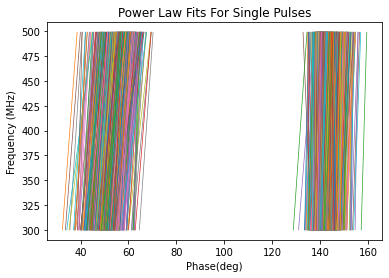

In [43]:
#Create empty arrays to be used when calculating averages of all fits
sp_params=[]
sp_cov=[]
sp_ave=[]

sp1_phase_400=[]
sp1_slope_400=[]
sp1_slope_errors=[]
sp1_phase_errors=[]
sp2_phase_400=[]
sp2_slope_400=[]
sp2_slope_errors=[]
sp2_phase_errors=[]
#Used to ensure average points are calculated at frequency intervals of 5MHz
sp_f=list(range(300, 501, 5))
for fq in sp_f:
    sp_ave.append(pl_av(frequency=fq,phase=[]))
    
#Graph what the average components are doing
#ax1,ay1=create_lin_fit(300,500,74.480,0.147)
#py.plot((np.array(ay1)-36),ax1,lw=4,color='black', label='average component movement', zorder=100000)   
#ax2,ay2=create_lin_fit(300,500,267.242,-0.004)
#py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    

#for a in range(3000,3100):
for a in range(0,9600):
    #Load in a pulse at a time
    pnum=str(pulse_names[a][-28:-18])
    print(a,pnum)
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    scrunched_pulse = np.loadtxt(fname=ave_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1

    fit_spulse = []

    #Get expected values for the gaussian fit through fitting gaussians to the average F scrunched profile
    ax=scrunched_pulse['phase']
    ay=scrunched_pulse['intensity']
    noise = sigmaClip(ay)
    aerror = np.nanstd(noise[1])
    expect=find_expected(ax,ay,aerror)
    
    freqgraph_data=[]
    
    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband
        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
        
        freqgraph_data.append(list(y))
        
        #Fit gaussians to each frequency channel
        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
            #Find the peaks at each frequency and add to an array
            if fit!=[] and expect!=[]:
                pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error)
                fit_spulse.append(pulse_subp)
            

    #Find the movement of pulse across frequency and fit equations to them
    all_fits = find_fits(fit_spulse,pnum,freqgraph_data)
    
    #Manually remove pulses which have been visually tested
    all_fits = manual_removal(a, all_fits)
    
    py.figure(1)

    #For all pulses with a fit, graph the powerlaw equation
    for v, fits in enumerate(all_fits):
        if fits!=0 and fits[1]!=0:
            #Create a continuous powerlaw fit from 300 to 500MHz -using fit parameters
            x1,y1=create_lin_fit(300,500,fits[2][0][0],fits[2][0][1])
            #Plot the linear fit
            py.plot(y1,x1, lw=0.7)
            print('Plot',v+1)
            #Add the parameters and covarience matrix to an ongoing array
            sp_params.extend(fits[2][0])
            sp_cov.append(fits[2][2])
            
            if v==0:
                sp1_slope_400.append(fits[2][0][0])
                sp1_slope_errors.append(fits[2][1][0])
                sp1_phase_400.append(linear(400, *fits[2][0]))
                sp1_phase_errors.append(np.sqrt((400*fits[2][1][0])**2+(fits[2][1][1])**2))
                
            elif v==3:
                sp2_slope_400.append(fits[2][0][0])
                sp2_slope_errors.append(fits[2][1][0])
                sp2_phase_400.append(linear(400, *fits[2][0]))
                sp2_phase_errors.append(np.sqrt((400*fits[2][1][0])**2+(fits[2][1][1])**2))
            
            #For frequencies in the range of 300-500, stepping up by 5MHz,
            #Store the positions of the power law fits at each frequency 
            for i,fq in enumerate(sp_f):
                sp_ave[i][1].append(powerlaw(fq,fits[1][0][0],fits[1][0][1]))

#Set up the graphing axis and titles  
#py.legend()
py.title('Power Law Fits For Single Pulses')
py.xlabel('Phase(deg)')
py.ylabel('Frequency (MHz)')
py.savefig('figures/spulse1500.png')

In [56]:
a_file = open("sp1_phase_400MHz.txt", "w")
b_file = open("sp1_slope_400MHz.txt", "w")

np.savetxt(a_file, sp1_phase_400)
np.savetxt(b_file, sp1_slope_400)

a_file.close()
b_file.close()

c_file = open("sp2_phase_400MHz.txt", "w")
d_file = open("sp2_slope_400MHz.txt", "w")

np.savetxt(c_file, sp2_phase_400)
np.savetxt(d_file, sp2_slope_400)

c_file.close()
d_file.close()

e_file = open("sp1_slope_errors.txt", "w")
f_file = open("sp2_slope_errors.txt", "w")

np.savetxt(e_file, sp1_slope_errors)
np.savetxt(f_file, sp2_slope_errors)

e_file.close()
f_file.close()

## Utilising Saved Files with Subpulse Data

In [58]:
sp1_phase_400 = np.loadtxt(fname="sp1_phase_400MHz.txt")
sp1_slope_400 = np.loadtxt(fname="sp1_slope_400MHz.txt")
sp2_phase_400 = np.loadtxt(fname="sp2_phase_400MHz.txt")
sp2_slope_400 = np.loadtxt(fname="sp2_slope_400MHz.txt")
sp1_slope_errors = np.loadtxt(fname="sp1_slope_errors.txt")
sp2_slope_errors = np.loadtxt(fname="sp2_slope_errors.txt")

## Ratio Plots and Calculations

In [59]:
p_ave1=average(sp1_phase_400)
s_ave1=average(sp1_slope_400)
p_ave2=average(sp2_phase_400)
s_ave2=average(sp2_slope_400)

In [60]:
p_com1=58.139424476674016
s_com1=0.06303343953077173
p_com2=141.07073061007532
s_com2=-0.0020150191507454633

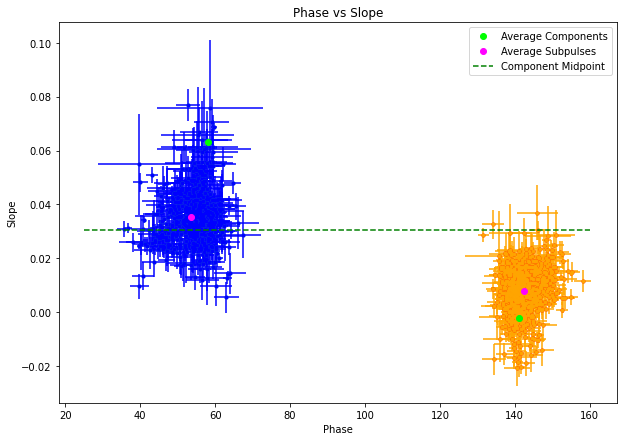

In [61]:
py.figure(figsize=(10,7))
py.plot(sp1_phase_400,sp1_slope_400, '.')
py.errorbar(sp1_phase_400,sp1_slope_400, yerr=sp1_slope_errors,xerr=sp1_phase_errors, fmt='.', color='blue')
py.plot(sp2_phase_400,sp2_slope_400, '.',color='red')
py.errorbar(sp2_phase_400,sp2_slope_400, yerr=sp2_slope_errors,xerr=sp2_phase_errors, fmt='.', color='orange')
py.title('Phase vs Slope')
py.plot([p_com1,p_com2],[s_com1,s_com2],'o',color='lime',label="Average Components",zorder=10)
py.plot([p_ave1,p_ave2],[s_ave1,s_ave2],'o',color='magenta',label="Average Subpulses",zorder=10)
py.plot([25,160],[((s_com1-s_com2)/2)+s_com2,((s_com1-s_com2)/2)+s_com2],'--',color='green',label='Component Midpoint',zorder=9)
py.legend()
py.xlabel('Phase')
py.ylabel('Slope')
py.savefig('figures/PS_both.png')

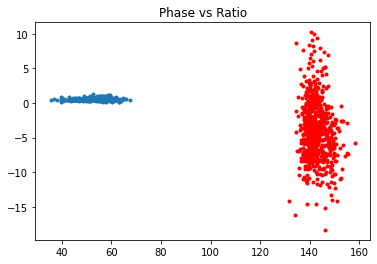

In [62]:
py.plot(sp1_phase_400,np.array(sp1_slope_400)/0.06303343953077173, '.')
py.plot(sp2_phase_400,np.array(sp2_slope_400)/-0.0020150191507454633, '.',color='red')
py.title('Phase vs Ratio')
py.savefig('figures/PR_both.png')

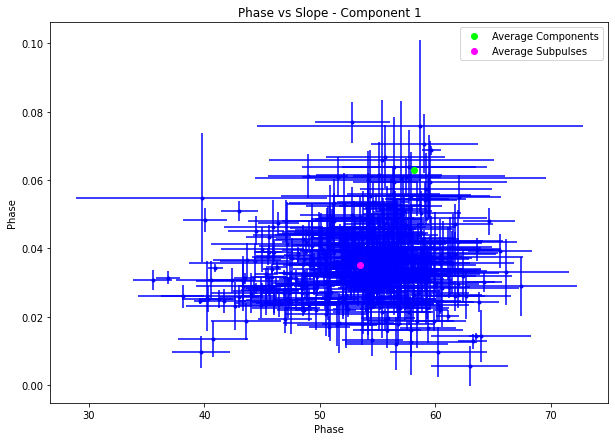

In [63]:
py.figure(figsize=(10,7))
#py.plot(sp1_phase_400,sp1_slope_400, '.')
py.errorbar(sp1_phase_400,sp1_slope_400, yerr=sp1_slope_errors,xerr=sp1_phase_errors, fmt='.', color='blue')
py.plot([58.139424476674016],[0.06303343953077173],'o',color='lime',label="Average Components",zorder=10)
py.plot([p_ave1],[s_ave1],'o',color='magenta',label="Average Subpulses",zorder=10)
py.title('Phase vs Slope - Component 1')
py.legend()
py.xlabel('Phase')
py.ylabel('Phase')
py.savefig('figures/PS_1.png')

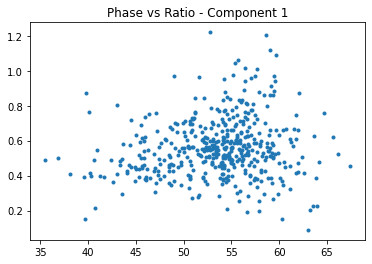

In [64]:
py.plot(sp1_phase_400,np.array(sp1_slope_400)/0.06303343953077173, '.')
py.title('Phase vs Ratio - Component 1')
py.savefig('figures/PR_1.png')

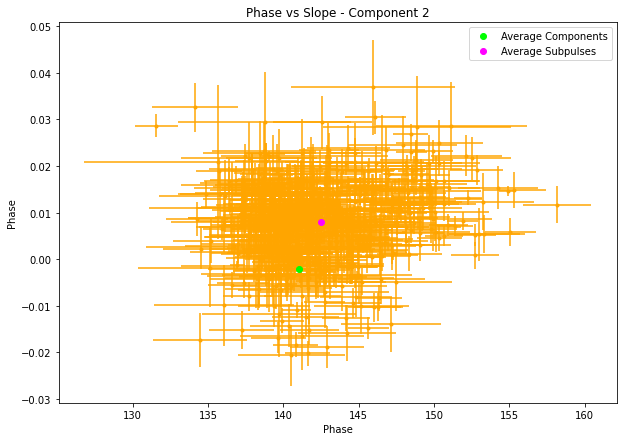

In [65]:
#py.plot(sp2_phase_400,sp2_slope_400, '.',color='red')
py.figure(figsize=(10,7))
py.errorbar(sp2_phase_400,sp2_slope_400, yerr=sp2_slope_errors,xerr=sp2_phase_errors, fmt='.', color='orange')
py.title('Phase vs Slope - Component 2')
py.plot([141.07073061007532],[-0.0020150191507454633],'o',color='lime',label="Average Components",zorder=10)
py.plot([p_ave2],[s_ave2],'o',color='magenta',label="Average Subpulses",zorder=10)
py.legend()
py.xlabel('Phase')
py.ylabel('Phase')
py.savefig('figures/PS_2.png')

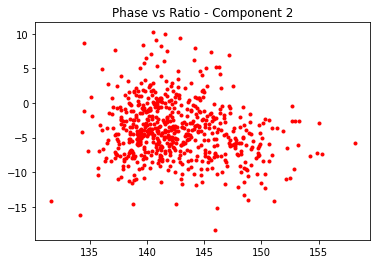

In [70]:
py.plot(sp2_phase_400,np.array(sp2_slope_400)/-0.0020150191507454633, '.', color='red')
py.title('Phase vs Ratio - Component 2')
py.savefig('figures/PR_2.png')

In [67]:
print('Ratio Value 1:', s_ave1/0.06303343953077173)
print('Ratio Value 2:', s_ave2/-0.0020150191507454633)

Ratio Value 1: 0.5594154235694038
Ratio Value 2: -3.9229526825288064


#### DM Ratio Plots

Intersection DMs:  [112.66266266 113.22322322 113.42342342]


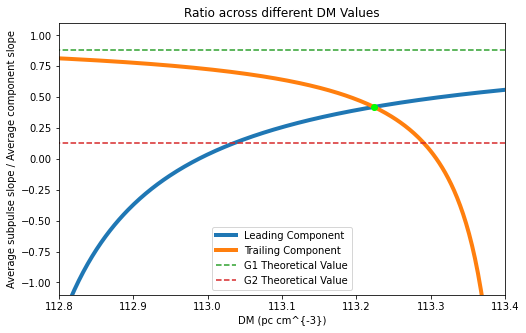

In [72]:
# Input measurements
ssL = s_ave1
ssR = s_ave2
scL = s_com1
scR = s_com2

# DMs and how the slope changes
DMs   = np.linspace(112,114,1000) # pc cm^{-3}
DMcat = 113.4                     # pc cm^{-3}
f     = 400                       # MHz
D     = 4.148808e3                # MHz^2 pc^{-1} cm^3 s
P     = 0.545445560075            # s
k     = 4*np.pi*D/P/f**3 * 180/np.pi     # deg MHz^{-1} pc^{-1} cm^3 (i.e. "slope units per DM unit")
ks    = k*(DMs - 113.4)           # deg MHz^{-1} (i.e. "slope units")

# Plot Ratios
py.figure(figsize=(8,5))
lc=(ssL + ks)/(scL + ks)
tc=(ssR + ks)/(scR + ks)

py.plot(DMs, (ssL + ks)/(scL + ks),lw=4,label='Leading Component')
py.plot(DMs, (ssR + ks)/(scR + ks),lw=4,label='Trailing Component')

#Plot Theory Value
py.plot([112,114],[0.880662,0.880662], '--', label='G1 Theoretical Value')
py.plot([112,114],[0.126042,0.126042], '--', label='G2 Theoretical Value')


# Plot appearance
py.axis([112.8, 113.4, -1.1,1.1])
py.xlabel("DM (pc cm^{-3})");
py.ylabel("Average subpulse slope / Average component slope");
py.legend()
py.title('Ratio across different DM Values')

#Plot intersection points
idx = np.argwhere(np.diff(np.sign(lc - tc))).flatten()
py.plot(DMs[idx], lc[idx], 'o', color='lime',label='Symmetrical Carousel')

print('Intersection DMs: ', DMs[idx])



# Save the plot to file
py.savefig('figures/RDM.png')